In [373]:
%load_ext nb_black

from numpy.random import seed

seed(123)


import tensorflow as tf

tf.config.experimental_run_functions_eagerly(True)


tf.random.set_seed(123)


import pandas as pd
from pathlib import Path
import os
from os.path import isfile, join
from datetime import date
import csv
import numpy as np
import matplotlib.pyplot as plt

# assign working directory to variable
file_path = os.getcwd()
# setting path for data folder
DATA_PATH = Path.cwd().parent / "Belgian_gfs_Forecast"
print(DATA_PATH)

The nb_black extension is already loaded. To reload it, use:
  %reload_ext nb_black
C:\Documents\Belgian_gfs_Forecast


<IPython.core.display.Javascript object>

In [374]:
power = pd.read_csv(DATA_PATH / "Belgian_power_2016_2017_3hrly.csv")

power["TIMESTAMP"] = pd.to_datetime(power["TIMESTAMP"])

date_from = pd.Timestamp(date(2016,1,1))
date_to = pd.Timestamp(date(2018,1,1))


<IPython.core.display.Javascript object>

In [375]:
power = power[(power["TIMESTAMP"] >= date_from) & (power["TIMESTAMP"] <= date_to)]

# power[240 : len(power)]
y = power["Obs_3hr"].values.reshape(len(power), 1)
mask = np.isnan(y)
y[mask] = np.interp(np.flatnonzero(mask), np.flatnonzero(~mask), y[~mask])


power_r = power["rated_3hr"].values.reshape(power.shape[0], 1)

mask = np.isnan(power_r)
power_r[mask] = np.interp(np.flatnonzero(mask), np.flatnonzero(~mask), power_r[~mask])


mask = np.isnan(y)
y[mask] = np.interp(np.flatnonzero(mask), np.flatnonzero(~mask), y[~mask])


mask = np.isnan(power_r)
power_r[mask] = np.interp(np.flatnonzero(mask), np.flatnonzero(~mask), power_r[~mask])
power_r.max()
Pnor = np.divide(y, power_r)
y = Pnor

<IPython.core.display.Javascript object>

In [376]:
from netCDF4 import Dataset

fn = "O:\\TU_hpc12\\Ramps_forecast\\U_2016_2017_predictor_gfs.nc"
fn = "C:\\Documents\\Belgian_gfs_Forecast\\U_2016_2017_predictor_0625_gfs.nc"
ds = Dataset(fn, mode="r")

# lons = ds.variables["lon"][:]
# lats = ds.variables["lat"][:]
Us = ds.variables["U_2016"]
Ut = np.transpose(Us)
Ut.shape

(5848, 42)

<IPython.core.display.Javascript object>

In [377]:
# from netCDF4 import Dataset

# fn = "O:\\TU_hpc12\\Ramps_forecast\\gfs_4_2016_2017.nc"
# ds = Dataset(fn, mode="r")

# lons = ds.variables["lon"][:]
# lats = ds.variables["lat"][:]
# Us = ds.variables["U"]
# Ut = np.transpose(Us)
# Ut.shape

# import nctoolkit as nc

# lat_bnds, lon_bnds = [49, 54], [-4, 8]

# lat_inds = np.where((lats > lat_bnds[0]) & (lats < lat_bnds[1]))[0]
# lon_inds = np.where((lons > lon_bnds[0]) & (lons < lon_bnds[1]))[0]

# U = np.squeeze(ds.variables["U"][:, :, lat_inds, lon_inds])

# Ut = U.reshape(len(U), U.shape[1] * U.shape[2])
# Ut.shape

<IPython.core.display.Javascript object>

In [378]:
x = np.concatenate(
    (Ut, power_r),
    axis=1,
)

x = Ut

<IPython.core.display.Javascript object>

In [379]:
splt_1 = 0.8
splt_2 = 0.9
n_lags = 0

yy = y[n_lags:, :]

n = len(y)
y_train = yy[0 : int(n * splt_1)]
y_val = yy[int(n * splt_1) : int(n * splt_2)]
y_test = y[int(n * splt_2) :]

y_train_Ens = yy[0 : int(n * splt_2)]

[y_train_Ens.shape, y_val.shape, y_test.shape]

[(5263, 1), (585, 1), (585, 1)]

<IPython.core.display.Javascript object>

In [380]:
n = len(x)
# x = np.concatenate(
#     (Ut, power_r),
#     axis=1,
# )

xx = x[n_lags:, :]

y_train_Ens = yy[n_lags : int(n * splt_2)]
X_train_Ens = xx[n_lags : int(n * splt_2)]
X_test = x[int(n * splt_2) :]


# https://stackoverflow.com/questions/29438265/stratified-train-test-split-in-scikit-learn

from sklearn.model_selection import train_test_split

# 5 bins may be too few for larger datasets.
bins = np.linspace(start=np.amin(y_train_Ens), stop=np.amax(y_train_Ens), num=60)

y_binned = np.digitize(y_train_Ens, bins, right=True)

train_X, val_X, train_y, val_y = train_test_split(
    X_train_Ens, y_train_Ens, test_size=0.111, stratify=y_binned
)
[
    train_X.max(),
    val_X.max(),
    train_y.max(),
    val_y.max(),
    X_test.max(),
]

[31.295209884643555,
 30.454668045043945,
 0.9702939249274543,
 0.9703138163437236,
 29.242542266845703]

<IPython.core.display.Javascript object>

# SMOGN

In [381]:
y_train = yy[n_lags : int(n * splt_1)]
y_val = yy[int(n * splt_1) : int(n * splt_2)]
[y_train.shape, y_val.shape]

[(4678, 1), (585, 1)]

<IPython.core.display.Javascript object>

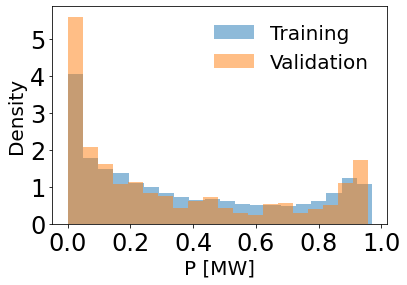

<IPython.core.display.Javascript object>

In [382]:
n_bins = 20
plt.figure(figsize=(6, 4))
plt.hist(y_train, bins=n_bins, density=True, alpha=0.5, label="Training")
plt.hist(y_val, bins=n_bins, density=True, alpha=0.5, label="Validation")

plt.xlabel("P [MW]", size=20)
plt.ylabel("Density", size=20)
# plt.title("(a)", size=14)
plt.legend(loc="upper right")
plt.legend(frameon=False, ncol=1, fontsize=20)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
# plt.ylim([0, 0.007])
# plt.xlim([-5, 850])
plt.savefig("Training_validation_distribution.svg", format="svg", dpi=1200)

In [383]:
# df = pd.DataFrame(x)
# df.columns = ["s_" + str(i) for i in range(0, 124)]


<IPython.core.display.Javascript object>

In [384]:
# housing_smogn = smogn.smoter(
#     data=df,
#     y="s_123",  ## pandas dataframe  ## string ('header name')
#     ## phi relevance arguments
#     rel_method="automanual",  ## string ('auto' or 'manual')
#     # rel_xtrm_type = 'both', ## unused (rel_method = 'manual')
#     # rel_coef=2.50,  ## unused (rel_method = 'manual')
# )

<IPython.core.display.Javascript object>

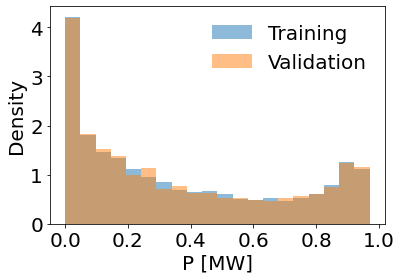

<IPython.core.display.Javascript object>

In [385]:
# n_lags = 0
# train_X_l, val_X_l = train_test_split(
#     X_trainl_Ens[: len(X_trainl_Ens) - n_lags],
#     test_size=0.111,
#     stratify=y_binned[: len(y_binned) - n_lags],
# )

# train_y_l, val_y_l = train_test_split(
#     y_train_Ens[n_lags:], test_size=0.111, stratify=y_binned[n_lags:]
# )
# [
#     train_X_l.shape,
#     train_y_l.shape,
#     val_X_l.shape,
#     val_y_l.shape,
#     test_X_l.shape,
#     test_y_l.shape,
# ]
n_bins = 20
plt.figure(figsize=(6, 4))
plt.hist(train_y, bins=n_bins, density=True, alpha=0.5, label="Training")
plt.hist(val_y, bins=n_bins, density=True, alpha=0.5, label="Validation")

plt.xlabel("P [MW]", size=20)
plt.ylabel("Density", size=20)
# plt.title("(a)", size=20)
plt.legend(loc="upper right")
plt.legend(frameon=False, ncol=1, fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
# plt.ylim([0, 0.007])
# plt.xlim([-5, 850])
plt.savefig("Training_validation_distribution_bin.svg", format="svg", dpi=1200)

In [386]:
from keras import layers, models, optimizers
from keras.utils.vis_utils import plot_model
from keras import metrics
import pydot
import keras

from numpy.random import seed

seed(1)


import tensorflow

tensorflow.random.set_seed(1)

from tensorflow.keras.layers import Input, LSTM, Dense, Concatenate
from tensorflow.keras.models import Model
kernel_init ="he_uniform"
bias_init = keras.initializers.Constant(value=0.2)

from keras import layers, models, optimizers
from keras import metrics
from keras.layers import Input, Dense, Flatten, Reshape, Dropout, SpatialDropout1D
from keras.layers.merge import average

# , kernel_initializer="he_uniform"

mlp_input = Input(shape= train_X.shape[1])

hidden1 = Dense(32, activation="relu")(mlp_input)
hidden2 = Dense(32, activation="relu")(hidden1)
hidden3 = Dense(64, activation="relu")(hidden2)
hidden4 = Dense(128, activation="relu")(hidden3)
# hidden5 = layers.Dropout(0.05)(hidden4)
hidden6 = Dense(256, activation="relu")(hidden4)
hidden7 = layers.Dropout(0.35)(hidden6)
hidden8 = Dense(32, activation="relu")(hidden7)


mlp_out = Dense(1)(hidden8)
model_mlp = Model(inputs=mlp_input, outputs=mlp_out)
model_mlp.compile(loss="mae", optimizer=optimizers.Adam(lr=0.00001))
model_mlp.summary()





Model: "model_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_18 (InputLayer)        [(None, 42)]              0         
_________________________________________________________________
dense_119 (Dense)            (None, 32)                1376      
_________________________________________________________________
dense_120 (Dense)            (None, 32)                1056      
_________________________________________________________________
dense_121 (Dense)            (None, 64)                2112      
_________________________________________________________________
dense_122 (Dense)            (None, 128)               8320      
_________________________________________________________________
dense_123 (Dense)            (None, 256)               33024     
_________________________________________________________________
dropout_17 (Dropout)         (None, 256)               0  

<IPython.core.display.Javascript object>

In [387]:
from keras import backend as K
from keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger

# OUTPUT_DIR  = os.path.join(PATH,"bcheneka" )
StrOut = "History_mlp.csv"
csv_logger = CSVLogger(StrOut, append=False, separator=";")

STR = "mlp.hdf5"

F = STR
ch = ModelCheckpoint(F, monitor="val_loss", save_best_only=True, mode="min", verbose=0)
es = EarlyStopping(monitor="val_loss", mode="min", patience=25, verbose=0)



<IPython.core.display.Javascript object>

In [388]:
callbacks_list = [ch, es, csv_logger]

epochs = 2000
batch_size = 32


history = model_mlp.fit(
    x=[train_X],
    y=train_y,
    validation_data=([val_X], val_y),
    epochs=epochs,
    batch_size=batch_size,
    callbacks=callbacks_list,
    verbose=1,
)

Epoch 1/2000
  1/147 [..............................] - ETA: 9s - loss: 0.4436

C:\Users\bcheneka\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\data\ops\dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


147/147 [==============================] - 4s 24ms/step - loss: 0.3620 - val_loss: 0.1781
Epoch 2/2000
147/147 [==============================] - 3s 22ms/step - loss: 0.2673 - val_loss: 0.1600
Epoch 3/2000
147/147 [==============================] - 3s 24ms/step - loss: 0.2342 - val_loss: 0.1500
Epoch 4/2000
147/147 [==============================] - 5s 32ms/step - loss: 0.2093 - val_loss: 0.1404
Epoch 5/2000
147/147 [==============================] - 5s 31ms/step - loss: 0.1939 - val_loss: 0.1348
Epoch 6/2000
147/147 [==============================] - 4s 29ms/step - loss: 0.1810 - val_loss: 0.1306
Epoch 7/2000
147/147 [==============================] - 3s 17ms/step - loss: 0.1804 - val_loss: 0.1289
Epoch 8/2000
147/147 [==============================] - 3s 19ms/step - loss: 0.1682 - val_loss: 0.1287
Epoch 9/2000
147/147 [==============================] - 3s 21ms/step - loss: 0.1679 - val_loss: 0.1270
Epoch 10/2000
147/147 [==============================] - 3s 22ms/step - loss: 0.1589 -

Epoch 80/2000
147/147 [==============================] - 3s 17ms/step - loss: 0.1032 - val_loss: 0.0972
Epoch 81/2000
147/147 [==============================] - 2s 17ms/step - loss: 0.1050 - val_loss: 0.0970
Epoch 82/2000
147/147 [==============================] - 3s 17ms/step - loss: 0.1049 - val_loss: 0.0975
Epoch 83/2000
147/147 [==============================] - 3s 17ms/step - loss: 0.1095 - val_loss: 0.0973
Epoch 84/2000
147/147 [==============================] - 3s 17ms/step - loss: 0.1055 - val_loss: 0.0972
Epoch 85/2000
147/147 [==============================] - 3s 17ms/step - loss: 0.1049 - val_loss: 0.0971
Epoch 86/2000
147/147 [==============================] - 2s 17ms/step - loss: 0.1044 - val_loss: 0.0971
Epoch 87/2000
147/147 [==============================] - 3s 21ms/step - loss: 0.1034 - val_loss: 0.0971
Epoch 88/2000
147/147 [==============================] - 2s 17ms/step - loss: 0.1059 - val_loss: 0.0977
Epoch 89/2000
147/147 [==============================] - 3s 19ms

147/147 [==============================] - 2s 13ms/step - loss: 0.0991 - val_loss: 0.0953
Epoch 159/2000
147/147 [==============================] - 2s 14ms/step - loss: 0.0962 - val_loss: 0.0953
Epoch 160/2000
147/147 [==============================] - 2s 15ms/step - loss: 0.1005 - val_loss: 0.0955
Epoch 161/2000
147/147 [==============================] - 2s 13ms/step - loss: 0.0966 - val_loss: 0.0960
Epoch 162/2000
147/147 [==============================] - 2s 13ms/step - loss: 0.0981 - val_loss: 0.0960
Epoch 163/2000
147/147 [==============================] - 2s 14ms/step - loss: 0.0998 - val_loss: 0.0957
Epoch 164/2000
147/147 [==============================] - 2s 14ms/step - loss: 0.0965 - val_loss: 0.0961
Epoch 165/2000
147/147 [==============================] - 2s 14ms/step - loss: 0.0993 - val_loss: 0.0953
Epoch 166/2000
147/147 [==============================] - 2s 14ms/step - loss: 0.0987 - val_loss: 0.0950
Epoch 167/2000
147/147 [==============================] - 2s 14ms/step

147/147 [==============================] - 2s 14ms/step - loss: 0.0973 - val_loss: 0.0939
Epoch 237/2000
147/147 [==============================] - 3s 17ms/step - loss: 0.0970 - val_loss: 0.0938
Epoch 238/2000
147/147 [==============================] - 2s 15ms/step - loss: 0.0933 - val_loss: 0.0937
Epoch 239/2000
147/147 [==============================] - 2s 14ms/step - loss: 0.0932 - val_loss: 0.0947
Epoch 240/2000
147/147 [==============================] - 3s 17ms/step - loss: 0.0954 - val_loss: 0.0933
Epoch 241/2000
147/147 [==============================] - 2s 14ms/step - loss: 0.0943 - val_loss: 0.0939
Epoch 242/2000
147/147 [==============================] - 2s 15ms/step - loss: 0.0963 - val_loss: 0.0936
Epoch 243/2000
147/147 [==============================] - 3s 18ms/step - loss: 0.0952 - val_loss: 0.0942
Epoch 244/2000
147/147 [==============================] - 2s 14ms/step - loss: 0.0955 - val_loss: 0.0943
Epoch 245/2000
147/147 [==============================] - 2s 14ms/step

147/147 [==============================] - 3s 19ms/step - loss: 0.0930 - val_loss: 0.0920
Epoch 315/2000
147/147 [==============================] - 3s 20ms/step - loss: 0.0883 - val_loss: 0.0928
Epoch 316/2000
147/147 [==============================] - 3s 22ms/step - loss: 0.0877 - val_loss: 0.0905
Epoch 317/2000
147/147 [==============================] - 3s 19ms/step - loss: 0.0906 - val_loss: 0.0924
Epoch 318/2000
147/147 [==============================] - 3s 18ms/step - loss: 0.0878 - val_loss: 0.0917
Epoch 319/2000
147/147 [==============================] - 3s 20ms/step - loss: 0.0862 - val_loss: 0.0912
Epoch 320/2000
147/147 [==============================] - 3s 21ms/step - loss: 0.0903 - val_loss: 0.0914
Epoch 321/2000
147/147 [==============================] - 3s 19ms/step - loss: 0.0884 - val_loss: 0.0910
Epoch 322/2000
147/147 [==============================] - 3s 18ms/step - loss: 0.0901 - val_loss: 0.0921
Epoch 323/2000
147/147 [==============================] - 2s 15ms/step

147/147 [==============================] - 3s 17ms/step - loss: 0.0856 - val_loss: 0.0885
Epoch 393/2000
147/147 [==============================] - 3s 17ms/step - loss: 0.0861 - val_loss: 0.0914
Epoch 394/2000
147/147 [==============================] - 3s 19ms/step - loss: 0.0843 - val_loss: 0.0898
Epoch 395/2000
147/147 [==============================] - 3s 18ms/step - loss: 0.0855 - val_loss: 0.0888
Epoch 396/2000
147/147 [==============================] - 3s 21ms/step - loss: 0.0852 - val_loss: 0.0897
Epoch 397/2000
147/147 [==============================] - 3s 17ms/step - loss: 0.0825 - val_loss: 0.0892
Epoch 398/2000
147/147 [==============================] - 3s 17ms/step - loss: 0.0867 - val_loss: 0.0898
Epoch 399/2000
147/147 [==============================] - 2s 17ms/step - loss: 0.0861 - val_loss: 0.0891
Epoch 400/2000
147/147 [==============================] - 3s 17ms/step - loss: 0.0836 - val_loss: 0.0888
Epoch 401/2000
147/147 [==============================] - 3s 17ms/step

147/147 [==============================] - 3s 17ms/step - loss: 0.0817 - val_loss: 0.0850
Epoch 471/2000
147/147 [==============================] - 2s 17ms/step - loss: 0.0802 - val_loss: 0.0865
Epoch 472/2000
147/147 [==============================] - 2s 17ms/step - loss: 0.0801 - val_loss: 0.0850
Epoch 473/2000
147/147 [==============================] - 3s 17ms/step - loss: 0.0820 - val_loss: 0.0866
Epoch 474/2000
147/147 [==============================] - 3s 20ms/step - loss: 0.0803 - val_loss: 0.0848
Epoch 475/2000
147/147 [==============================] - 3s 17ms/step - loss: 0.0776 - val_loss: 0.0897
Epoch 476/2000
147/147 [==============================] - 3s 17ms/step - loss: 0.0800 - val_loss: 0.0877
Epoch 477/2000
147/147 [==============================] - 3s 17ms/step - loss: 0.0810 - val_loss: 0.0862
Epoch 478/2000
147/147 [==============================] - 3s 17ms/step - loss: 0.0847 - val_loss: 0.0859
Epoch 479/2000
147/147 [==============================] - 3s 20ms/step

147/147 [==============================] - 3s 18ms/step - loss: 0.0781 - val_loss: 0.0844
Epoch 549/2000
147/147 [==============================] - 3s 18ms/step - loss: 0.0796 - val_loss: 0.0845
Epoch 550/2000
147/147 [==============================] - 3s 21ms/step - loss: 0.0778 - val_loss: 0.0837
Epoch 551/2000
147/147 [==============================] - 3s 18ms/step - loss: 0.0778 - val_loss: 0.0853
Epoch 552/2000
147/147 [==============================] - 3s 17ms/step - loss: 0.0770 - val_loss: 0.0836
Epoch 553/2000
147/147 [==============================] - 3s 18ms/step - loss: 0.0793 - val_loss: 0.0841
Epoch 554/2000
147/147 [==============================] - 3s 18ms/step - loss: 0.0768 - val_loss: 0.0832
Epoch 555/2000
147/147 [==============================] - 3s 18ms/step - loss: 0.0787 - val_loss: 0.0858
Epoch 556/2000
147/147 [==============================] - 3s 17ms/step - loss: 0.0779 - val_loss: 0.0852
Epoch 557/2000
147/147 [==============================] - 3s 18ms/step

<IPython.core.display.Javascript object>

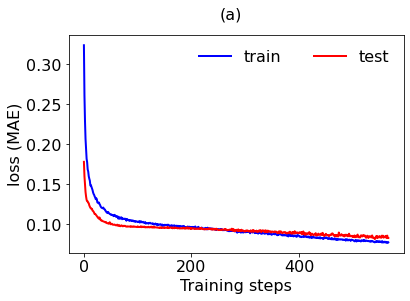

<IPython.core.display.Javascript object>

In [389]:
import matplotlib.pyplot as mpl

fig = plt.figure()
plt.plot(history.history["loss"], c="b", label="train", linewidth=2.0)
plt.plot(history.history["val_loss"], c="r", label="test", linewidth=2.0)
fig.suptitle("(a)", fontsize=16)
plt.xlabel("Training steps", fontsize=16)
plt.ylabel("loss (MAE)", fontsize=16)
plt.legend(loc="upper right")
plt.legend(frameon=False, ncol=2, fontsize=16)
mpl.rcParams["font.size"] = 16
fig.savefig("MLP_learning_curve.eps", bbox_inches="tight")

In [390]:
# make a prediction


model_mlp.load_weights("mlp.hdf5")
yhat = model_mlp.predict(X_test)
yhat_train = model_mlp.predict(train_X)
yhat_val = model_mlp.predict(val_X)


yt = np.multiply(y[len(y_train_Ens) :], power_r[len(y_train_Ens) :])
yh = np.multiply(yhat, power_r[len(y_train_Ens) :])

yh[yh > yt.max()] = yt.max()
yh[yh < 0] = 0


# yhat_train[yhat_train > 812] = 812

# yhat_val[yhat_val > 812] = 812

<IPython.core.display.Javascript object>

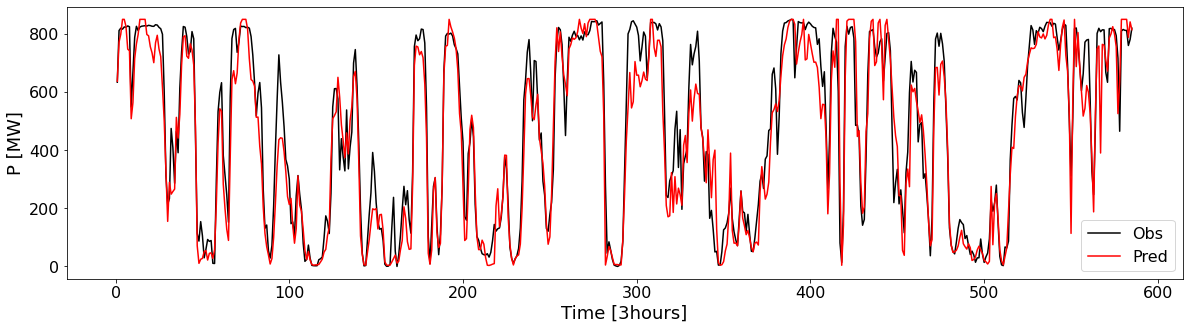

<IPython.core.display.Javascript object>

In [391]:
epochs = range(1, len(y_test) + 1)

plt.figure(figsize=(20, 5))
plt.plot(epochs, yt, "black", label="Obs")
# plt.plot(dataframe, "green", label="Naive")
plt.plot(epochs, yh, "red", label="Pred")


# plt.plot(epochs, np.abs(DataFrame(power_test["nowcast_3hr"])), "blue", label="Nowcast")
# plt.plot(epochs, np.abs(DataFrame(power_test["dayahead_3hr"])), "pink", label="Dayahead")


plt.xlabel("Time [3hours]", fontsize=18)
plt.ylabel("P [MW]", fontsize=18)
# plt.title("Training and validation loss")
plt.legend()

In [395]:
yhat = pd.DataFrame(yh)
yhat.to_csv("MLP_1D_test.csv", float_format="%.2f", index=False)

<IPython.core.display.Javascript object>

In [396]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score


[
    mean_absolute_error(yt, yh),
    mean_squared_error(yt, yh, squared=False),
    mean_absolute_percentage_error(yt, yh),
    r2_score(yt, yh),
]

[66.32465743628389, 91.67654886163405, 137869051514229.14, 0.9084399722882873]

<IPython.core.display.Javascript object>

In [23]:
[y_test.mean(), np.std(np.array(y_test)), yhat.mean(), np.std(np.array(yhat))]

[469.01150997150995,
 302.9739564694235,
 0    411.443726
 dtype: float32,
 286.72003]

<IPython.core.display.Javascript object>

In [31]:
[
    np.quantile(y_test, 0.5),
    np.quantile(y_test, 0.95),
    np.quantile(yhat, 0.5),
    np.quantile(yhat, 0.95),
]

[0.5554358565131475,
 0.9521538227694181,
 0.4378758370876312,
 0.9703003764152527]

<IPython.core.display.Javascript object>

# LSTM Architecture 

In [762]:
def split_series(series, y_series, n_past, n_future):
    #
    # n_past ==> no of past observations
    #
    # n_future ==> no of future observations
    #
    X, y = list(), list()
    for window_start in range(len(series)):
        past_end = window_start + n_past
        future_end = past_end + n_future
        if future_end > len(series):
            break
        # slicing the past and future parts of the window
        past, future = (
            series[window_start:past_end, :],
            y_series[past_end:future_end, :],
        )
        X.append(past)
        y.append(future)
    return np.array(X), np.array(y)



<IPython.core.display.Javascript object>

In [763]:
x = np.concatenate(
    (Ut, power_r),
    axis=1,
)

# x[:, :3]

<IPython.core.display.Javascript object>

In [764]:
n_past = 3
n_future = 1

train_Xx, train_yy = split_series(x,y, n_past, n_future)

[train_Xx.shape, train_yy.shape]



[(5845, 3, 123), (5845, 1, 1)]

<IPython.core.display.Javascript object>

In [765]:
splt_1 = 0.8
splt_2 = 0.9

n_train = int(splt_1 * len(train_Xx))
n_val = int(splt_2 * len(train_Xx))

X_train_LSTM, y_train_LSTM = train_Xx[:n_train, :], train_yy[:n_train, :]
X_val_LSTM, y_val_LSTM = train_Xx[n_train:n_val], train_yy[n_train:n_val]
X_test_LSTM, y_test_LSTM = train_Xx[n_val:, :], train_yy[n_val:, :]

[
    X_train_LSTM.shape,
    y_train_LSTM.shape,
    X_val_LSTM.shape,
    y_val_LSTM.shape,
    X_test_LSTM.shape,
    y_test_LSTM.shape,
]
# np.rint(y_val_LSTM)

[(4676, 3, 123),
 (4676, 1, 1),
 (584, 3, 123),
 (584, 1, 1),
 (585, 3, 123),
 (585, 1, 1)]

<IPython.core.display.Javascript object>

In [769]:
from tensorflow.keras.layers import Input, LSTM, Dense, Concatenate, Bidirectional
from keras.layers import TimeDistributed
from keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger
from keras import backend as K
from keras import layers, models, optimizers
from tensorflow.keras.models import Model


seed(1)


tensorflow.random.set_seed(1)

lstm_input = Input(shape=(X_train_LSTM.shape[1], X_train_LSTM.shape[2]))
# lstm units
hidden1 = Bidirectional(LSTM(256))(lstm_input)
# hidden11 = Bidirectional(LSTM(256))(hidden1)
hidden2 = Dense(128, activation="relu", kernel_initializer="he_uniform")(hidden1)
hidden3 = Dense(128, activation="relu", kernel_initializer="he_uniform")(hidden2)
hidden4 = Dense(256, activation="relu", kernel_initializer="he_uniform")(hidden3)
hidden5 = Dense(512, activation="relu", kernel_initializer="he_uniform")(hidden4)
hidden6 = layers.Dropout(0.4)(hidden5)
lstm_output = Dense(1)(hidden5)
model_lstm = Model(inputs=[lstm_input], outputs=lstm_output)


model_lstm.compile(loss="mae", optimizer=optimizers.Adam(lr=0.001))

<IPython.core.display.Javascript object>

In [770]:
from keras import backend as K
from keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger

# OUTPUT_DIR  = os.path.join(PATH,"bcheneka" )
StrOut = "History_mlp_lstm.csv"
csv_logger = CSVLogger(StrOut, append=False, separator=";")

STR = "mlp_lstm.hdf5"

F = STR
ch = ModelCheckpoint(F, monitor="val_loss", save_best_only=True, mode="min", verbose=0)
es = EarlyStopping(monitor="val_loss", mode="min", patience=40, verbose=0)



<IPython.core.display.Javascript object>

In [771]:
callbacks_list = [ch, es, csv_logger]

epochs = 2000
batch_size = 256


history = model_lstm.fit(
    x=[X_train_LSTM],
    y=y_train_LSTM,
    validation_data=([X_val_LSTM], y_val_LSTM),
    epochs=epochs,
    batch_size=batch_size,
    callbacks=callbacks_list,
    verbose=1,
)

Epoch 1/2000
19/19 [==============================] - 3s 137ms/step - loss: 259.2278 - val_loss: 234.9099
Epoch 2/2000
17/19 [=========================>....] - ETA: 0s - loss: 193.8206

KeyboardInterrupt: 

<IPython.core.display.Javascript object>

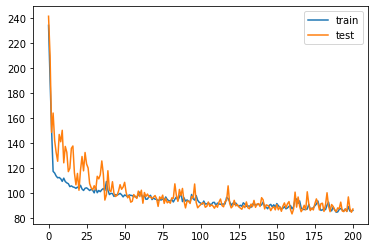

<IPython.core.display.Javascript object>

In [537]:
# plot history
plt.plot(history.history["loss"], label="train")
plt.plot(history.history["val_loss"], label="test")
plt.legend()
plt.show()

In [538]:
model_lstm.load_weights("mlp_lstm.hdf5")
yhat = model_lstm.predict([X_test_LSTM])

<IPython.core.display.Javascript object>

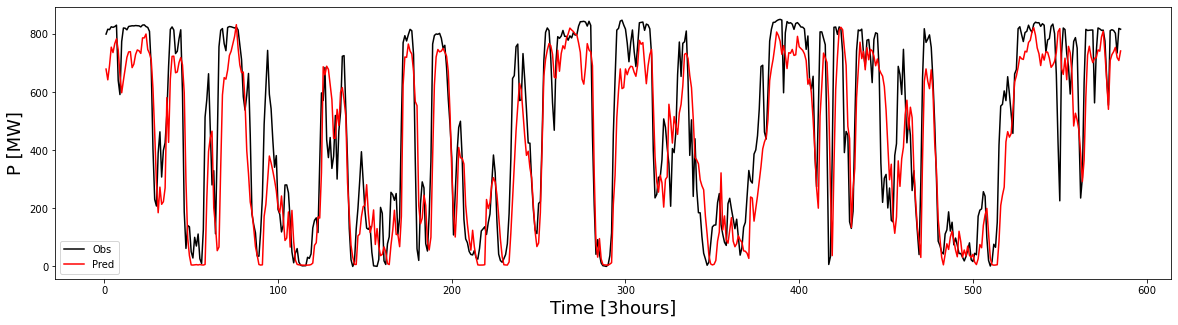

<IPython.core.display.Javascript object>

In [539]:
epochs = range(1, len(y_test_LSTM) + 1)

plt.figure(figsize=(20, 5))
plt.plot(epochs, np.squeeze(y_test_LSTM), "black", label="Obs")
# plt.plot(dataframe, "green", label="Naive")
plt.plot(epochs, yhat, "red", label="Pred")


# plt.plot(epochs, np.abs(DataFrame(power_test["nowcast_3hr"])), "blue", label="Nowcast")
# plt.plot(epochs, np.abs(DataFrame(power_test["dayahead_3hr"])), "pink", label="Dayahead")


plt.xlabel("Time [3hours]", fontsize=18)
plt.ylabel("P [MW]", fontsize=18)
# plt.title("Training and validation loss")
plt.legend()

In [540]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score


[
    mean_absolute_error(np.squeeze(y_test_LSTM), yhat),
    mean_squared_error(np.squeeze(y_test_LSTM), yhat, squared=False),
    mean_absolute_percentage_error(np.squeeze(y_test_LSTM), yhat),
    r2_score(np.squeeze(y_test_LSTM), yhat),
]

[113.33117921855306, 152.3105468340954, 286000980208972.56, 0.747889744221627]

<IPython.core.display.Javascript object>

# MLP-LSTM

In [792]:
from keras.layers import Input, Dense, concatenate
import pydot

seed(1)


tensorflow.random.set_seed(1)

con_out = concatenate([mlp_out, lstm_output])
hh1 = Dense(32, activation="relu", kernel_initializer="he_uniform")(con_out)

hdrop1 = Dropout(0.1)(hh1)

hh2 = Dense(16, activation="relu", kernel_initializer="he_uniform")(hdrop1)
hdrop = Dropout(0.2)(hh2)

f_m = Dense(1)(con_out)
model_mlp_lstm = Model(inputs=[mlp_input, lstm_input], outputs=f_m)

plot_model(
    model_mlp_lstm, to_file="model_plot.png", show_shapes=True, show_layer_names=True
)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


<IPython.core.display.Javascript object>

In [793]:
model_mlp_lstm.compile(loss="mae", optimizer=optimizers.Adam(lr=0.001))  #
model_mlp_lstm.summary()

Model: "model_147"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_83 (InputLayer)           [(None, 123)]        0                                            
__________________________________________________________________________________________________
dense_601 (Dense)               (None, 32)           3968        input_83[0][0]                   
__________________________________________________________________________________________________
input_88 (InputLayer)           [(None, 3, 123)]     0                                            
__________________________________________________________________________________________________
dense_602 (Dense)               (None, 32)           1056        dense_601[0][0]                  
__________________________________________________________________________________________

<IPython.core.display.Javascript object>

In [794]:
[train_X.shape, X_train_LSTM.shape, train_y.shape]

[(4676, 123), (4676, 3, 123), (4676, 1)]

<IPython.core.display.Javascript object>

In [795]:
callbacks_list = [ch, es, csv_logger]

epochs = 2000
batch_size = 128


history = model_mlp_lstm.fit(
    x=[train_X, X_train_LSTM],
    y=train_y,
    validation_data=([val_X, X_val_LSTM], val_y),
    epochs=epochs,
    batch_size=batch_size,
    callbacks=callbacks_list,
    verbose=1,
)

Epoch 1/2000
37/37 [==============================] - 4s 101ms/step - loss: 115.4851 - val_loss: 103.5209
Epoch 2/2000
31/37 [========================>.....] - ETA: 0s - loss: 102.6672

KeyboardInterrupt: 

<IPython.core.display.Javascript object>

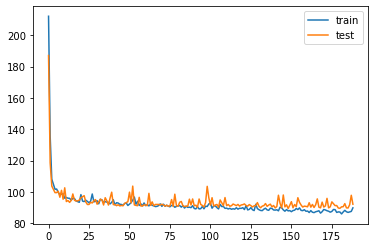

<IPython.core.display.Javascript object>

In [624]:
# plot history
plt.plot(history.history["loss"], label="train")
plt.plot(history.history["val_loss"], label="test")
plt.legend()
plt.show()

In [629]:
# model_mlp_lstm.load_weights("mlp_lstm.hdf5")
yhat = model_mlp_lstm.predict([X_test, X_test_LSTM])

<IPython.core.display.Javascript object>

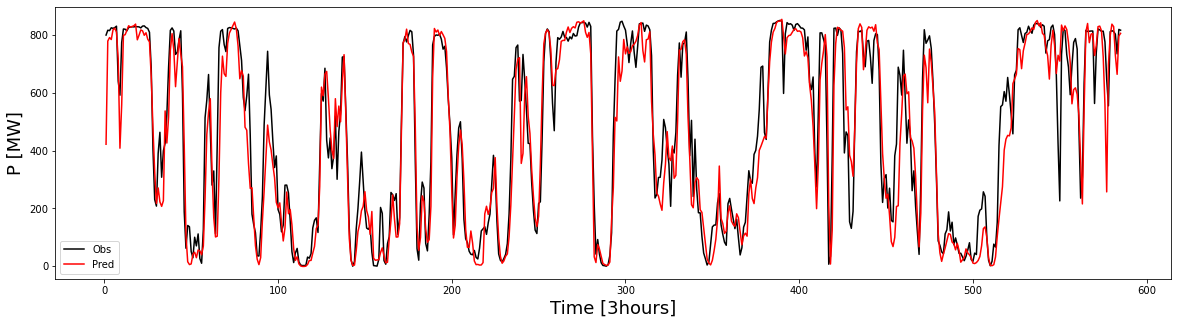

<IPython.core.display.Javascript object>

In [630]:
epochs = range(1, len(y_test_LSTM) + 1)

plt.figure(figsize=(20, 5))
plt.plot(epochs, np.squeeze(y_test_LSTM), "black", label="Obs")
# plt.plot(dataframe, "green", label="Naive")
plt.plot(epochs, yhat, "red", label="Pred")


# plt.plot(epochs, np.abs(DataFrame(power_test["nowcast_3hr"])), "blue", label="Nowcast")
# plt.plot(epochs, np.abs(DataFrame(power_test["dayahead_3hr"])), "pink", label="Dayahead")


plt.xlabel("Time [3hours]", fontsize=18)
plt.ylabel("P [MW]", fontsize=18)
# plt.title("Training and validation loss")
plt.legend()

In [631]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score


[
    mean_absolute_error(y_test, yhat),
    mean_squared_error(y_test, yhat, squared=False),
    mean_absolute_percentage_error(y_test, yhat),
    r2_score(y_test, yhat),
]

[72.82664579068222, 106.16306501371368, 40580051400904.086, 0.8775165374260219]

<IPython.core.display.Javascript object>

# CNN 1D

In [742]:
inputs = Input(shape=(train_X.shape[1], 1))
cnv_1 = layers.SeparableConv1D(16, 2, activation="relu", padding="same")(inputs)
cnv_2 = layers.BatchNormalization()(cnv_1)
cnv_3 = layers.AveragePooling1D(2)(cnv_2)
cnv_4 = layers.SeparableConv1D(32, 2, activation="relu", padding="same")(cnv_3)
cnv_5 = layers.BatchNormalization()(cnv_4)
cnv_6 = layers.AveragePooling1D(2)(cnv_5)
cnv_7 = layers.Flatten()(cnv_6)
cnv_8 = layers.Dense(16, activation="relu")(cnv_7)
cnv_9 = layers.Dense(32, activation="relu")(cnv_8)
# ccn  =layers.Dropout(0.35)(cnv_7)
cnv_10 = layers.Dense(64, activation="relu")(cnv_9)
cnv_out = layers.Dense(1)(cnv_10)


cnv_mdl = Model(inputs=inputs, outputs=cnv_out)

cnv_mdl.compile(loss="mae", optimizer=optimizers.Adam(lr=0.001))  #

# plot_model(model_t, to_file='model_plot.png', show_shapes=True, show_layer_names=True)
cnv_mdl.summary()

Model: "model_134"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_81 (InputLayer)        [(None, 123, 1)]          0         
_________________________________________________________________
separable_conv1d_16 (Separab (None, 123, 16)           34        
_________________________________________________________________
batch_normalization_16 (Batc (None, 123, 16)           64        
_________________________________________________________________
average_pooling1d_16 (Averag (None, 61, 16)            0         
_________________________________________________________________
separable_conv1d_17 (Separab (None, 61, 32)            576       
_________________________________________________________________
batch_normalization_17 (Batc (None, 61, 32)            128       
_________________________________________________________________
average_pooling1d_17 (Averag (None, 30, 32)            0 

<IPython.core.display.Javascript object>

In [743]:
from keras import backend as K
from keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger

# OUTPUT_DIR  = os.path.join(PATH,"bcheneka" )
StrOut = "cnv.csv"
csv_logger = CSVLogger(StrOut, append=False, separator=";")

STR = "cnv.hdf5"

F = STR
ch = ModelCheckpoint(F, monitor="val_loss", save_best_only=True, mode="min", verbose=0)
es = EarlyStopping(monitor="val_loss", mode="min", patience=40, verbose=0)



<IPython.core.display.Javascript object>

In [744]:
callbacks_list = [ch, es, csv_logger]

epochs = 2000
batch_size = 128


history = cnv_mdl.fit(
    x=[train_X],
    y=train_y,
    validation_data=([val_X], val_y),
    epochs=epochs,
    batch_size=batch_size,
    callbacks=callbacks_list,
    verbose=1,
)

Epoch 1/2000
37/37 [==============================] - 2s 57ms/step - loss: 268.6405 - val_loss: 272.7470
Epoch 2/2000
37/37 [==============================] - 2s 52ms/step - loss: 212.3779 - val_loss: 229.7030
Epoch 3/2000
37/37 [==============================] - 2s 53ms/step - loss: 108.9904 - val_loss: 223.2167
Epoch 4/2000
34/37 [==========================>...] - ETA: 0s - loss: 103.574

KeyboardInterrupt: 

<IPython.core.display.Javascript object>

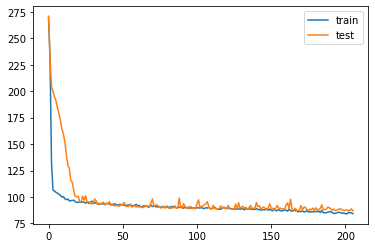

<IPython.core.display.Javascript object>

In [671]:
# plot history
plt.plot(history.history["loss"], label="train")
plt.plot(history.history["val_loss"], label="test")
plt.legend()
plt.show()

In [672]:
cnv_mdl.load_weights("cnv.hdf5")
yhat = cnv_mdl.predict(X_test)
yhat.shape

(585, 1)

<IPython.core.display.Javascript object>

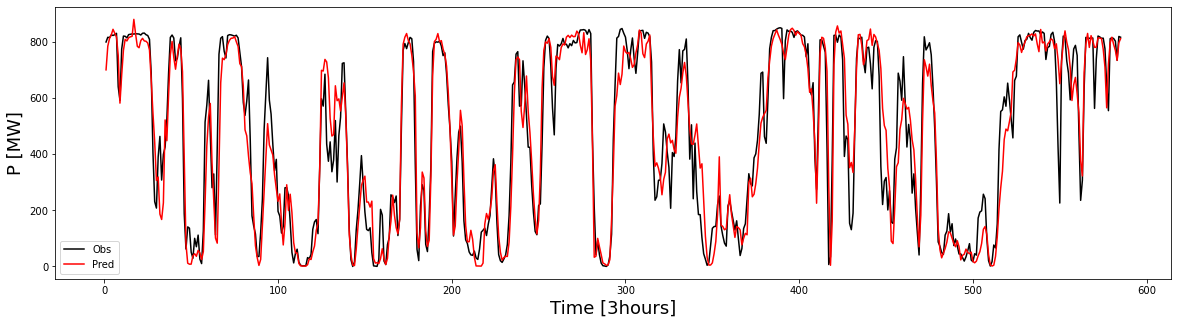

<IPython.core.display.Javascript object>

In [673]:
epochs = range(1, len(yhat) + 1)

plt.figure(figsize=(20, 5))
plt.plot(epochs, np.squeeze(y_test_LSTM), "black", label="Obs")
# plt.plot(dataframe, "green", label="Naive")
plt.plot(epochs, np.squeeze(yhat), "red", label="Pred")


# plt.plot(epochs, np.abs(DataFrame(power_test["nowcast_3hr"])), "blue", label="Nowcast")
# plt.plot(epochs, np.abs(DataFrame(power_test["dayahead_3hr"])), "pink", label="Dayahead")


plt.xlabel("Time [3hours]", fontsize=18)
plt.ylabel("P [MW]", fontsize=18)
# plt.title("Training and validation loss")
plt.legend()

In [674]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score


[
    mean_absolute_error(y_test, yhat),
    mean_squared_error(y_test, yhat, squared=False),
    mean_absolute_percentage_error(y_test, yhat),
    r2_score(y_test, yhat),
]

[68.86378870564376, 98.91227499033064, 66849572786337.56, 0.8936760898226832]

<IPython.core.display.Javascript object>

# MLP-CNN-LSTM

In [739]:
from keras.layers import Input, Dense, concatenate
import pydot

cnn_mlp_lstm = concatenate([mlp_out, cnv_10, lstm_output])
hh1 = Dense(32, activation="relu", kernel_initializer="he_uniform")(cnn_mlp_lstm)

hdrop1 = Dropout(0.1)(hh1)

hh2 = Dense(16, activation="relu", kernel_initializer="he_uniform")(hdrop1)
hdrop = Dropout(0.2)(hh2)

f_m = Dense(1)(cnn_mlp_lstm)
model_mlp_cnn_lstm = Model(inputs=[mlp_input, inputs, lstm_input], outputs=f_m)

plot_model(
    model_mlp_cnn_lstm,
    to_file="model_plot.png",
    show_shapes=True,
    show_layer_names=True,
)
model_mlp_cnn_lstm.compile(loss="mae", optimizer=optimizers.Adam(lr=0.0001))  #
model_mlp_cnn_lstm.summary()

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')
Model: "model_133"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_80 (InputLayer)           [(None, 123, 1)]     0                                            
__________________________________________________________________________________________________
separable_conv1d_14 (SeparableC (None, 123, 16)      34          input_80[0][0]                   
__________________________________________________________________________________________________
batch_normalization_14 (BatchNo (None, 123, 16)      64          separable_conv1d_14[0][0]        
__________________________________________________________________________________________________
input_71 (InputLayer)           [(None, 1

<IPython.core.display.Javascript object>

In [740]:
from keras import backend as K
from keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger

# OUTPUT_DIR  = os.path.join(PATH,"bcheneka" )
StrOut = "History_mlp_cnn_lstm.csv"
csv_logger = CSVLogger(StrOut, append=False, separator=";")

STR = "mlp_cnn_lstm.hdf5"

F = STR
ch = ModelCheckpoint(F, monitor="val_loss", save_best_only=True, mode="min", verbose=0)
es = EarlyStopping(monitor="val_loss", mode="min", patience=40, verbose=0)



<IPython.core.display.Javascript object>

In [741]:
callbacks_list = [ch, es, csv_logger]

epochs = 2000
batch_size = 128


history = model_mlp_cnn_lstm.fit(
    x=[train_X, train_X, X_train_LSTM],
    y=train_y,
    validation_data=([val_X, val_X, X_val_LSTM], val_y),
    epochs=epochs,
    batch_size=batch_size,
    callbacks=callbacks_list,
    verbose=1,
)

Epoch 1/2000
37/37 [==============================] - 5s 136ms/step - loss: 632.2304 - val_loss: 390.2191
Epoch 2/2000
37/37 [==============================] - 6s 161ms/step - loss: 339.3738 - val_loss: 240.2354
Epoch 3/2000
37/37 [==============================] - 6s 167ms/step - loss: 233.1426 - val_loss: 207.7838
Epoch 4/2000
 8/37 [=====>........................] - ETA: 4s - loss: 196.3432

KeyboardInterrupt: 

<IPython.core.display.Javascript object>

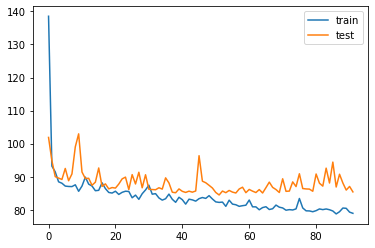

<IPython.core.display.Javascript object>

In [720]:
# plot history
plt.plot(history.history["loss"], label="train")
plt.plot(history.history["val_loss"], label="test")
plt.legend()
plt.show()

In [721]:
model_mlp_cnn_lstm.load_weights("mlp_cnn_lstm.hdf5")
yhat = model_mlp_cnn_lstm.predict([X_test, X_test, X_test_LSTM])

<IPython.core.display.Javascript object>

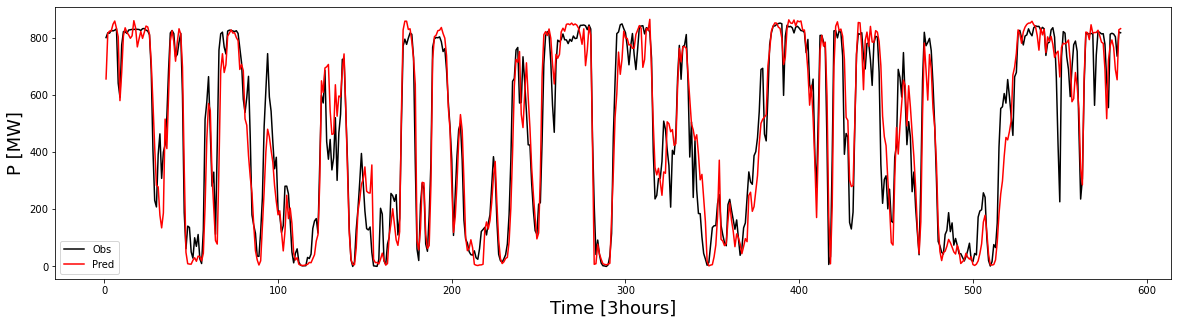

<IPython.core.display.Javascript object>

In [722]:
epochs = range(1, len(yhat) + 1)

plt.figure(figsize=(20, 5))
plt.plot(epochs, np.squeeze(y_test), "black", label="Obs")
# plt.plot(dataframe, "green", label="Naive")
plt.plot(epochs, yhat, "red", label="Pred")


# plt.plot(epochs, np.abs(DataFrame(power_test["nowcast_3hr"])), "blue", label="Nowcast")
# plt.plot(epochs, np.abs(DataFrame(power_test["dayahead_3hr"])), "pink", label="Dayahead")


plt.xlabel("Time [3hours]", fontsize=18)
plt.ylabel("P [MW]", fontsize=18)
# plt.title("Training and validation loss")
plt.legend()

In [723]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score


[
    mean_absolute_error(y_test, yhat),
    mean_squared_error(y_test, yhat, squared=False),
    mean_absolute_percentage_error(y_test, yhat),
    r2_score(y_test, yhat),
]

[70.0114411310647, 100.20329143915761, 97281501156637.81, 0.8908824684313507]

<IPython.core.display.Javascript object>

In [74]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [("var%d(t-%d)" % (j + 1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [("var%d(t)" % (j + 1)) for j in range(n_vars)]
        else:
            names += [("var%d(t+%d)" % (j + 1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

<IPython.core.display.Javascript object>

In [75]:
# ensure all data is float
x = np.concatenate(
    (Ut, power_r, y),
    axis=1,
)

values = x.astype("float32")
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# specify the number of lag hours
n_hours = 2
n_features = 123
# frame as supervised learning
reframed = series_to_supervised(values, n_hours, 1)
# print(values.shape)
reframed.head()

,var1(t-2),var2(t-2),var3(t-2),var4(t-2),var5(t-2),var6(t-2),var7(t-2),var8(t-2),var9(t-2),var10(t-2),...,var115(t),var116(t),var117(t),var118(t),var119(t),var120(t),var121(t),var122(t),var123(t),var124(t)
2,5.494879,5.589007,3.463438,3.692655,6.189830,6.278543,3.719893,3.583030,3.861217,3.100581,...,4.368352,3.472549,4.170048,3.810420,4.451539,4.769413,4.311775,4.884915,712.200012,0.833333
3,2.452468,2.605091,2.247421,2.372615,2.141612,2.294559,2.827048,2.178486,1.969568,1.198165,...,2.977415,2.474550,2.761340,2.865746,3.113150,3.362514,3.483676,3.843761,712.200012,57.357498
4,4.750421,6.601947,3.405892,3.211106,4.225825,5.747347,2.913366,3.113728,2.571478,2.463433,...,1.047521,2.672546,2.185154,2.402082,2.706677,2.553312,2.872107,2.830283,712.200012,189.150833
5,10.274570,12.178526,4.991593,5.330760,9.986716,11.811660,4.351241,4.374437,4.699149,4.658165,...,3.367863,3.156596,2.141121,2.602249,2.986051,1.641767,2.316312,1.854319,712.200012,341.959167
6,12.588534,12.394470,8.724018,9.091782,13.021693,12.024508,8.088393,8.140688,8.678307,8.191825,...,4.401545,5.164669,4.200488,4.723187,3.835635,4.152349,4.249471,3.335701,712.200012,491.623322


<IPython.core.display.Javascript object>

In [76]:
# split into train and test sets
values = reframed.values
splt_1 = 0.8
splt_2 = 0.9

n_train = int(splt_1 * len(values))
n_val = int(splt_2 * len(values))

train = values[:n_train, :]
val = values[n_train:n_val]
test = values[n_val:, :]
values.shape

(5846, 372)

<IPython.core.display.Javascript object>

In [77]:
# split into input and outputs
n_obs = n_hours * n_features
train_X, train_y = train[:, :n_obs], train[:, n_features]
val_X, val_y = val[:, :n_obs], val[:, n_features]
test_X, test_y = test[:, :n_obs], test[:, n_features]
print(train_X.shape, len(train_X), train_y.shape)


# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
val_X = val_X.reshape((val_X.shape[0], n_hours, n_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))
print(
    train_X.shape, train_y.shape, val_X.shape, val_y.shape, test_X.shape, test_y.shape
)

np.rint(test_y)

(4676, 246) 4676 (4676,)
(4676, 2, 123) (4676,) (585, 2, 123) (585,) (585, 2, 123) (585,)


array([532., 530., 801., 817., 816., 826., 824., 826., 831., 641., 592.,
       775., 822., 821., 815., 827., 828., 829., 829., 830., 829., 829.,
       825., 832., 832., 826., 824., 810., 688., 406., 231., 208., 391.,
       464., 308., 400., 426., 525., 690., 817., 825., 815., 733., 741.,
       784., 815., 598., 188.,  62., 141., 137.,  51.,  29., 100.,  70.,
       112.,  26.,  10., 127., 515., 575., 664., 474., 281., 330., 112.,
       422., 757., 814., 820., 767., 743., 823., 827., 826., 824., 822.,
       825., 815., 762., 712., 585., 539., 590., 665., 452., 180., 144.,
       116.,  36.,  35., 121., 240., 490., 617., 744., 593., 543., 435.,
       342., 382., 197., 180., 119., 143., 281., 281., 253., 158.,  50.,
        13.,  46.,  62.,  15.,   4.,   2.,   3.,   3.,  32.,  28.,  43.,
       133., 159., 167., 117., 351., 598., 572., 686., 436., 375., 444.,
       338., 380., 520., 301., 467., 532., 724., 726., 550., 364., 131.,
        23.,   0.,  16., 129., 200., 294., 395., 29

<IPython.core.display.Javascript object>

In [78]:
# design network
from tensorflow.keras.layers import Input, LSTM, Dense, Concatenate, Bidirectional
from keras.layers import TimeDistributed
from keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger
from keras import backend as K
from keras import layers, models, optimizers

lstm_input = Input(shape=(train_X.shape[1], train_X.shape[2]))
# lstm units
hidden1 = (LSTM(64))(lstm_input)
hidden2 = Dense(64, activation="relu", kernel_initializer="he_uniform")(hidden1)
hidden3 = Dense(128, activation="relu", kernel_initializer="he_uniform")(hidden2)
hidden4 = Dense(256, activation="relu", kernel_initializer="he_uniform")(hidden3)
lstm_output = Dense(1)(hidden4)
model_lstm = Model(inputs=[lstm_input], outputs=lstm_output)


# model = Sequential()
# model.add((LSTM(32, input_shape=(train_X.shape[1], train_X.shape[2]))))
# model.add(Dense(64))
# model.add(Dense(32))
# model.add(Dense(1))
model_lstm.compile(loss="mae", optimizer=optimizers.Adam(lr=0.0001))

<IPython.core.display.Javascript object>

In [79]:
from keras.layers import Input, Dense, concatenate
import pydot

con_out = concatenate([mlp_out, lstm_output])
hh1 = Dense(32, activation="relu", kernel_initializer="he_uniform")(con_out)

hdrop1 = Dropout(0.1)(hh1)

hh2 = Dense(16, activation="relu", kernel_initializer="he_uniform")(hdrop1)
hdrop = Dropout(0.2)(hh2)

f_m = Dense(1)(con_out)
model_mlp_lstm = Model(inputs=[mlp_input, lstm_input], outputs=f_m)

plot_model(
    model_mlp_lstm, to_file="model_plot.png", show_shapes=True, show_layer_names=True
)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


<IPython.core.display.Javascript object>

In [80]:
model_mlp_lstm.compile(loss="mae", optimizer=optimizers.Adam(lr=0.0001))  #
model_mlp_lstm.summary()

Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 123)]        0                                            
__________________________________________________________________________________________________
dense_28 (Dense)                (None, 32)           3968        input_5[0][0]                    
__________________________________________________________________________________________________
dense_29 (Dense)                (None, 32)           1056        dense_28[0][0]                   
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, 2, 123)]     0                                            
____________________________________________________________________________________________

<IPython.core.display.Javascript object>

In [81]:
[train_X.shape, train_X_l.shape, val_X.shape, val_X_l.shape]

[(4676, 2, 123), (4676, 123), (585, 2, 123), (585, 123)]

<IPython.core.display.Javascript object>

In [82]:
from keras import backend as K
from keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger

# OUTPUT_DIR  = os.path.join(PATH,"bcheneka" )
StrOut = "History_mlp_lstm.csv"
csv_logger = CSVLogger(StrOut, append=False, separator=";")

STR = "mlp_lstm.hdf5"

F = STR
ch = ModelCheckpoint(F, monitor="val_loss", save_best_only=True, mode="min", verbose=0)
es = EarlyStopping(monitor="val_loss", mode="min", patience=40, verbose=0)



<IPython.core.display.Javascript object>

In [83]:
callbacks_list = [ch, es, csv_logger]

epochs = 2000
batch_size = 256


history = model_mlp_lstm.fit(
    x=[train_X_l, train_X],
    y=train_y,
    validation_data=([val_X_l, val_X], val_y),
    epochs=epochs,
    batch_size=batch_size,
    callbacks=callbacks_list,
    verbose=1,
)

Epoch 1/2000
 1/74 [..............................] - ETA: 5s - loss: 306.8091

C:\Users\bcheneka\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\data\ops\dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


74/74 [==============================] - 2s 31ms/step - loss: 237.1200 - val_loss: 232.6171
Epoch 2/2000
74/74 [==============================] - 2s 29ms/step - loss: 200.4665 - val_loss: 222.3536
Epoch 3/2000
74/74 [==============================] - 2s 29ms/step - loss: 183.8647 - val_loss: 187.1731
Epoch 4/2000
74/74 [==============================] - 2s 29ms/step - loss: 144.7457 - val_loss: 128.9012
Epoch 5/2000
74/74 [==============================] - 2s 32ms/step - loss: 91.0451 - val_loss: 85.8224
Epoch 6/2000
74/74 [==============================] - 3s 34ms/step - loss: 61.6696 - val_loss: 70.7783
Epoch 7/2000
74/74 [==============================] - 3s 36ms/step - loss: 53.5941 - val_loss: 62.6230
Epoch 8/2000
74/74 [==============================] - 4s 48ms/step - loss: 48.2181 - val_loss: 60.0164
Epoch 9/2000
74/74 [==============================] - 3s 38ms/step - loss: 44.4867 - val_loss: 61.8875
Epoch 10/2000
74/74 [==============================] - 2s 31ms/step - loss: 41

74/74 [==============================] - 2s 28ms/step - loss: 4.2415 - val_loss: 6.6663
Epoch 160/2000
74/74 [==============================] - 2s 29ms/step - loss: 4.2037 - val_loss: 6.8576
Epoch 161/2000
74/74 [==============================] - 2s 28ms/step - loss: 4.3914 - val_loss: 8.4975
Epoch 162/2000
74/74 [==============================] - 2s 29ms/step - loss: 4.2006 - val_loss: 7.0881
Epoch 163/2000
74/74 [==============================] - 2s 28ms/step - loss: 4.2563 - val_loss: 9.7976
Epoch 164/2000
74/74 [==============================] - 2s 27ms/step - loss: 4.9359 - val_loss: 6.4663
Epoch 165/2000
74/74 [==============================] - 2s 28ms/step - loss: 3.7095 - val_loss: 6.8298
Epoch 166/2000
74/74 [==============================] - 2s 29ms/step - loss: 4.0613 - val_loss: 6.4929
Epoch 167/2000
74/74 [==============================] - 2s 29ms/step - loss: 4.0819 - val_loss: 6.5496
Epoch 168/2000
74/74 [==============================] - 2s 32ms/step - loss: 3.9107 - va

74/74 [==============================] - 2s 29ms/step - loss: 2.8592 - val_loss: 4.6693
Epoch 318/2000
74/74 [==============================] - 2s 29ms/step - loss: 2.8570 - val_loss: 4.2110
Epoch 319/2000
74/74 [==============================] - 2s 29ms/step - loss: 2.5806 - val_loss: 4.3059
Epoch 320/2000
74/74 [==============================] - 2s 31ms/step - loss: 2.4853 - val_loss: 4.7607
Epoch 321/2000
74/74 [==============================] - 2s 29ms/step - loss: 2.6724 - val_loss: 5.1836
Epoch 322/2000
74/74 [==============================] - 2s 29ms/step - loss: 2.8755 - val_loss: 5.7827
Epoch 323/2000
74/74 [==============================] - 2s 29ms/step - loss: 3.0709 - val_loss: 4.8287
Epoch 324/2000
74/74 [==============================] - 2s 29ms/step - loss: 2.6908 - val_loss: 4.2676
Epoch 325/2000
74/74 [==============================] - 2s 29ms/step - loss: 2.5649 - val_loss: 4.2066
Epoch 326/2000
74/74 [==============================] - 2s 29ms/step - loss: 2.5024 - va

74/74 [==============================] - 2s 29ms/step - loss: 1.8571 - val_loss: 4.2499
Epoch 476/2000
74/74 [==============================] - 2s 28ms/step - loss: 2.2354 - val_loss: 3.6095
Epoch 477/2000
74/74 [==============================] - 2s 29ms/step - loss: 1.7202 - val_loss: 3.5749
Epoch 478/2000
74/74 [==============================] - 2s 27ms/step - loss: 1.7542 - val_loss: 3.6244
Epoch 479/2000
74/74 [==============================] - 2s 27ms/step - loss: 1.8738 - val_loss: 3.5354
Epoch 480/2000
74/74 [==============================] - 2s 30ms/step - loss: 1.9280 - val_loss: 3.5315
Epoch 481/2000
74/74 [==============================] - 2s 27ms/step - loss: 1.7611 - val_loss: 5.2198
Epoch 482/2000
74/74 [==============================] - 2s 29ms/step - loss: 3.9433 - val_loss: 3.7069
Epoch 483/2000
74/74 [==============================] - 2s 29ms/step - loss: 2.0335 - val_loss: 3.6781
Epoch 484/2000
74/74 [==============================] - 2s 31ms/step - loss: 2.5937 - va

<IPython.core.display.Javascript object>

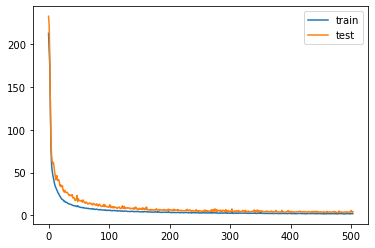

<IPython.core.display.Javascript object>

In [85]:
# make a prediction


model_mlp_lstm.load_weights("mlp_lstm.hdf5")
yhat = model_mlp_lstm.predict([test_X_l, test_X])
yhat_train = model_mlp_lstm.predict([train_X_l, train_X])
yhat_val = model_mlp_lstm.predict([val_X_l, val_X])

<IPython.core.display.Javascript object>

In [86]:
from sklearn.metrics import mean_squared_error
from math import sqrt

[
    sqrt(mean_squared_error(train_y, yhat_train)),
    sqrt(mean_squared_error(val_y, yhat_val)),
    sqrt(mean_squared_error(test_y, yhat)),
]

[2.656117424741861, 6.777213165168469, 15.549159693935232]

<IPython.core.display.Javascript object>

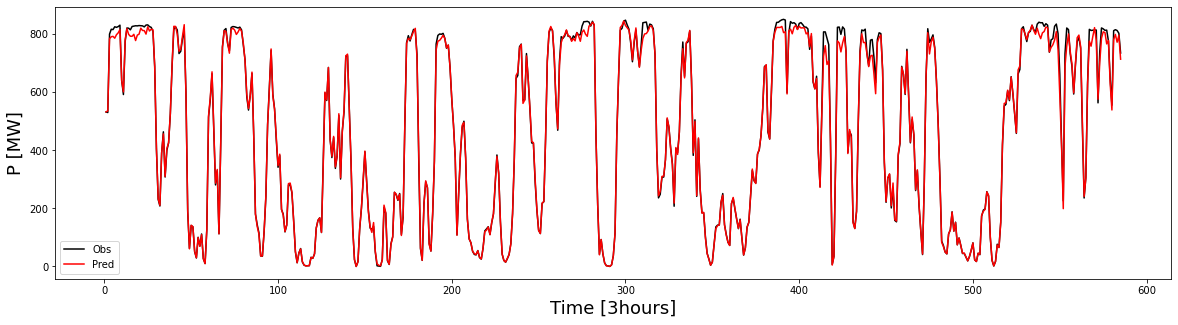

<IPython.core.display.Javascript object>

In [87]:
epochs = range(1, len(test_y) + 1)

plt.figure(figsize=(20, 5))
plt.plot(epochs, test_y, "black", label="Obs")
# plt.plot(dataframe, "green", label="Naive")
plt.plot(epochs, yhat, "red", label="Pred")


# plt.plot(epochs, np.abs(DataFrame(power_test["nowcast_3hr"])), "blue", label="Nowcast")
# plt.plot(epochs, np.abs(DataFrame(power_test["dayahead_3hr"])), "pink", label="Dayahead")


plt.xlabel("Time [3hours]", fontsize=18)
plt.ylabel("P [MW]", fontsize=18)
# plt.title("Training and validation loss")
plt.legend()

In [88]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score


[
    mean_absolute_error(test_y, yhat),
    mean_squared_error(test_y, yhat, squared=False),
    mean_absolute_percentage_error(test_y, yhat),
    r2_score(test_y, yhat),
]

[8.424299, 15.54916, 1046013000000.0, 0.9973608603669237]

<IPython.core.display.Javascript object>

In [89]:
[
    mean_absolute_error(val_y, yhat_val),
    mean_squared_error(val_y, yhat_val, squared=False),
    mean_absolute_percentage_error(val_y, yhat_val),
    r2_score(val_y, yhat_val),
]

[3.3788724, 6.777213, 108009120000000.0, 0.9994445029864806]

<IPython.core.display.Javascript object>

In [90]:
[
    mean_absolute_error(train_y, yhat_train),
    mean_squared_error(train_y, yhat_train, squared=False),
    mean_absolute_percentage_error(train_y, yhat_train),
    r2_score(train_y, yhat_train),
]

[1.5968333, 2.6561174, 17901044000000.0, 0.999874472940308]

<IPython.core.display.Javascript object>

In [27]:
import pandas as pd
from pathlib import Path
import os
from os.path import isfile, join
from datetime import date
import csv
import numpy as np
import matplotlib.pyplot as plt

<IPython.core.display.Javascript object>

In [4]:
#assign working directory to variable
file_path=os.getcwd()
#setting path for data folder
DATA_PATH = Path.cwd().parent /"Belgian_power_3hr"
print(DATA_PATH)


/home/bcheneka/data_climate/ramp_forecasts/Belgian_power_3hr


<IPython.core.display.Javascript object>

In [6]:
power = pd.read_csv(DATA_PATH / "Belgian_power_2016_2017_3hrly.csv")

<IPython.core.display.Javascript object>

In [7]:
power["TIMESTAMP"] = pd.to_datetime(power["TIMESTAMP"])

<IPython.core.display.Javascript object>

In [8]:
date_from = pd.Timestamp(date(2016,1,1))
date_to = pd.Timestamp(date(2018,1,1))


<IPython.core.display.Javascript object>

In [9]:
# df is defined in the previous example

power = power[(power["TIMESTAMP"] >= date_from) & (power["TIMESTAMP"] <= date_to)]

# power[240 : len(power)]
y = power["Obs_3hr"].values.reshape(len(power), 1)
mask = np.isnan(y)
y[mask] = np.interp(np.flatnonzero(mask), np.flatnonzero(~mask), y[~mask])
# y = y[:2928]
# y.shape
power.shape

(5848, 5)

<IPython.core.display.Javascript object>

In [10]:
splt_1 = 0.8
splt_2 = 0.9

n = len(y)
y_train = y[0 : int(n * splt_1)]
y_val = y[int(n * splt_1) : int(n * splt_2)]
y_test = y[int(n * splt_2) :]

y_train_Ens = y[0 : int(n * splt_2)]

[y_train.shape, y_val.shape]

power_test = power[int(n * splt_2) :]
power_test.head()


,TIMESTAMP,Obs_3hr,rated_3hr,nowcast_3hr,dayahead_3hr
5263,2017-10-19 21:00:00,800.513333,877.2,745.137500,724.236667
5264,2017-10-20 00:00:00,817.269167,877.2,805.205833,783.487500
5265,2017-10-20 03:00:00,815.985000,877.2,815.110000,772.664167
5266,2017-10-20 06:00:00,825.781667,877.2,834.470000,811.345000
5267,2017-10-20 09:00:00,823.796667,877.2,826.530000,828.126667


<IPython.core.display.Javascript object>

In [11]:
from prophet import Prophet

<IPython.core.display.Javascript object>

In [12]:
from netCDF4 import Dataset

fn = "/home/bcheneka/data_climate/ramp_forecasts/gfs_4_2016_2017.nc"
ds = Dataset(fn, mode="r")

lons = ds.variables["lon"][:]
lats = ds.variables["lat"][:]
U = ds.variables["U"]
[U.shape, lons.shape, lats.shape]

[(5848, 1, 25, 41), (41,), (25,)]

<IPython.core.display.Javascript object>

In [13]:
import nctoolkit as nc

lat_bnds, lon_bnds = [50.5, 54], [0, 5]

lat_inds = np.where((lats > lat_bnds[0]) & (lats < lat_bnds[1]))[0]
lon_inds = np.where((lons > lon_bnds[0]) & (lons < lon_bnds[1]))[0]

U = np.squeeze(ds.variables["U"][:, :, lat_inds, lon_inds])


lats.shape

nctoolkit is using CDO version 1.9.3


(25,)

<IPython.core.display.Javascript object>

In [14]:
x = U.reshape(len(U), U.shape[1], U.shape[2], 1)
# X_test = x[224:248]
# X = x[0:224]

X_train = x[0 : int(n * splt_1)]
X_val = x[int(n * splt_1) : int(n * splt_2)]
X_test = x[int(n * splt_2) :]

X_train_Ens = x[0 : int(n * splt_2)]


np.squeeze(X_train[1, :, :]).shape
[X_train.shape, X_val.shape]

[(4678, 6, 9, 1), (585, 6, 9, 1)]

<IPython.core.display.Javascript object>

In [15]:
import os
import matplotlib.pyplot as plt
from netCDF4 import Dataset as netcdf_dataset
import numpy as np

from cartopy import config
import cartopy.crs as ccrs


dataset = netcdf_dataset(fn)
sst = np.squeeze(dataset.variables["U"][0, :, :])
lats = dataset.variables["lat"][:]
lons = dataset.variables["lon"][:]
sst.shape

(25, 41)

<IPython.core.display.Javascript object>

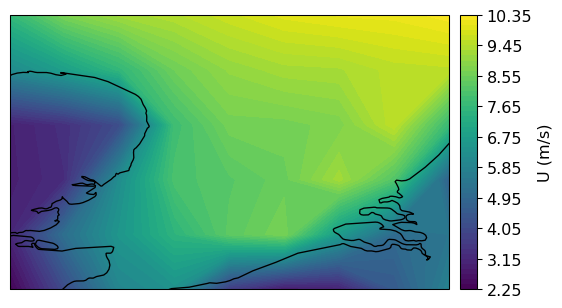

<IPython.core.display.Javascript object>

In [16]:
cmsize = [15, 10]
dpi_display = 96  # DPI of your screen
fig = plt.figure(figsize=[x / 2.54 for x in cmsize], dpi=dpi_display)
ax = plt.axes(projection=ccrs.PlateCarree())

plot = plt.contourf(
    lons[lon_inds],
    lats[lat_inds],
    np.squeeze(U[1, :, :]),
    60,
    transform=ccrs.PlateCarree(),
)

# Add a colorbar for the filled contour.
# add colorbar
axpos = ax.get_position()
# add colorbar
axpos = ax.get_position()
cbar_ax = fig.add_axes([axpos.x1 + 0.02, axpos.y0, 0.03, axpos.height])
cbar = fig.colorbar(plot, cax=cbar_ax)
cbar.ax.tick_params(labelsize=12)
cbar.set_label("U (m/s)", fontsize=12)

# cbar_ax = plt.add_axes([axpos.x1 + 0, axpos.y0, 0.03, axpos.height])
# cbar = plt.colorbar(orientation="horizontal")
# cbar.set_label("U(m/s)", fontsize=12)
ax.coastlines()

plt.show()

# CNN

In [17]:
WIDTH = X_train.shape[1] #U.shape[1]
HEIGHT = X_train.shape[2] #U.shape[2]

from keras import layers, models, optimizers
from keras.utils.vis_utils import plot_model
from keras import metrics
import pydot

from numpy.random import seed

seed(1)


import tensorflow

tensorflow.random.set_seed(1)

from tensorflow.keras.layers import Input, LSTM, Dense, Concatenate
from tensorflow.keras.models import Model


from keras import layers, models, optimizers
from keras import metrics
from keras.layers import Input, Dense, Flatten, Reshape, Dropout, SpatialDropout1D
from keras.layers.merge import average




# inputs = Input(shape = (X_train.shape[1],X_train.shape[2],1))
# cnv_1 = layers.SeparableConv2D(16, 2, activation = 'relu', padding = "same")(inputs)
# cnv_2 = layers.BatchNormalization()(cnv_1)
# cnv_3 = layers.AveragePooling2D(2)(cnv_2)
# cnv_4 = layers.SeparableConv2D(32, 2, activation = 'relu', padding = "same")(cnv_3)
# cnv_5 = layers.BatchNormalization()(cnv_4)
# cnv_6 = layers.AveragePooling2D(2)(cnv_5)
# cnv_7 = layers.Flatten()(cnv_6)
# cnv_8 = layers.Dense(16, activation = 'relu')(cnv_7)
# cnv_9 = layers.Dense(32, activation = 'relu')(cnv_8)
# cnv_10 = layers.Dense(64, activation = 'relu')(cnv_9)
# cnv_out = layers.Dense(1, activation = 'relu')(cnv_10)



# cnv_mdl = Model(inputs = inputs, outputs = cnv_out)

# cnv_mdl.summary()

#plot_model(model_t, to_file='model_plot.png', show_shapes=True, show_layer_names=True)


Using TensorFlow backend.


<IPython.core.display.Javascript object>

# MLP

In [18]:
power_r = power["rated_3hr"].values.reshape(power.shape[0], 1)

mask = np.isnan(power_r)
power_r[mask] = np.interp(np.flatnonzero(mask), np.flatnonzero(~mask), power_r[~mask])


mask = np.isnan(y)
y[mask] = np.interp(np.flatnonzero(mask), np.flatnonzero(~mask), y[~mask])


mask = np.isnan(power_r)
power_r[mask] = np.interp(np.flatnonzero(mask), np.flatnonzero(~mask), power_r[~mask])


<IPython.core.display.Javascript object>

In [19]:
def daterange(start_date, end_date):
    delta = timedelta(hours=3)
    while start_date < end_date:
        yield start_date
        start_date += delta


from datetime import datetime, timedelta

start_date = datetime(2016, 1, 1, 00, 00)
end_date = datetime(2016, 12, 31, 23, 00)

timestamp_g = []

for single_date in daterange(start_date, end_date):
    tas = single_date.strftime("%Y-%m-%d %H:%M:%S")
    timestamp_g.append(tas)


from pandas import DataFrame

times = DataFrame(timestamp_g, columns=["Times"])
times.head()


import datetime


times["Times"] = pd.to_datetime(times["Times"])
timestamp_s = power["TIMESTAMP"].map(datetime.datetime.timestamp)


day = 3 * 60 * 60
year = (365.2425) * day

power["Day sin"] = np.sin(timestamp_s * (2 * np.pi / day))
power["Day cos"] = np.cos(timestamp_s * (2 * np.pi / day))
power["Year sin"] = np.sin(timestamp_s * (2 * np.pi / year))
power["Year cos"] = np.cos(timestamp_s * (2 * np.pi / year))
# power["Day sin"]

Ys = power["Year sin"]
Ys.shape
# power["Year cos"].reshape(power["Year cos"], power["Year cos"][0], 1) ,
#       power["Year sin"].values.reshape(power.shape[0], 1),
#      power["Year cos"].values.reshape(power.shape[0], 1),
power_r.min()

712.2

<IPython.core.display.Javascript object>

# MLP Predictors

In [20]:
# import matlab.engine

# eng = matlab.engine.start_matlab()

<IPython.core.display.Javascript object>

In [21]:
Up = np.squeeze(ds.variables["U"])

Up.shape

(5848, 25, 41)

<IPython.core.display.Javascript object>

In [22]:
# y_p = y[0 : int(n * splt_1)]
# X_p = Up[0 : int(n * splt_1)]
# y_p = matlab.double(y_p.tolist())
# X_p = matlab.double(X_p.tolist())
# lon = matlab.double(lons.tolist())
# lat = matlab.double(lats.tolist())


fn = "/home/bcheneka/data_climate/ramp_forecasts/U_2016_2017_predictor_gfs.nc"
ds = Dataset(fn, mode="r")

# lons = ds.variables["lon"][:]
# lats = ds.variables["lat"][:]
Us = ds.variables["U_2016"]
Ut = np.transpose(Us)

<IPython.core.display.Javascript object>

In [23]:
# Ut = U.reshape(len(U), U.shape[1] * U.shape[2])
Ut.shape

(5848, 122)

<IPython.core.display.Javascript object>

In [24]:
# U = U.reshape(U.shape[0], U.shape[1] * U.shape[2])
U.shape

(5848, 6, 9)

<IPython.core.display.Javascript object>

In [25]:
x = np.concatenate(
    (Ut, power_r),
    axis=1,
)
n = len(x)
# X_trainl = x[0 : int(n * splt_1)]

# X_vall = x[int(n * splt_1) : int(n * splt_2)]


X_testl = x[int(n * splt_2) :]

X_trainl_Ens = x[0 : int(n * splt_2)]
y_train_Ens = y[0 : int(n * splt_2)]

[X_trainl_Ens.shape, y_train_Ens.shape]

[(5263, 123), (5263, 1)]

<IPython.core.display.Javascript object>

In [26]:
# https://stackoverflow.com/questions/29438265/stratified-train-test-split-in-scikit-learn

from sklearn.model_selection import train_test_split

# 5 bins may be too few for larger datasets.
bins = np.linspace(start=np.amin(y_train_Ens), stop=np.amax(y_train_Ens), num=60)

y_binned = np.digitize(y_train_Ens, bins, right=True)

X_trainl, X_vall, y_train, y_val = train_test_split(
    X_trainl_Ens, y_train_Ens, test_size=0.10, stratify=y_binned
)
[X_trainl.shape, X_vall.shape, y_train.shape, y_val.shape]


[(4736, 123), (527, 123), (4736, 1), (527, 1)]

<IPython.core.display.Javascript object>

In [27]:
mlp_input = Input(shape=X_trainl.shape[1])

hidden1 = Dense(32, activation="relu", kernel_initializer="he_uniform")(mlp_input)
hidden2 = Dense(32, activation="relu", kernel_initializer="he_uniform")(hidden1)
hidden3 = Dense(64, activation="relu", kernel_initializer="he_uniform")(hidden2)
hidden4 = Dense(128, activation="relu", kernel_initializer="he_uniform")(hidden3)
# hidden5 = layers.Dropout(0.05)(hidden4)
hidden6 = Dense(256, activation="relu", kernel_initializer="he_uniform")(hidden4)
hidden7 = layers.Dropout(0.3)(hidden6)
hidden8 = Dense(32, activation="relu", kernel_initializer="he_uniform")(hidden7)


mlp_out = Dense(1)(hidden8)
model_ap = Model(inputs=mlp_input, outputs=mlp_out)
model_ap.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 123)]             0         
_________________________________________________________________
dense (Dense)                (None, 32)                3968      
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_2 (Dense)              (None, 64)                2112      
_________________________________________________________________
dense_3 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_4 (Dense)              (None, 256)               33024     
_________________________________________________________________
dropout (Dropout)            (None, 256)              

<IPython.core.display.Javascript object>

#  MLP

In [28]:
# con_out = average([mlp_out, cnv_out])
# con_cnn_mlp = Model(inputs=[inputs, mlp_input], outputs=con_out)
# plot_model(con_cnn_mlp, to_file="model.png", show_shapes=True, show_layer_names=True)

<IPython.core.display.Javascript object>

In [29]:
epochs = 30


learning_rate = 0.1
decay_rate = learning_rate / epochs
momentum = 0.8
sgd = optimizers.SGD(
    lr=learning_rate, momentum=momentum, decay=decay_rate, nesterov=False
)
model_ap.compile(loss="mae", optimizer=optimizers.Adam(lr=0.0001))
# con_cnn_mlp.compile( loss="mae", optimizer=optimizers.Adam(
#        lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0 ),)
# optimizer=sgd)  # optimizers.SGD(lr=0.001))
model_ap.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 123)]             0         
_________________________________________________________________
dense (Dense)                (None, 32)                3968      
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_2 (Dense)              (None, 64)                2112      
_________________________________________________________________
dense_3 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_4 (Dense)              (None, 256)               33024     
_________________________________________________________________
dropout (Dropout)            (None, 256)              

<IPython.core.display.Javascript object>

In [30]:
# def train(x):
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Activation

from tensorflow.keras.callbacks import LearningRateScheduler
import math

from keras import backend as K
from keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger

import os

# import os

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import CSVLogger
from tensorflow.keras.callbacks import ModelCheckpoint

# os.environ["MK_NUM_THREADS"] = "20"
# os.environ["GOTO_NUM_THREADS"] = "20"
# os.environ["OMP_NUM_THREADS"] = "20"
# os.environ["openmp"] = "True"


# tf.config.threading.set_intra_op_parallelism_threads(20)


# model_best = tuner.get_best_models(num_models=1)[0]

config = tf.compat.v1.ConfigProto(
    intra_op_parallelism_threads=20,
    inter_op_parallelism_threads=20,
    allow_soft_placement=True,
)
session = tf.compat.v1.Session(config=config)
tf.compat.v1.keras.backend.set_session(session)

# OUTPUT_DIR  = os.path.join(PATH,"bcheneka" )
StrOut = "History_mlp.csv"
csv_logger = CSVLogger(StrOut, append=False, separator=";")

STR = "mlp.hdf5"

F = STR
ch = ModelCheckpoint(F, monitor="val_loss", save_best_only=True, mode="min", verbose=0)
es = EarlyStopping(monitor="val_loss", mode="min", patience=40, verbose=0)

import keras

# define step decay function
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.lr = []

    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get("loss"))
        self.lr.append(step_decay(len(self.losses)))
        print("lr:", step_decay(len(self.losses)))


def step_decay(epoch):
    initial_lrate = 0.001
    drop = 0.1
    epochs_drop = 5.0
    lrate = initial_lrate * math.pow(drop, math.floor((epoch) / epochs_drop))
    return lrate


# learning schedule callback
loss_history = LossHistory()
lrate = LearningRateScheduler(step_decay)


callbacks_list = [ch, es, csv_logger]

epochs = 1000

nb_train_samples = len(X_train)
nb_validation_samples = len(X_val)

batch_size = 128


history = model_ap.fit(
    x=[X_trainl],
    y=y_train,
    validation_data=([X_vall], y_val),
    epochs=epochs,
    batch_size=batch_size,
    callbacks=callbacks_list,
    verbose=1,
)
# K.clear_session()
# tf.compat.v1.reset_default_graph()
# tf.keras.backend.clear_session()

# print(OUTPUT_DIR)

Epoch 1/1000
37/37 [==============================] - 1s 31ms/step - loss: 214.7336 - val_loss: 202.9154
Epoch 2/1000
37/37 [==============================] - 1s 16ms/step - loss: 205.2918 - val_loss: 198.6668
Epoch 3/1000
37/37 [==============================] - 1s 15ms/step - loss: 197.9391 - val_loss: 192.1402
Epoch 4/1000
37/37 [==============================] - 1s 14ms/step - loss: 186.0434 - val_loss: 177.6365
Epoch 5/1000
37/37 [==============================] - 0s 13ms/step - loss: 165.3873 - val_loss: 144.5592
Epoch 6/1000
37/37 [==============================] - 1s 14ms/step - loss: 131.6761 - val_loss: 117.6842
Epoch 7/1000
37/37 [==============================] - 1s 14ms/step - loss: 118.9326 - val_loss: 113.6113
Epoch 8/1000
37/37 [==============================] - 1s 15ms/step - loss: 117.1934 - val_loss: 112.0820
Epoch 9/1000
37/37 [==============================] - 1s 15ms/step - loss: 115.4901 - val_loss: 111.4882
Epoch 10/1000
37/37 [==============================] - 

Epoch 156/1000
37/37 [==============================] - 0s 11ms/step - loss: 94.6430 - val_loss: 99.6729
Epoch 157/1000
37/37 [==============================] - 0s 12ms/step - loss: 95.3473 - val_loss: 98.9059
Epoch 158/1000
37/37 [==============================] - 0s 12ms/step - loss: 94.2934 - val_loss: 99.9284
Epoch 159/1000
37/37 [==============================] - 1s 14ms/step - loss: 94.8885 - val_loss: 102.9727
Epoch 160/1000
37/37 [==============================] - 0s 12ms/step - loss: 95.5388 - val_loss: 100.3332
Epoch 161/1000
37/37 [==============================] - 0s 13ms/step - loss: 95.5511 - val_loss: 100.7830
Epoch 162/1000
37/37 [==============================] - 0s 11ms/step - loss: 95.6904 - val_loss: 99.5510
Epoch 163/1000
37/37 [==============================] - 0s 12ms/step - loss: 95.7040 - val_loss: 98.6790
Epoch 164/1000
37/37 [==============================] - 0s 10ms/step - loss: 94.7604 - val_loss: 101.4392
Epoch 165/1000
37/37 [=============================

Epoch 234/1000
37/37 [==============================] - 0s 10ms/step - loss: 93.3789 - val_loss: 100.9378
Epoch 235/1000
37/37 [==============================] - 0s 9ms/step - loss: 93.9442 - val_loss: 98.3549
Epoch 236/1000
37/37 [==============================] - 0s 13ms/step - loss: 93.5454 - val_loss: 97.5757
Epoch 237/1000
37/37 [==============================] - 0s 10ms/step - loss: 93.9009 - val_loss: 100.3903
Epoch 238/1000
37/37 [==============================] - 0s 10ms/step - loss: 94.2638 - val_loss: 97.7328
Epoch 239/1000
37/37 [==============================] - 0s 9ms/step - loss: 94.3533 - val_loss: 98.0965
Epoch 240/1000
37/37 [==============================] - 0s 10ms/step - loss: 92.8928 - val_loss: 98.5590
Epoch 241/1000
37/37 [==============================] - 0s 12ms/step - loss: 93.4794 - val_loss: 97.7828
Epoch 242/1000
37/37 [==============================] - 0s 11ms/step - loss: 93.3402 - val_loss: 98.5228
Epoch 243/1000
37/37 [==============================] -

37/37 [==============================] - 0s 9ms/step - loss: 92.9045 - val_loss: 97.5056
Epoch 313/1000
37/37 [==============================] - 0s 10ms/step - loss: 92.7020 - val_loss: 99.1802
Epoch 314/1000
37/37 [==============================] - 0s 9ms/step - loss: 92.5191 - val_loss: 101.9396
Epoch 315/1000
37/37 [==============================] - 0s 13ms/step - loss: 92.6923 - val_loss: 97.0134
Epoch 316/1000
37/37 [==============================] - 0s 10ms/step - loss: 92.2141 - val_loss: 99.3310
Epoch 317/1000
37/37 [==============================] - 0s 12ms/step - loss: 93.1025 - val_loss: 96.9670
Epoch 318/1000
37/37 [==============================] - 0s 9ms/step - loss: 92.4351 - val_loss: 98.4295
Epoch 319/1000
37/37 [==============================] - 0s 10ms/step - loss: 92.1316 - val_loss: 99.6340
Epoch 320/1000
37/37 [==============================] - 0s 10ms/step - loss: 93.0414 - val_loss: 98.6870
Epoch 321/1000
37/37 [==============================] - 0s 10ms/step - l

37/37 [==============================] - 1s 25ms/step - loss: 90.9856 - val_loss: 96.1682
Epoch 469/1000
37/37 [==============================] - 0s 10ms/step - loss: 91.2165 - val_loss: 98.5738
Epoch 470/1000
37/37 [==============================] - 0s 9ms/step - loss: 90.6643 - val_loss: 96.8218
Epoch 471/1000
37/37 [==============================] - 0s 10ms/step - loss: 91.5748 - val_loss: 98.9061
Epoch 472/1000
37/37 [==============================] - 0s 11ms/step - loss: 91.8855 - val_loss: 96.4713
Epoch 473/1000
37/37 [==============================] - 0s 10ms/step - loss: 90.6922 - val_loss: 96.6821
Epoch 474/1000
37/37 [==============================] - 0s 10ms/step - loss: 90.8906 - val_loss: 98.6667
Epoch 475/1000
37/37 [==============================] - 0s 10ms/step - loss: 90.6057 - val_loss: 96.9733
Epoch 476/1000
37/37 [==============================] - 0s 10ms/step - loss: 91.1504 - val_loss: 98.7582
Epoch 477/1000
37/37 [==============================] - 0s 10ms/step - 

<IPython.core.display.Javascript object>

In [31]:
[X_trainl.shape, X_vall.shape]

[(4736, 123), (527, 123)]

<IPython.core.display.Javascript object>

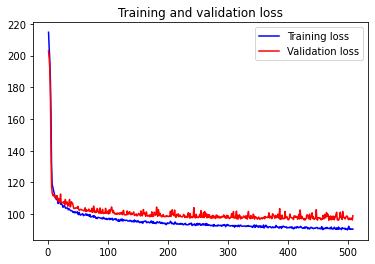

<IPython.core.display.Javascript object>

In [32]:
# # acc = history.history['loss']
# # val_acc = history.history['val_mean_squared_error']
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(loss) + 1)
# # plt.plot(epochs, acc, 'blue', label='Training acc')
# # plt.plot(epochs, val_acc, 'red', label='Validation acc')
# # plt.title('Training and validation accuracy')
# # plt.legend()
plt.figure()
plt.plot(epochs, loss, "blue", label="Training loss")
plt.plot(epochs, val_loss, "red", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.savefig("mlp_learning_curve.png", bbox_inches="tight")
# , y_train.size, val.size(), y_val.size()]

In [33]:
[X_train.shape, X_trainl.shape, X_val.shape, X_vall.shape, X_testl.shape]
[
    y_train.shape,
    y_val.shape,
]

[(4736, 1), (527, 1)]

<IPython.core.display.Javascript object>

In [34]:
model_ap.load_weights("mlp.hdf5")
# batch_size = 1
# # # model.summary
predTr = model_ap.predict([X_trainl])
predVl = model_ap.predict([X_vall])
predx = model_ap.predict([X_testl])

Ptr = pd.DataFrame(predTr)
Pvl = pd.DataFrame(predVl)
Pts = pd.DataFrame(predx)


Ptr.to_csv("Training_pred_MLP.csv", float_format="%.2f", index=False)
Pvl.to_csv("Validation_pred_MLP.csv", float_format="%.2f", index=False)
Pts.to_csv("Testing_pred_MLP.csv", float_format="%.2f", index=False)



<IPython.core.display.Javascript object>

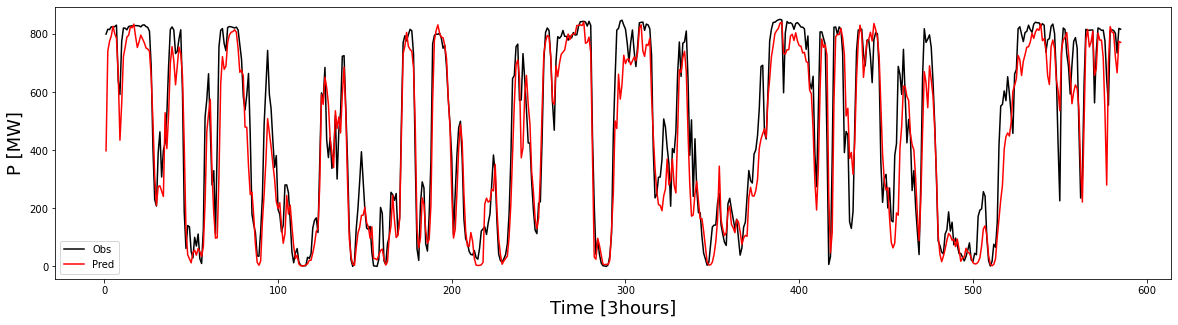

<IPython.core.display.Javascript object>

In [35]:
epochs = range(1, len(predx) + 1)
# naive_len = range(1, len(naive_forecast) + 1)
# # plt.plot(epochs, acc, 'blue', label='Training acc')
# # plt.plot(epochs, val_acc, 'red', label='Validation acc')
# # plt.title('Training and validation accuracy')
# # plt.legend()
values = DataFrame(y_test)
dataframe = np.concatenate([values.shift(1)], axis=1)


plt.figure(figsize=(20, 5))
plt.plot(epochs, y_test, "black", label="Obs")
# plt.plot(dataframe, "green", label="Naive")
plt.plot(epochs, predx, "red", label="Pred")


# plt.plot(epochs, np.abs(DataFrame(power_test["nowcast_3hr"])), "blue", label="Nowcast")
# plt.plot(epochs, np.abs(DataFrame(power_test["dayahead_3hr"])), "pink", label="Dayahead")


plt.xlabel("Time [3hours]", fontsize=18)
plt.ylabel("P [MW]", fontsize=18)
# plt.title("Training and validation loss")
plt.legend()

In [36]:
from pandas import DataFrame
from pandas import concat


values = DataFrame(y_test)
dataframe = concat([values.shift(1)], axis=1)
dataframe.columns = ["t-1"]
# print(dataframe.head(5))
# dataframe.values[0]

values = DataFrame(y_test)
dataframe_2 = concat([values.shift(2)], axis=1)

# Error
Err_naive_1 = [(np.abs(dataframe - y_test)).mean()]
Err_naive_2 = [(np.abs(dataframe_2 - y_test)).mean()]

Err_predT = [(np.abs(DataFrame(predTr) - y_train)).mean()]
Err_predV = [(np.abs(DataFrame(predVl) - y_val)).mean()]
Err_pred = [(np.abs(DataFrame(predx) - y_test)).mean()]


Err_nowcast = [(np.abs(DataFrame(power_test["nowcast_3hr"]) - y_test)).mean()]
Err_dayahead = [(np.abs(DataFrame(power_test["dayahead_3hr"]) - y_test)).mean()]


[Err_naive_1, Err_naive_2, Err_pred, Err_nowcast, Err_dayahead, Err_predT, Err_predV]
# dataframe_2.columns = ["t-1"]
# [values[:4], dataframe[:4]]



[[t-1    79.549184
  dtype: float64],
 [0    132.515379
  dtype: float64],
 [0    76.928842
  dtype: float64],
 [nowcast_3hr    36.082942
  dtype: float64],
 [dayahead_3hr    52.406614
  dtype: float64],
 [0    87.806407
  dtype: float64],
 [0    96.168162
  dtype: float64]]

<IPython.core.display.Javascript object>

In [37]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score


[
    mean_absolute_error(y_test, predx),
    mean_squared_error(y_test, predx, squared=False),
    mean_absolute_percentage_error(y_test, predx),
    r2_score(y_test, predx),
]

[76.9288420814123, 107.92003595338021, 116713977901847.75, 0.8734288514650966]

<IPython.core.display.Javascript object>

In [38]:
[
    mean_absolute_error(y_val, predVl),
    mean_squared_error(y_val, predVl),
    mean_absolute_percentage_error(y_val, predVl),
    r2_score(y_val, predVl),
]

[96.1681617303893, 21248.42139805262, 8665596353630189.0, 0.6417578976686661]

<IPython.core.display.Javascript object>

In [39]:
trx = predTr.tolist()
yac = y_train.tolist()
[
    mean_absolute_error(y_train, predTr),
    mean_squared_error(y_train, predTr),
    mean_absolute_percentage_error(yac, trx),
    r2_score(y_train, predTr),
]

[87.80640681448996, 17374.481909388123, 2283902837818235.0, 0.7062661999817085]

<IPython.core.display.Javascript object>

# Multi model

In [59]:
from sklearn.model_selection import TimeSeriesSplit

[X_train_Ens.shape, X_trainl.shape]

[(5263, 6, 9, 1), (4678, 123)]

<IPython.core.display.Javascript object>

In [63]:
# Stack generalazation
from numpy.random import seed

seed(123)


import tensorflow

tensorflow.random.set_seed(123)

epoch = 1000
from os import makedirs

# fit model on dataset
def fit_model(trainX, trainy, epochs, verbose):

    #     mlp_input = Input(shape=X_trainS.shape[1])

    #     hidden1 = Dense(32, activation="relu", kernel_initializer="he_uniform")(mlp_input)
    #     hidden2 = Dense(32, activation="relu", kernel_initializer="he_uniform")(hidden1)
    #     hidden3 = Dense(64, activation="relu", kernel_initializer="he_uniform")(hidden2)
    #     hidden4 = Dense(128, activation="relu", kernel_initializer="he_uniform")(hidden3)
    #     hidden5 = Dense(256, activation="relu", kernel_initializer="he_uniform")(hidden4)
    #     hidden6 = Dense(32, activation="relu", kernel_initializer="he_uniform")(hidden5)

    #     mlp_out = Dense(1)(hidden6)
    #     model_ap = Model(inputs=mlp_input, outputs=mlp_out)
    model_ap.compile(
        loss="mae",
        optimizer=optimizers.Adam(
            lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0
        ),
    )
    model_ap.fit(
        [X_trainl_Ens[train_index]],
        y_train_Ens[train_index],
        validation_data=(
            [X_trainl_Ens[test_index]],
            y_train_Ens[test_index],
        ),
        epochs=epoch,
        batch_size=batch_size,
        callbacks=callbacks_list,
        verbose=1,
    )
    return model_ap

<IPython.core.display.Javascript object>

In [64]:
# kfold = KFold(n_splits=5, shuffle=False, random_state=1)

# count=1
epoch = 1000

tscv = TimeSeriesSplit(n_splits=50)
count = 1
for train_index, test_index in tscv.split(X_trainl_Ens):
    # fit model
    model_ap = fit_model(
        [X_trainl_Ens[train_index]],
        y_train_Ens[train_index],
        epochs=epoch,
        verbose=1,
    )

    # save model
    filename = "models/model_" + str(count) + ".h5"
    model_ap.save(filename)
    print(">Saved %s" % filename)
    count += 1

Epoch 1/1000
2/2 [==============================] - 0s 121ms/step - loss: 75.7743 - val_loss: 61.6107
Epoch 2/1000
2/2 [==============================] - 0s 52ms/step - loss: 63.7196 - val_loss: 54.8377
Epoch 3/1000
2/2 [==============================] - 0s 59ms/step - loss: 55.2241 - val_loss: 51.5374
Epoch 4/1000
2/2 [==============================] - 0s 61ms/step - loss: 51.3458 - val_loss: 50.6089
Epoch 5/1000
2/2 [==============================] - 0s 16ms/step - loss: 51.9648 - val_loss: 50.8561
Epoch 6/1000
2/2 [==============================] - 0s 14ms/step - loss: 53.5841 - val_loss: 51.4933
Epoch 7/1000
2/2 [==============================] - 0s 15ms/step - loss: 54.2912 - val_loss: 51.8574
Epoch 8/1000
2/2 [==============================] - 0s 13ms/step - loss: 54.4174 - val_loss: 51.7106
Epoch 9/1000
2/2 [==============================] - 0s 15ms/step - loss: 54.0279 - val_loss: 51.4761
Epoch 10/1000
2/2 [==============================] - 0s 15ms/step - loss: 52.9712 - val_lo

Epoch 32/1000
7/7 [==============================] - 0s 6ms/step - loss: 52.6868 - val_loss: 93.8959
Epoch 33/1000
7/7 [==============================] - 0s 6ms/step - loss: 52.5246 - val_loss: 93.8600
Epoch 34/1000
7/7 [==============================] - 0s 5ms/step - loss: 52.4846 - val_loss: 93.8781
Epoch 35/1000
7/7 [==============================] - 0s 6ms/step - loss: 52.5050 - val_loss: 94.1161
Epoch 36/1000
7/7 [==============================] - 0s 6ms/step - loss: 52.9925 - val_loss: 94.5240
Epoch 37/1000
7/7 [==============================] - 0s 7ms/step - loss: 52.4537 - val_loss: 93.2465
Epoch 38/1000
7/7 [==============================] - 0s 6ms/step - loss: 52.5466 - val_loss: 93.6327
Epoch 39/1000
7/7 [==============================] - 0s 5ms/step - loss: 52.3528 - val_loss: 93.7723
Epoch 40/1000
7/7 [==============================] - 0s 5ms/step - loss: 52.4426 - val_loss: 93.5909
Epoch 41/1000
7/7 [==============================] - 0s 5ms/step - loss: 52.2945 - val_loss

Epoch 113/1000
7/7 [==============================] - 0s 7ms/step - loss: 51.0049 - val_loss: 92.7164
Epoch 114/1000
7/7 [==============================] - 0s 5ms/step - loss: 51.0481 - val_loss: 92.4417
Epoch 115/1000
7/7 [==============================] - 0s 5ms/step - loss: 51.0005 - val_loss: 92.6302
Epoch 116/1000
7/7 [==============================] - 0s 5ms/step - loss: 51.0667 - val_loss: 92.7280
Epoch 117/1000
7/7 [==============================] - 0s 5ms/step - loss: 50.9633 - val_loss: 92.2437
Epoch 118/1000
7/7 [==============================] - 0s 7ms/step - loss: 50.9564 - val_loss: 92.6155
Epoch 119/1000
7/7 [==============================] - 0s 6ms/step - loss: 50.8891 - val_loss: 92.3780
Epoch 120/1000
7/7 [==============================] - 0s 5ms/step - loss: 50.9374 - val_loss: 92.7489
Epoch 121/1000
7/7 [==============================] - 0s 6ms/step - loss: 51.1117 - val_loss: 92.1944
Epoch 122/1000
7/7 [==============================] - 0s 7ms/step - loss: 51.2721 

7/7 [==============================] - 0s 5ms/step - loss: 49.1266 - val_loss: 90.3045
Epoch 274/1000
7/7 [==============================] - 0s 5ms/step - loss: 49.0029 - val_loss: 90.7013
Epoch 275/1000
7/7 [==============================] - 0s 6ms/step - loss: 49.1930 - val_loss: 90.2071
Epoch 276/1000
7/7 [==============================] - 0s 6ms/step - loss: 48.8751 - val_loss: 90.3830
Epoch 277/1000
7/7 [==============================] - 0s 6ms/step - loss: 49.1360 - val_loss: 90.2239
Epoch 278/1000
7/7 [==============================] - 0s 6ms/step - loss: 49.9678 - val_loss: 89.8534
Epoch 279/1000
7/7 [==============================] - 0s 5ms/step - loss: 49.3525 - val_loss: 91.0199
Epoch 280/1000
7/7 [==============================] - 0s 6ms/step - loss: 49.2689 - val_loss: 89.9770
Epoch 281/1000
7/7 [==============================] - 0s 5ms/step - loss: 48.8821 - val_loss: 90.5446
Epoch 282/1000
7/7 [==============================] - 0s 6ms/step - loss: 48.8749 - val_loss: 90.

9/9 [==============================] - 0s 5ms/step - loss: 55.6364 - val_loss: 93.1752
Epoch 15/1000
9/9 [==============================] - 0s 4ms/step - loss: 55.3620 - val_loss: 93.3964
Epoch 16/1000
9/9 [==============================] - 0s 5ms/step - loss: 55.1820 - val_loss: 93.5443
Epoch 17/1000
9/9 [==============================] - 0s 5ms/step - loss: 55.2161 - val_loss: 93.5878
Epoch 18/1000
9/9 [==============================] - 0s 6ms/step - loss: 55.6455 - val_loss: 93.2878
Epoch 19/1000
9/9 [==============================] - 0s 6ms/step - loss: 55.6131 - val_loss: 94.0033
Epoch 20/1000
9/9 [==============================] - 0s 5ms/step - loss: 55.3916 - val_loss: 93.5182
Epoch 21/1000
9/9 [==============================] - 0s 5ms/step - loss: 55.7382 - val_loss: 93.9604
Epoch 22/1000
9/9 [==============================] - 0s 5ms/step - loss: 55.6120 - val_loss: 94.0460
Epoch 23/1000
9/9 [==============================] - 0s 5ms/step - loss: 55.9049 - val_loss: 94.6252
Epoc

Epoch 11/1000
12/12 [==============================] - 0s 4ms/step - loss: 63.5421 - val_loss: 133.5484
Epoch 12/1000
12/12 [==============================] - 0s 6ms/step - loss: 63.8996 - val_loss: 133.2272
Epoch 13/1000
12/12 [==============================] - 0s 6ms/step - loss: 63.5612 - val_loss: 133.2899
Epoch 14/1000
12/12 [==============================] - 0s 6ms/step - loss: 63.4812 - val_loss: 133.6014
Epoch 15/1000
12/12 [==============================] - 0s 7ms/step - loss: 63.5615 - val_loss: 133.7210
Epoch 16/1000
12/12 [==============================] - 0s 6ms/step - loss: 63.6394 - val_loss: 133.6604
Epoch 17/1000
12/12 [==============================] - 0s 5ms/step - loss: 63.8489 - val_loss: 133.0886
Epoch 18/1000
12/12 [==============================] - 0s 5ms/step - loss: 63.5839 - val_loss: 133.4228
Epoch 19/1000
12/12 [==============================] - 0s 4ms/step - loss: 63.6794 - val_loss: 133.4936
Epoch 20/1000
12/12 [==============================] - 0s 5ms/st

17/17 [==============================] - 0s 4ms/step - loss: 89.4753 - val_loss: 141.6028
Epoch 17/1000
17/17 [==============================] - 0s 4ms/step - loss: 89.5389 - val_loss: 141.2180
Epoch 18/1000
17/17 [==============================] - 0s 4ms/step - loss: 89.5498 - val_loss: 140.3271
Epoch 19/1000
17/17 [==============================] - 0s 4ms/step - loss: 89.4950 - val_loss: 141.0397
Epoch 20/1000
17/17 [==============================] - 0s 4ms/step - loss: 89.3295 - val_loss: 140.9594
Epoch 21/1000
17/17 [==============================] - 0s 5ms/step - loss: 89.1979 - val_loss: 141.1015
Epoch 22/1000
17/17 [==============================] - 0s 4ms/step - loss: 89.4747 - val_loss: 139.8628
Epoch 23/1000
17/17 [==============================] - 0s 5ms/step - loss: 89.2582 - val_loss: 140.9866
Epoch 24/1000
17/17 [==============================] - 0s 4ms/step - loss: 89.1673 - val_loss: 140.3584
Epoch 25/1000
17/17 [==============================] - 0s 4ms/step - loss: 89.

18/18 [==============================] - 0s 4ms/step - loss: 93.1696 - val_loss: 98.0461
Epoch 34/1000
18/18 [==============================] - 0s 4ms/step - loss: 93.1108 - val_loss: 97.0854
Epoch 35/1000
18/18 [==============================] - 0s 4ms/step - loss: 93.0281 - val_loss: 97.8893
Epoch 36/1000
18/18 [==============================] - 0s 4ms/step - loss: 93.0881 - val_loss: 97.8626
Epoch 37/1000
18/18 [==============================] - 0s 4ms/step - loss: 93.0340 - val_loss: 98.1589
Epoch 38/1000
18/18 [==============================] - 0s 4ms/step - loss: 93.1176 - val_loss: 96.8983
Epoch 39/1000
18/18 [==============================] - 0s 4ms/step - loss: 93.1852 - val_loss: 97.4964
Epoch 40/1000
18/18 [==============================] - 0s 4ms/step - loss: 93.0133 - val_loss: 98.1902
Epoch 41/1000
18/18 [==============================] - 0s 4ms/step - loss: 93.3953 - val_loss: 96.8366
Epoch 42/1000
18/18 [==============================] - 0s 4ms/step - loss: 93.2287 - va

22/22 [==============================] - 0s 4ms/step - loss: 90.7981 - val_loss: 180.2811
Epoch 17/1000
22/22 [==============================] - 0s 4ms/step - loss: 90.8137 - val_loss: 181.2673
Epoch 18/1000
22/22 [==============================] - 0s 4ms/step - loss: 91.9071 - val_loss: 177.4341
Epoch 19/1000
22/22 [==============================] - 0s 4ms/step - loss: 91.1284 - val_loss: 179.9258
Epoch 20/1000
22/22 [==============================] - 0s 4ms/step - loss: 91.2305 - val_loss: 179.9041
Epoch 21/1000
22/22 [==============================] - 0s 4ms/step - loss: 90.8845 - val_loss: 180.7793
Epoch 22/1000
22/22 [==============================] - 0s 4ms/step - loss: 90.9162 - val_loss: 177.9070
Epoch 23/1000
22/22 [==============================] - 0s 4ms/step - loss: 91.3206 - val_loss: 179.7098
Epoch 24/1000
22/22 [==============================] - 0s 4ms/step - loss: 90.8048 - val_loss: 180.1912
Epoch 25/1000
22/22 [==============================] - 0s 5ms/step - loss: 90.

25/25 [==============================] - 0s 4ms/step - loss: 102.1945 - val_loss: 107.5805
Epoch 51/1000
25/25 [==============================] - 0s 5ms/step - loss: 102.4255 - val_loss: 107.0101
Epoch 52/1000
25/25 [==============================] - 0s 6ms/step - loss: 102.1756 - val_loss: 109.9831
Epoch 53/1000
25/25 [==============================] - 0s 4ms/step - loss: 102.4031 - val_loss: 109.1007
Epoch 54/1000
25/25 [==============================] - 0s 4ms/step - loss: 102.2955 - val_loss: 108.7572
Epoch 55/1000
25/25 [==============================] - 0s 5ms/step - loss: 102.3728 - val_loss: 108.1884
Epoch 56/1000
25/25 [==============================] - 0s 5ms/step - loss: 102.2743 - val_loss: 108.0810
Epoch 57/1000
25/25 [==============================] - 0s 5ms/step - loss: 102.5300 - val_loss: 106.9780
Epoch 58/1000
25/25 [==============================] - 0s 5ms/step - loss: 102.5152 - val_loss: 109.0300
Epoch 59/1000
25/25 [==============================] - 0s 5ms/step - 

Epoch 58/1000
26/26 [==============================] - 0s 4ms/step - loss: 102.0538 - val_loss: 156.1779
Epoch 59/1000
26/26 [==============================] - 0s 4ms/step - loss: 101.8804 - val_loss: 155.2297
Epoch 60/1000
26/26 [==============================] - 0s 5ms/step - loss: 101.7652 - val_loss: 155.3690
Epoch 61/1000
26/26 [==============================] - 0s 6ms/step - loss: 101.8651 - val_loss: 155.8792
>Saved models/model_16.h5
Epoch 1/1000
28/28 [==============================] - 0s 9ms/step - loss: 105.3315 - val_loss: 128.9992
Epoch 2/1000
28/28 [==============================] - 0s 4ms/step - loss: 105.0505 - val_loss: 128.7980
Epoch 3/1000
28/28 [==============================] - 0s 4ms/step - loss: 105.0737 - val_loss: 128.2926
Epoch 4/1000
28/28 [==============================] - 0s 4ms/step - loss: 105.0781 - val_loss: 128.7912
Epoch 5/1000
28/28 [==============================] - 0s 4ms/step - loss: 105.3017 - val_loss: 127.3494
Epoch 6/1000
28/28 [==============

Epoch 75/1000
28/28 [==============================] - 0s 4ms/step - loss: 103.8611 - val_loss: 126.9925
Epoch 76/1000
28/28 [==============================] - 0s 5ms/step - loss: 104.0842 - val_loss: 126.0910
Epoch 77/1000
28/28 [==============================] - 0s 5ms/step - loss: 104.2803 - val_loss: 127.0027
Epoch 78/1000
28/28 [==============================] - 0s 5ms/step - loss: 104.0673 - val_loss: 127.1434
Epoch 79/1000
28/28 [==============================] - 0s 4ms/step - loss: 103.9079 - val_loss: 126.8807
Epoch 80/1000
28/28 [==============================] - 0s 4ms/step - loss: 104.0193 - val_loss: 126.7885
Epoch 81/1000
28/28 [==============================] - 0s 4ms/step - loss: 103.9484 - val_loss: 127.1411
Epoch 82/1000
28/28 [==============================] - 0s 4ms/step - loss: 103.8299 - val_loss: 126.3293
Epoch 83/1000
28/28 [==============================] - 0s 5ms/step - loss: 103.9145 - val_loss: 127.2132
Epoch 84/1000
28/28 [==============================] - 

Epoch 68/1000
30/30 [==============================] - 0s 4ms/step - loss: 104.0851 - val_loss: 119.7844
Epoch 69/1000
30/30 [==============================] - 0s 3ms/step - loss: 104.3214 - val_loss: 120.8533
Epoch 70/1000
30/30 [==============================] - 0s 4ms/step - loss: 103.9160 - val_loss: 119.3870
Epoch 71/1000
30/30 [==============================] - 0s 4ms/step - loss: 104.4436 - val_loss: 120.1912
Epoch 72/1000
30/30 [==============================] - 0s 4ms/step - loss: 103.9985 - val_loss: 121.0386
Epoch 73/1000
30/30 [==============================] - 0s 4ms/step - loss: 104.0287 - val_loss: 120.7373
Epoch 74/1000
30/30 [==============================] - 0s 5ms/step - loss: 104.0945 - val_loss: 119.4542
Epoch 75/1000
30/30 [==============================] - 0s 4ms/step - loss: 104.2942 - val_loss: 120.6559
Epoch 76/1000
30/30 [==============================] - 0s 4ms/step - loss: 104.1944 - val_loss: 120.3339
Epoch 77/1000
30/30 [==============================] - 

33/33 [==============================] - 0s 4ms/step - loss: 101.4521 - val_loss: 85.7920
Epoch 29/1000
33/33 [==============================] - 0s 4ms/step - loss: 101.7646 - val_loss: 86.1575
Epoch 30/1000
33/33 [==============================] - 0s 4ms/step - loss: 101.4223 - val_loss: 88.2120
Epoch 31/1000
33/33 [==============================] - 0s 3ms/step - loss: 101.5197 - val_loss: 87.4946
Epoch 32/1000
33/33 [==============================] - 0s 3ms/step - loss: 101.6457 - val_loss: 89.9719
Epoch 33/1000
33/33 [==============================] - 0s 3ms/step - loss: 101.2713 - val_loss: 86.4823
Epoch 34/1000
33/33 [==============================] - 0s 4ms/step - loss: 101.3830 - val_loss: 85.6874
Epoch 35/1000
33/33 [==============================] - 0s 4ms/step - loss: 101.3354 - val_loss: 87.7660
Epoch 36/1000
33/33 [==============================] - 0s 4ms/step - loss: 101.3570 - val_loss: 85.6877
Epoch 37/1000
33/33 [==============================] - 0s 4ms/step - loss: 101

34/34 [==============================] - 0s 4ms/step - loss: 99.3759 - val_loss: 96.1433
>Saved models/model_21.h5
Epoch 1/1000
36/36 [==============================] - 0s 10ms/step - loss: 99.0291 - val_loss: 103.8714
Epoch 2/1000
36/36 [==============================] - 0s 4ms/step - loss: 99.0767 - val_loss: 106.4921
Epoch 3/1000
36/36 [==============================] - 0s 4ms/step - loss: 98.7200 - val_loss: 104.7390
Epoch 4/1000
36/36 [==============================] - 0s 4ms/step - loss: 98.7236 - val_loss: 110.3405
Epoch 5/1000
36/36 [==============================] - 0s 4ms/step - loss: 98.5403 - val_loss: 105.0328
Epoch 6/1000
36/36 [==============================] - 0s 3ms/step - loss: 98.6856 - val_loss: 110.2344
Epoch 7/1000
36/36 [==============================] - 0s 4ms/step - loss: 98.7795 - val_loss: 104.6501
Epoch 8/1000
36/36 [==============================] - 0s 4ms/step - loss: 98.5864 - val_loss: 108.8183
Epoch 9/1000
36/36 [==============================] - 0s 4ms

Epoch 26/1000
38/38 [==============================] - 0s 4ms/step - loss: 97.3426 - val_loss: 46.1908
Epoch 27/1000
38/38 [==============================] - 0s 4ms/step - loss: 97.2534 - val_loss: 47.8520
Epoch 28/1000
38/38 [==============================] - 0s 3ms/step - loss: 97.3326 - val_loss: 46.1271
Epoch 29/1000
38/38 [==============================] - 0s 3ms/step - loss: 97.3603 - val_loss: 48.6783
Epoch 30/1000
38/38 [==============================] - 0s 4ms/step - loss: 97.7137 - val_loss: 45.8066
Epoch 31/1000
38/38 [==============================] - 0s 4ms/step - loss: 97.5587 - val_loss: 46.2139
Epoch 32/1000
38/38 [==============================] - 0s 4ms/step - loss: 97.4153 - val_loss: 46.3679
Epoch 33/1000
38/38 [==============================] - 0s 4ms/step - loss: 97.1315 - val_loss: 46.5275
Epoch 34/1000
38/38 [==============================] - 0s 4ms/step - loss: 97.7467 - val_loss: 47.3661
Epoch 35/1000
38/38 [==============================] - 0s 4ms/step - loss

42/42 [==============================] - 0s 3ms/step - loss: 92.2318 - val_loss: 74.4983
Epoch 23/1000
42/42 [==============================] - 0s 4ms/step - loss: 91.3769 - val_loss: 70.4271
Epoch 24/1000
42/42 [==============================] - 0s 4ms/step - loss: 91.8255 - val_loss: 73.1600
Epoch 25/1000
42/42 [==============================] - 0s 3ms/step - loss: 91.8114 - val_loss: 73.7177
Epoch 26/1000
42/42 [==============================] - 0s 3ms/step - loss: 91.6572 - val_loss: 77.5987
Epoch 27/1000
42/42 [==============================] - 0s 4ms/step - loss: 91.7120 - val_loss: 70.0635
Epoch 28/1000
42/42 [==============================] - 0s 4ms/step - loss: 91.4219 - val_loss: 74.2780
Epoch 29/1000
42/42 [==============================] - 0s 3ms/step - loss: 91.1233 - val_loss: 70.8928
Epoch 30/1000
42/42 [==============================] - 0s 4ms/step - loss: 91.3278 - val_loss: 73.9875
Epoch 31/1000
42/42 [==============================] - 0s 3ms/step - loss: 91.3007 - va

44/44 [==============================] - 0s 4ms/step - loss: 87.8237 - val_loss: 54.4746
Epoch 139/1000
44/44 [==============================] - 0s 4ms/step - loss: 87.8034 - val_loss: 53.3771
Epoch 140/1000
44/44 [==============================] - 0s 4ms/step - loss: 87.8769 - val_loss: 54.2045
Epoch 141/1000
44/44 [==============================] - 0s 5ms/step - loss: 87.9016 - val_loss: 55.6967
>Saved models/model_27.h5
Epoch 1/1000
46/46 [==============================] - 0s 8ms/step - loss: 87.5235 - val_loss: 60.7644
Epoch 2/1000
46/46 [==============================] - 0s 4ms/step - loss: 87.0805 - val_loss: 58.7152
Epoch 3/1000
46/46 [==============================] - 0s 4ms/step - loss: 86.8217 - val_loss: 56.9699
Epoch 4/1000
46/46 [==============================] - 0s 4ms/step - loss: 86.6766 - val_loss: 59.7735
Epoch 5/1000
46/46 [==============================] - 0s 4ms/step - loss: 86.8271 - val_loss: 59.5983
Epoch 6/1000
46/46 [==============================] - 0s 4ms/st

49/49 [==============================] - 0s 3ms/step - loss: 81.9978 - val_loss: 72.2608
Epoch 20/1000
49/49 [==============================] - 0s 4ms/step - loss: 82.9315 - val_loss: 69.2613
Epoch 21/1000
49/49 [==============================] - 0s 5ms/step - loss: 82.0620 - val_loss: 69.3844
Epoch 22/1000
49/49 [==============================] - 0s 4ms/step - loss: 81.8358 - val_loss: 70.0532
Epoch 23/1000
49/49 [==============================] - 0s 4ms/step - loss: 82.1164 - val_loss: 71.4038
Epoch 24/1000
49/49 [==============================] - 0s 4ms/step - loss: 82.2407 - val_loss: 71.2618
Epoch 25/1000
49/49 [==============================] - 0s 4ms/step - loss: 82.4042 - val_loss: 70.3201
Epoch 26/1000
49/49 [==============================] - 0s 4ms/step - loss: 82.4856 - val_loss: 69.6039
Epoch 27/1000
49/49 [==============================] - 0s 4ms/step - loss: 81.7213 - val_loss: 71.2781
Epoch 28/1000
49/49 [==============================] - 0s 3ms/step - loss: 82.0929 - va

52/52 [==============================] - 0s 3ms/step - loss: 80.4277 - val_loss: 95.0116
Epoch 32/1000
52/52 [==============================] - 0s 3ms/step - loss: 80.1640 - val_loss: 94.8380
Epoch 33/1000
52/52 [==============================] - 0s 3ms/step - loss: 80.7013 - val_loss: 91.8691
Epoch 34/1000
52/52 [==============================] - 0s 4ms/step - loss: 80.5680 - val_loss: 92.2959
Epoch 35/1000
52/52 [==============================] - 0s 4ms/step - loss: 80.5523 - val_loss: 95.8288
Epoch 36/1000
52/52 [==============================] - 0s 4ms/step - loss: 81.0151 - val_loss: 96.3683
Epoch 37/1000
52/52 [==============================] - 0s 3ms/step - loss: 81.4401 - val_loss: 96.5651
Epoch 38/1000
52/52 [==============================] - 0s 3ms/step - loss: 80.7935 - val_loss: 102.5571
Epoch 39/1000
52/52 [==============================] - 0s 3ms/step - loss: 81.3701 - val_loss: 96.6001
Epoch 40/1000
52/52 [==============================] - 0s 4ms/step - loss: 80.7568 - v

55/55 [==============================] - 0s 4ms/step - loss: 79.8548 - val_loss: 118.8049
Epoch 42/1000
55/55 [==============================] - 0s 4ms/step - loss: 79.8948 - val_loss: 120.3356
Epoch 43/1000
55/55 [==============================] - 0s 4ms/step - loss: 79.5220 - val_loss: 125.4147
>Saved models/model_34.h5
Epoch 1/1000
57/57 [==============================] - 0s 8ms/step - loss: 80.8920 - val_loss: 106.0401
Epoch 2/1000
57/57 [==============================] - 0s 3ms/step - loss: 80.4803 - val_loss: 105.4886
Epoch 3/1000
57/57 [==============================] - 0s 4ms/step - loss: 80.4290 - val_loss: 106.3445
Epoch 4/1000
57/57 [==============================] - 0s 4ms/step - loss: 80.4441 - val_loss: 102.5206
Epoch 5/1000
57/57 [==============================] - 0s 4ms/step - loss: 80.0346 - val_loss: 106.3040
Epoch 6/1000
57/57 [==============================] - 0s 4ms/step - loss: 80.1384 - val_loss: 108.7326
Epoch 7/1000
57/57 [==============================] - 0s 4

60/60 [==============================] - 0s 4ms/step - loss: 79.4517 - val_loss: 95.5037
Epoch 49/1000
60/60 [==============================] - 0s 4ms/step - loss: 79.0797 - val_loss: 87.4071
Epoch 50/1000
60/60 [==============================] - 0s 4ms/step - loss: 78.9857 - val_loss: 97.2062
Epoch 51/1000
60/60 [==============================] - 0s 4ms/step - loss: 79.5397 - val_loss: 91.1938
Epoch 52/1000
60/60 [==============================] - 0s 4ms/step - loss: 79.2621 - val_loss: 92.4064
Epoch 53/1000
60/60 [==============================] - 0s 5ms/step - loss: 79.1565 - val_loss: 108.4118
Epoch 54/1000
60/60 [==============================] - 0s 3ms/step - loss: 79.4189 - val_loss: 94.8990
Epoch 55/1000
60/60 [==============================] - 0s 4ms/step - loss: 79.0465 - val_loss: 96.4237
Epoch 56/1000
60/60 [==============================] - 0s 4ms/step - loss: 79.1701 - val_loss: 99.6408
Epoch 57/1000
60/60 [==============================] - 0s 4ms/step - loss: 79.0669 - v

62/62 [==============================] - 0s 4ms/step - loss: 78.6939 - val_loss: 126.0826
Epoch 43/1000
62/62 [==============================] - 0s 4ms/step - loss: 78.7166 - val_loss: 128.6599
Epoch 44/1000
62/62 [==============================] - 0s 3ms/step - loss: 78.8928 - val_loss: 132.0930
Epoch 45/1000
62/62 [==============================] - 0s 3ms/step - loss: 78.9013 - val_loss: 127.1924
Epoch 46/1000
62/62 [==============================] - 0s 3ms/step - loss: 78.6765 - val_loss: 127.2755
Epoch 47/1000
62/62 [==============================] - 0s 3ms/step - loss: 78.7174 - val_loss: 124.7483
Epoch 48/1000
62/62 [==============================] - 0s 4ms/step - loss: 78.6766 - val_loss: 124.3053
Epoch 49/1000
62/62 [==============================] - 0s 4ms/step - loss: 78.3860 - val_loss: 123.6465
Epoch 50/1000
62/62 [==============================] - 0s 3ms/step - loss: 78.6332 - val_loss: 128.0558
Epoch 51/1000
62/62 [==============================] - 0s 3ms/step - loss: 78.

65/65 [==============================] - 0s 3ms/step - loss: 78.8269 - val_loss: 111.6644
Epoch 26/1000
65/65 [==============================] - 0s 4ms/step - loss: 78.6491 - val_loss: 110.7391
Epoch 27/1000
65/65 [==============================] - 0s 3ms/step - loss: 78.4145 - val_loss: 111.2414
Epoch 28/1000
65/65 [==============================] - 0s 3ms/step - loss: 78.2827 - val_loss: 106.8325
Epoch 29/1000
65/65 [==============================] - 0s 3ms/step - loss: 78.5869 - val_loss: 109.3990
Epoch 30/1000
65/65 [==============================] - 0s 3ms/step - loss: 78.5648 - val_loss: 100.9675
Epoch 31/1000
65/65 [==============================] - 0s 4ms/step - loss: 78.6750 - val_loss: 108.9530
Epoch 32/1000
65/65 [==============================] - 0s 4ms/step - loss: 78.7539 - val_loss: 111.4626
Epoch 33/1000
65/65 [==============================] - 0s 4ms/step - loss: 78.7431 - val_loss: 116.6306
Epoch 34/1000
65/65 [==============================] - 0s 4ms/step - loss: 78.

Epoch 112/1000
67/67 [==============================] - 0s 2ms/step - loss: 76.9679 - val_loss: 120.0178
Epoch 113/1000
67/67 [==============================] - 0s 4ms/step - loss: 76.7280 - val_loss: 126.7211
Epoch 114/1000
67/67 [==============================] - 0s 4ms/step - loss: 76.8275 - val_loss: 128.3808
Epoch 115/1000
67/67 [==============================] - 0s 4ms/step - loss: 77.2872 - val_loss: 120.0400
Epoch 116/1000
67/67 [==============================] - 0s 4ms/step - loss: 76.6758 - val_loss: 125.2686
Epoch 117/1000
67/67 [==============================] - 0s 4ms/step - loss: 76.7842 - val_loss: 125.3919
Epoch 118/1000
67/67 [==============================] - 0s 4ms/step - loss: 77.0156 - val_loss: 130.9332
Epoch 119/1000
67/67 [==============================] - 0s 4ms/step - loss: 77.0103 - val_loss: 133.2766
Epoch 120/1000
67/67 [==============================] - 0s 4ms/step - loss: 77.0325 - val_loss: 127.6555
Epoch 121/1000
67/67 [==============================] -

71/71 [==============================] - 0s 4ms/step - loss: 77.0049 - val_loss: 157.1313
Epoch 30/1000
71/71 [==============================] - 0s 3ms/step - loss: 76.7686 - val_loss: 152.7220
Epoch 31/1000
71/71 [==============================] - 0s 3ms/step - loss: 76.7770 - val_loss: 163.5391
Epoch 32/1000
71/71 [==============================] - 0s 3ms/step - loss: 76.4184 - val_loss: 163.9799
Epoch 33/1000
71/71 [==============================] - 0s 3ms/step - loss: 76.2568 - val_loss: 156.2916
Epoch 34/1000
71/71 [==============================] - 0s 4ms/step - loss: 76.3668 - val_loss: 159.4732
Epoch 35/1000
71/71 [==============================] - 0s 3ms/step - loss: 76.4153 - val_loss: 157.0430
Epoch 36/1000
71/71 [==============================] - 0s 3ms/step - loss: 76.3137 - val_loss: 156.7738
Epoch 37/1000
71/71 [==============================] - 0s 3ms/step - loss: 76.4515 - val_loss: 147.2738
Epoch 38/1000
71/71 [==============================] - 0s 4ms/step - loss: 76.

Epoch 108/1000
71/71 [==============================] - 0s 4ms/step - loss: 74.6419 - val_loss: 140.5540
Epoch 109/1000
71/71 [==============================] - 0s 4ms/step - loss: 75.3780 - val_loss: 138.8237
Epoch 110/1000
71/71 [==============================] - 0s 3ms/step - loss: 75.7973 - val_loss: 162.1717
Epoch 111/1000
71/71 [==============================] - 0s 3ms/step - loss: 75.1632 - val_loss: 145.8866
Epoch 112/1000
71/71 [==============================] - 0s 3ms/step - loss: 75.1054 - val_loss: 156.8303
Epoch 113/1000
71/71 [==============================] - 0s 3ms/step - loss: 75.1050 - val_loss: 156.4592
Epoch 114/1000
71/71 [==============================] - 0s 3ms/step - loss: 75.1279 - val_loss: 162.6339
Epoch 115/1000
71/71 [==============================] - 0s 3ms/step - loss: 75.4076 - val_loss: 146.4821
Epoch 116/1000
71/71 [==============================] - 0s 3ms/step - loss: 75.5569 - val_loss: 156.2442
Epoch 117/1000
71/71 [==============================] -

73/73 [==============================] - 0s 4ms/step - loss: 74.0090 - val_loss: 86.9303
Epoch 117/1000
73/73 [==============================] - 0s 4ms/step - loss: 74.0648 - val_loss: 85.6402
Epoch 118/1000
73/73 [==============================] - 0s 4ms/step - loss: 74.3204 - val_loss: 85.5210
Epoch 119/1000
73/73 [==============================] - 0s 3ms/step - loss: 73.9697 - val_loss: 86.4305
Epoch 120/1000
73/73 [==============================] - 0s 4ms/step - loss: 74.6087 - val_loss: 86.3140
Epoch 121/1000
73/73 [==============================] - 0s 4ms/step - loss: 74.4717 - val_loss: 85.4063
Epoch 122/1000
73/73 [==============================] - 0s 4ms/step - loss: 73.8815 - val_loss: 85.4260
Epoch 123/1000
73/73 [==============================] - 0s 4ms/step - loss: 74.2151 - val_loss: 85.2246
Epoch 124/1000
73/73 [==============================] - 0s 4ms/step - loss: 73.9344 - val_loss: 84.7251
Epoch 125/1000
73/73 [==============================] - 0s 4ms/step - loss: 74.

76/76 [==============================] - 0s 3ms/step - loss: 73.5692 - val_loss: 95.1046
Epoch 5/1000
76/76 [==============================] - 0s 4ms/step - loss: 73.1261 - val_loss: 93.4534
Epoch 6/1000
76/76 [==============================] - 0s 3ms/step - loss: 74.3065 - val_loss: 93.9262
Epoch 7/1000
76/76 [==============================] - 0s 3ms/step - loss: 73.1556 - val_loss: 95.3779
Epoch 8/1000
76/76 [==============================] - 0s 3ms/step - loss: 72.7681 - val_loss: 97.6868
Epoch 9/1000
76/76 [==============================] - 0s 3ms/step - loss: 73.4811 - val_loss: 91.4845
Epoch 10/1000
76/76 [==============================] - 0s 4ms/step - loss: 73.3213 - val_loss: 97.6140
Epoch 11/1000
76/76 [==============================] - 0s 4ms/step - loss: 73.0978 - val_loss: 92.6826
Epoch 12/1000
76/76 [==============================] - 0s 4ms/step - loss: 73.0355 - val_loss: 97.3784
Epoch 13/1000
76/76 [==============================] - 0s 4ms/step - loss: 72.8346 - val_los

80/80 [==============================] - 0s 3ms/step - loss: 72.8661 - val_loss: 89.7085
Epoch 24/1000
80/80 [==============================] - 0s 4ms/step - loss: 72.4001 - val_loss: 96.1816
Epoch 25/1000
80/80 [==============================] - 0s 4ms/step - loss: 75.8672 - val_loss: 86.1094
Epoch 26/1000
80/80 [==============================] - 0s 4ms/step - loss: 73.1691 - val_loss: 85.8864
Epoch 27/1000
80/80 [==============================] - 0s 4ms/step - loss: 71.1683 - val_loss: 74.5407
Epoch 28/1000
80/80 [==============================] - 0s 3ms/step - loss: 74.7768 - val_loss: 88.2879
Epoch 29/1000
80/80 [==============================] - 0s 4ms/step - loss: 71.6592 - val_loss: 89.0811
Epoch 30/1000
80/80 [==============================] - 0s 3ms/step - loss: 71.5565 - val_loss: 75.0947
Epoch 31/1000
80/80 [==============================] - 0s 3ms/step - loss: 71.6357 - val_loss: 76.8687
Epoch 32/1000
80/80 [==============================] - 0s 3ms/step - loss: 72.8207 - va

<IPython.core.display.Javascript object>

In [68]:
# Create lagged dataset
# load models from file
from keras.models import load_model


def load_all_models(n_models):
    all_models = list()
    for i in range(n_models):
        # define filename for this ensemble
        filename = "models/model_" + str(i + 1) + ".h5"
        # load model from file
        model = load_model(filename)
        # add to list of members
        all_models.append(model)
        print(">loaded %s" % filename)
    return all_models

<IPython.core.display.Javascript object>

In [69]:
# load all models
n_members = 50
members = load_all_models(n_members)
print("Loaded %d models" % len(members))

>loaded models/model_1.h5
>loaded models/model_2.h5
>loaded models/model_3.h5
>loaded models/model_4.h5
>loaded models/model_5.h5
>loaded models/model_6.h5
>loaded models/model_7.h5
>loaded models/model_8.h5
>loaded models/model_9.h5
>loaded models/model_10.h5
>loaded models/model_11.h5
>loaded models/model_12.h5
>loaded models/model_13.h5
>loaded models/model_14.h5
>loaded models/model_15.h5
>loaded models/model_16.h5
>loaded models/model_17.h5
>loaded models/model_18.h5
>loaded models/model_19.h5
>loaded models/model_20.h5
>loaded models/model_21.h5
>loaded models/model_22.h5
>loaded models/model_23.h5
>loaded models/model_24.h5
>loaded models/model_25.h5
>loaded models/model_26.h5
>loaded models/model_27.h5
>loaded models/model_28.h5
>loaded models/model_29.h5
>loaded models/model_30.h5
>loaded models/model_31.h5
>loaded models/model_32.h5
>loaded models/model_33.h5
>loaded models/model_34.h5
>loaded models/model_35.h5
>loaded models/model_36.h5
>loaded models/model_37.h5
>loaded mo

<IPython.core.display.Javascript object>

In [72]:
for model_ap in members:
    mae = model_ap.evaluate([X_testl], y_test, verbose=0)
    print("Model MAE: %.3f" % mae)

Model MAE: 100.421
Model MAE: 103.395
Model MAE: 106.249
Model MAE: 115.012
Model MAE: 119.210
Model MAE: 115.790
Model MAE: 117.365
Model MAE: 114.603
Model MAE: 118.380
Model MAE: 126.416
Model MAE: 120.824
Model MAE: 125.237
Model MAE: 127.462
Model MAE: 123.651
Model MAE: 124.646
Model MAE: 136.306
Model MAE: 138.359
Model MAE: 148.053
Model MAE: 151.323
Model MAE: 152.814
Model MAE: 157.958
Model MAE: 152.133
Model MAE: 144.666
Model MAE: 149.257
Model MAE: 156.792
Model MAE: 134.028
Model MAE: 142.230
Model MAE: 143.543
Model MAE: 140.911
Model MAE: 155.057
Model MAE: 141.753
Model MAE: 135.924
Model MAE: 146.029
Model MAE: 149.511
Model MAE: 134.253
Model MAE: 137.727
Model MAE: 129.077
Model MAE: 129.713
Model MAE: 130.357
Model MAE: 134.061
Model MAE: 134.367
Model MAE: 130.435
Model MAE: 133.976
Model MAE: 115.184
Model MAE: 119.735
Model MAE: 114.118
Model MAE: 113.251
Model MAE: 104.509
Model MAE: 102.310
Model MAE: 115.776


<IPython.core.display.Javascript object>

Text(0.5, 1.0, ' ')

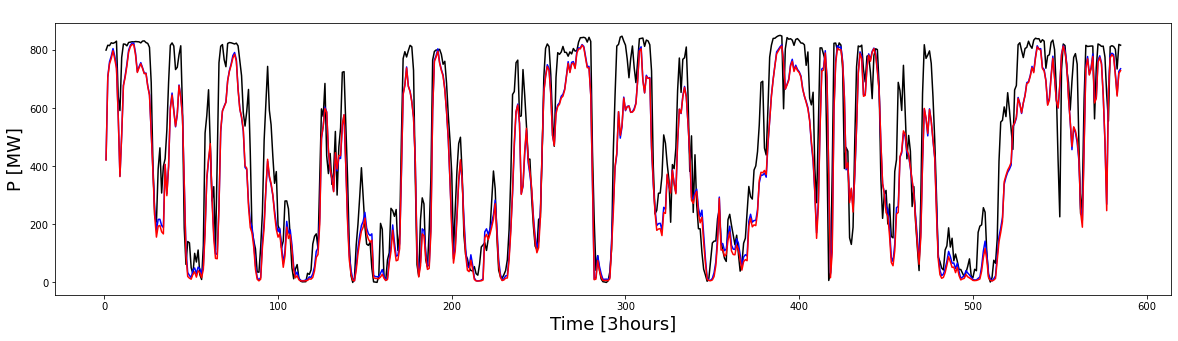

<IPython.core.display.Javascript object>

In [74]:
model_ap.load_weights("./models/model_1.h5")
predx9 = model_ap.predict([X_testl])

model_ap.load_weights("./models/model_2.h5")
predx4 = model_ap.predict([X_testl])

epochs = range(1, len(predx4) + 1)
# # plt.plot(epochs, acc, 'blue', label='Training acc')
# # plt.plot(epochs, val_acc, 'red', label='Validation acc')
# # plt.title('Training and validation accuracy')
# # plt.legend()
plt.figure(figsize=(20, 5))
plt.plot(epochs, y_test, "black", label="Obs")
plt.plot(epochs, predx9, "blue", label="Pred")
plt.plot(epochs, predx4, "red", label="Pred")
# plt.plot(epochs, dataframe, "magenta", label="nowcast")
# plt.plot(epochs, power_test["dayahead_3hr"], "pink", label="nowcast")


plt.xlabel("Time [3hours]", fontsize=18)
plt.ylabel("P [MW]", fontsize=18)
plt.title(" ")
# plt.legend()

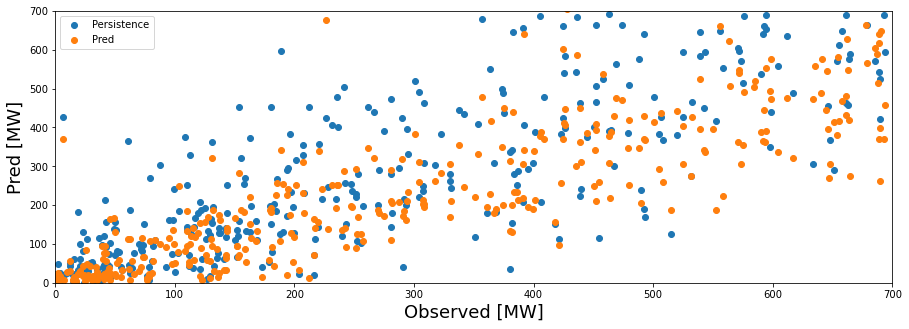

<IPython.core.display.Javascript object>

In [75]:
plt.figure(figsize=(15, 5))

plt.scatter(y_test, dataframe, label = 'Persistence')
plt.scatter(y_test, predx9,label = 'Pred')



plt.xlabel("Observed [MW]", fontsize=18)
plt.ylabel("Pred [MW]", fontsize=18)
plt.xlim([0, 700])
plt.ylim([0, 700])
plt.legend()


# Concatenate MLP LSTM

In [76]:
def split_series(series, y_series, n_past, n_future):
    #
    # n_past ==> no of past observations
    #
    # n_future ==> no of future observations
    #
    X, y = list(), list()
    for window_start in range(len(series)):
        past_end = window_start + n_past
        future_end = past_end + n_future
        if future_end > len(series):
            break
        # slicing the past and future parts of the window
        past, future = (
            series[window_start:past_end, :],
            y_series[past_end:future_end, :],
        )
        X.append(past)
        y.append(future)
    return np.array(X), np.array(y)

<IPython.core.display.Javascript object>

In [77]:
y_val.shape

(585, 1)

<IPython.core.display.Javascript object>

In [78]:
n_past = 4
n_future = 1

train_X_LSTM, train_y_LSTM = split_series(X_trainl,y_train, n_past, n_future)

[train_X_LSTM.shape, train_y_LSTM.shape]


[(4674, 4, 123), (4674, 1, 1)]

<IPython.core.display.Javascript object>

In [79]:
val_X_LSTM, val_y_LSTM = split_series(X_vall, y_val, n_past, n_future)

[val_X_LSTM.shape, val_y_LSTM.shape]


[(581, 4, 123), (581, 1, 1)]

<IPython.core.display.Javascript object>

In [80]:
train_X_MLP, train_y_MLP = (
    X_trainl[n_past:, :],
    y_train[n_past:, :],
)
[train_X_MLP.shape, train_y_MLP.shape]

[(4674, 123), (4674, 1)]

<IPython.core.display.Javascript object>

In [81]:
val_X_MLP, val_y_MLP = (
    X_vall[n_past:, :],
    y_val[n_past:, :],
)
[val_X_MLP.shape, val_y_MLP.shape]

[(581, 123), (581, 1)]

<IPython.core.display.Javascript object>

In [82]:
from tensorflow.keras.layers import Input, LSTM, Dense, Concatenate, Bidirectional
from tensorflow.keras.models import Model
from numpy.random import seed

seed(123)


import tensorflow

tensorflow.random.set_seed(123)

# lstm input shape
lstm_input = Input(shape=train_X_LSTM.shape[1:])
# lstm units
hidden1 = Bidirectional(LSTM(32))(lstm_input)
hidden2 = Dense(64)(hidden1)
hidden3 = Dense(128)(hidden2)
hidden4 = Dense(32, activation="relu")(hidden3)
# lstm output which will be predicted var1 at t=t
lstm_output = Dense(1, activation="relu")(hidden4)


# mlp input with additonal 3 variables at t=t
mlp_input = Input(shape=(train_X_MLP.shape[1]))
hidden1 = Dense(32, activation="relu", kernel_initializer="he_uniform")(mlp_input)
hidden2 = Dense(32, activation="relu", kernel_initializer="he_uniform")(hidden1)
hidden3 = Dense(64, activation="relu", kernel_initializer="he_uniform")(hidden2)
hidden4 = Dense(128, activation="relu", kernel_initializer="he_uniform")(hidden3)
hidden5 = Dense(256, activation="relu", kernel_initializer="he_uniform")(hidden4)
hidden6 = Dense(32, activation="relu", kernel_initializer="he_uniform")(hidden5)

# combine the lstm output which is predicted var1 at t=t and key in var2,var3,var4 at t=t
x = Concatenate()([lstm_output, hidden6])
# mlp model output which is predicted var1 at t=t
mlp_out = Dense(1)(x)
# final output of combined model which is predicted var1 at t=t
model = Model(inputs=[lstm_input, mlp_input], outputs=mlp_out)
# compile the model
model.compile(loss="mae", optimizer="adam")
# fit the model
# model.compile(
#     loss="mae",
#     optimizer=optimizers.Adam(
#         lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0
#     ),
# )


model.summary()

Model: "functional_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 123)]        0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 4, 123)]     0                                            
__________________________________________________________________________________________________
dense_22 (Dense)                (None, 32)           3968        input_5[0][0]                    
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, 64)           39936       input_4[0][0]                    
______________________________________________________________________________________

<IPython.core.display.Javascript object>

In [83]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Activation

from tensorflow.keras.callbacks import LearningRateScheduler
import math

from keras import backend as K
from keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger

import os

# import os

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import CSVLogger
from tensorflow.keras.callbacks import ModelCheckpoint

# os.environ["MK_NUM_THREADS"] = "20"
# os.environ["GOTO_NUM_THREADS"] = "20"
# os.environ["OMP_NUM_THREADS"] = "20"
# os.environ["openmp"] = "True"


# tf.config.threading.set_intra_op_parallelism_threads(20)


# model_best = tuner.get_best_models(num_models=1)[0]

config = tf.compat.v1.ConfigProto(
    intra_op_parallelism_threads=20,
    inter_op_parallelism_threads=20,
    allow_soft_placement=True,
)
session = tf.compat.v1.Session(config=config)
tf.compat.v1.keras.backend.set_session(session)

# OUTPUT_DIR  = os.path.join(PATH,"bcheneka" )
StrOut = "History_cnn_mlp.csv"
csv_logger = CSVLogger(StrOut, append=False, separator=";")

STR = "cnn_mlp.hdf5"

F = STR
ch = ModelCheckpoint(F, monitor="val_loss", save_best_only=True, mode="min", verbose=0)
es = EarlyStopping(monitor="val_loss", mode="min", patience=40, verbose=0)

import keras

# define step decay function
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.lr = []

    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get("loss"))
        self.lr.append(step_decay(len(self.losses)))
        print("lr:", step_decay(len(self.losses)))


def step_decay(epoch):
    initial_lrate = 0.001
    drop = 0.1
    epochs_drop = 5.0
    lrate = initial_lrate * math.pow(drop, math.floor((epoch) / epochs_drop))
    return lrate


# learning schedule callback
loss_history = LossHistory()
lrate = LearningRateScheduler(step_decay)


callbacks_list = [ch, es, csv_logger]

epochs = 1000

nb_train_samples = len(X_train)
nb_validation_samples = len(X_val)

batch_size = 64


history = model.fit(
    x=[train_X_LSTM, train_X_MLP],
    y=train_y_MLP,
    validation_data=([val_X_LSTM, val_X_MLP], val_y_MLP),
    epochs=epochs,
    batch_size=batch_size,
    callbacks=callbacks_list,
    verbose=1,
)
# K.clear_session()
# tf.compat.v1.reset_default_graph()
# tf.keras.backend.clear_session()

# print(OUTPUT_DIR)


Epoch 1/1000
74/74 [==============================] - 2s 33ms/step - loss: 149.0162 - val_loss: 156.3468
Epoch 2/1000
74/74 [==============================] - 1s 12ms/step - loss: 113.3143 - val_loss: 102.1034
Epoch 3/1000
74/74 [==============================] - 1s 11ms/step - loss: 109.3080 - val_loss: 86.0535
Epoch 4/1000
74/74 [==============================] - 1s 9ms/step - loss: 110.7627 - val_loss: 88.3090
Epoch 5/1000
74/74 [==============================] - 1s 10ms/step - loss: 109.8473 - val_loss: 145.0586
Epoch 6/1000
74/74 [==============================] - 1s 9ms/step - loss: 105.4893 - val_loss: 116.4936
Epoch 7/1000
74/74 [==============================] - 1s 9ms/step - loss: 103.5192 - val_loss: 106.3250
Epoch 8/1000
74/74 [==============================] - 1s 9ms/step - loss: 102.8835 - val_loss: 110.5195
Epoch 9/1000
74/74 [==============================] - 1s 9ms/step - loss: 101.4982 - val_loss: 134.6738
Epoch 10/1000
74/74 [==============================] - 1s 9ms/

74/74 [==============================] - 1s 8ms/step - loss: 95.5011 - val_loss: 83.9064
Epoch 81/1000
74/74 [==============================] - 1s 7ms/step - loss: 93.7864 - val_loss: 75.2743
Epoch 82/1000
74/74 [==============================] - 1s 8ms/step - loss: 93.5673 - val_loss: 86.5141
Epoch 83/1000
74/74 [==============================] - 1s 9ms/step - loss: 93.3479 - val_loss: 88.5147
Epoch 84/1000
74/74 [==============================] - 1s 7ms/step - loss: 92.9228 - val_loss: 76.6759
Epoch 85/1000
74/74 [==============================] - 1s 8ms/step - loss: 93.5138 - val_loss: 83.2458
Epoch 86/1000
74/74 [==============================] - 1s 8ms/step - loss: 93.9358 - val_loss: 81.3648
Epoch 87/1000
74/74 [==============================] - 1s 7ms/step - loss: 93.5515 - val_loss: 78.7211
Epoch 88/1000
74/74 [==============================] - 1s 7ms/step - loss: 94.2194 - val_loss: 87.6516
Epoch 89/1000
74/74 [==============================] - 1s 7ms/step - loss: 93.4963 - va

74/74 [==============================] - 1s 9ms/step - loss: 92.4209 - val_loss: 70.7430
Epoch 160/1000
74/74 [==============================] - 1s 8ms/step - loss: 94.0135 - val_loss: 71.2196
Epoch 161/1000
74/74 [==============================] - 1s 9ms/step - loss: 92.5417 - val_loss: 67.1960
Epoch 162/1000
74/74 [==============================] - 1s 8ms/step - loss: 93.3008 - val_loss: 75.7843
Epoch 163/1000
74/74 [==============================] - 1s 10ms/step - loss: 92.6944 - val_loss: 67.0985
Epoch 164/1000
74/74 [==============================] - 1s 9ms/step - loss: 94.6553 - val_loss: 70.2283
Epoch 165/1000
74/74 [==============================] - 1s 8ms/step - loss: 92.2948 - val_loss: 69.6455
Epoch 166/1000
74/74 [==============================] - 1s 8ms/step - loss: 94.2245 - val_loss: 79.2960
Epoch 167/1000
74/74 [==============================] - 1s 8ms/step - loss: 92.3679 - val_loss: 74.5233
Epoch 168/1000
74/74 [==============================] - 1s 8ms/step - loss: 92

<IPython.core.display.Javascript object>

In [84]:
[
    train_X_LSTM.shape,
    train_X_MLP.shape,
    train_y_MLP.shape,
    val_X_LSTM.shape,
    val_X_MLP.shape,
    val_y_MLP.shape,
]

[(4674, 4, 123), (4674, 123), (4674, 1), (581, 4, 123), (581, 123), (581, 1)]

<IPython.core.display.Javascript object>

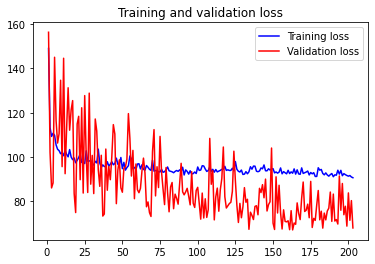

<IPython.core.display.Javascript object>

In [85]:
# # acc = history.history['loss']
# # val_acc = history.history['val_mean_squared_error']
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(loss) + 1)
# # plt.plot(epochs, acc, 'blue', label='Training acc')
# # plt.plot(epochs, val_acc, 'red', label='Validation acc')
# # plt.title('Training and validation accuracy')
# # plt.legend()
plt.figure()
plt.plot(epochs, loss, "blue", label="Training loss")
plt.plot(epochs, val_loss, "red", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.savefig("model_1_copy1_fine_stratify.png", bbox_inches="tight")
# , y_train.size, val.size(), y_val.size()]

In [86]:
[X_train_Ens.shape, y_train_Ens.shape]

[(5263, 6, 9, 1), (5263, 1)]

<IPython.core.display.Javascript object>

In [87]:
test_X_LSTM, test_y_LSTM = split_series(X_testl, y_test, n_past, n_future)

[test_X_LSTM.shape, test_y_LSTM.shape]

[(581, 4, 123), (581, 1, 1)]

<IPython.core.display.Javascript object>

In [88]:
test_X_MLP, test_y_MLP = (
    X_testl[n_past:, :],
    y_test[n_past:, :],
)
[test_X_MLP.shape, test_y_MLP.shape]

[(581, 123), (581, 1)]

<IPython.core.display.Javascript object>

In [89]:
predx = model.predict([test_X_LSTM, test_X_MLP])
predx.shape

(581, 1)

<IPython.core.display.Javascript object>

In [90]:
values = DataFrame(test_y_MLP)
dataframe = concat([values.shift(1)], axis=1)
dataframe.columns = ["t-1"]
# print(dataframe.head(5))
# dataframe.values[0]

values = DataFrame(test_y_MLP)
dataframe_2 = concat([values.shift(2)], axis=1)

# Error
Err_naive_1 = [(np.abs(dataframe - test_y_MLP)).mean()]
Err_naive_2 = [(np.abs(dataframe_2 - test_y_MLP)).mean()]

Err_pred = [(np.abs(DataFrame(predx) - test_y_MLP)).mean()]

# Err_nowcast = [(np.abs(DataFrame(power_test["nowcast_3hr"]) - test_y_MLP)).mean()]
# Err_dayahead = [(np.abs(DataFrame(power_test["dayahead_3hr"]) - test_y_MLP)).mean()]


[Err_naive_1, Err_naive_2, Err_pred, Err_nowcast, Err_dayahead]

[[t-1    80.046382
  dtype: float64],
 [0    133.374819
  dtype: float64],
 [0    75.422614
  dtype: float64],
 [nowcast_3hr    36.082942
  dtype: float64],
 [dayahead_3hr    52.406614
  dtype: float64]]

<IPython.core.display.Javascript object>

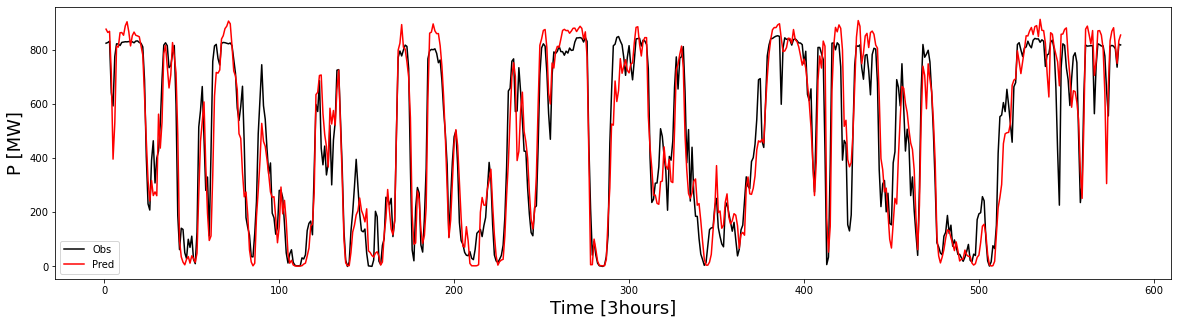

<IPython.core.display.Javascript object>

In [91]:
epochs = range(1, len(predx) + 1)

plt.figure(figsize=(20, 5))
plt.plot(epochs, test_y_MLP, "black", label="Obs")
# plt.plot(dataframe, "green", label="Naive")
plt.plot(epochs, predx, "red", label="Pred")


# plt.plot(epochs, np.abs(DataFrame(power_test["nowcast_3hr"])), "blue", label="Nowcast")
# plt.plot(epochs, np.abs(DataFrame(power_test["dayahead_3hr"])), "pink", label="Dayahead")


plt.xlabel("Time [3hours]", fontsize=18)
plt.ylabel("P [MW]", fontsize=18)
# plt.title("Training and validation loss")
plt.legend()

# MLP-LSTM multimodel

In [92]:
from tensorflow.keras.layers import Input, LSTM, Dense, Concatenate, Bidirectional
from tensorflow.keras.models import Model
from numpy.random import seed

seed(123)


import tensorflow

tensorflow.random.set_seed(123)

# lstm input shape
lstm_input = Input(shape=train_X_LSTM.shape[1:])
# lstm units
hidden1 = Bidirectional(LSTM(32))(lstm_input)
hidden2 = Dense(64)(hidden1)
hidden3 = Dense(128)(hidden2)
hidden4 = Dense(32, activation="relu")(hidden3)
# lstm output which will be predicted var1 at t=t
lstm_output = Dense(1, activation="relu")(hidden4)


# mlp input with additonal 3 variables at t=t
mlp_input = Input(shape=(train_X_MLP.shape[1]))
hidden1 = Dense(32, activation="relu", kernel_initializer="he_uniform")(mlp_input)
hidden2 = Dense(32, activation="relu", kernel_initializer="he_uniform")(hidden1)
hidden3 = Dense(64, activation="relu", kernel_initializer="he_uniform")(hidden2)
hidden4 = Dense(128, activation="relu", kernel_initializer="he_uniform")(hidden3)
hidden5 = Dense(256, activation="relu", kernel_initializer="he_uniform")(hidden4)
hidden6 = Dense(32, activation="relu", kernel_initializer="he_uniform")(hidden5)

# combine the lstm output which is predicted var1 at t=t and key in var2,var3,var4 at t=t
x = Concatenate()([lstm_output, hidden6])
# mlp model output which is predicted var1 at t=t
mlp_out = Dense(1)(x)
# final output of combined model which is predicted var1 at t=t
model = Model(inputs=[lstm_input, mlp_input], outputs=mlp_out)
# compile the model
model.compile(loss="mae", optimizer="adam")
# fit the model
# model.compile(
#     loss="mae",
#     optimizer=optimizers.Adam(
#         lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0
#     ),
# )


model.summary()

Model: "functional_13"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 123)]        0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, 4, 123)]     0                                            
__________________________________________________________________________________________________
dense_33 (Dense)                (None, 32)           3968        input_7[0][0]                    
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 64)           39936       input_6[0][0]                    
______________________________________________________________________________________

<IPython.core.display.Javascript object>

In [93]:
train_X_LSTM, train_y_LSTM = split_series(X_trainl_Ens,y_train_Ens, n_past, n_future)

[train_X_LSTM.shape, train_y_LSTM.shape]


[(5259, 4, 123), (5259, 1, 1)]

<IPython.core.display.Javascript object>

In [94]:
train_X_MLP, train_y_MLP = (
    X_trainl_Ens[n_past:, :],
    y_train_Ens[n_past:, :],
)
[train_X_MLP.shape, train_y_MLP.shape]

[(5259, 123), (5259, 1)]

<IPython.core.display.Javascript object>

In [95]:
# fit model on dataset
def fit_model(trainX, trainy, epochs, verbose):

    #     mlp_input = Input(shape=X_trainS.shape[1])

    #     hidden1 = Dense(32, activation="relu", kernel_initializer="he_uniform")(mlp_input)
    #     hidden2 = Dense(32, activation="relu", kernel_initializer="he_uniform")(hidden1)
    #     hidden3 = Dense(64, activation="relu", kernel_initializer="he_uniform")(hidden2)
    #     hidden4 = Dense(128, activation="relu", kernel_initializer="he_uniform")(hidden3)
    #     hidden5 = Dense(256, activation="relu", kernel_initializer="he_uniform")(hidden4)
    #     hidden6 = Dense(32, activation="relu", kernel_initializer="he_uniform")(hidden5)

    #     mlp_out = Dense(1)(hidden6)
    #     model_ap = Model(inputs=mlp_input, outputs=mlp_out)
    # con_cnn_mlp.compile(loss="mae", optimizer=optimizers.Adam(            lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0  ),    )
    model.compile(loss="mae", optimizer="adam")
    model.fit(
        [train_X_LSTM[train_index], train_X_MLP[train_index]],
        train_y_MLP[train_index],
        validation_data=(
            [train_X_LSTM[test_index], train_X_MLP[test_index]],
            train_y_MLP[test_index],
        ),
        epochs=epoch,
        batch_size=batch_size,
        callbacks=callbacks_list,
        verbose=1,
    )
    return model

<IPython.core.display.Javascript object>

In [96]:
[
    train_X_LSTM.shape,
    train_X_MLP.shape,
    train_y_MLP.shape,
    val_X_LSTM.shape,
    val_X_MLP.shape,
    val_y_MLP.shape,
]


[(5259, 4, 123), (5259, 123), (5259, 1), (581, 4, 123), (581, 123), (581, 1)]

<IPython.core.display.Javascript object>

In [97]:
# count=1
epoch = 1000
from sklearn.model_selection import TimeSeriesSplit

tscv = TimeSeriesSplit(n_splits=50)
count = 1
for train_index, test_index in tscv.split(train_X_MLP):
    # fit model
    model = fit_model(
        [train_X_LSTM[train_index], train_X_MLP[train_index]],
        train_y_MLP[train_index],
        epochs=epoch,
        verbose=1,
    )

    # save model
    filename = "models/model_" + str(count) + ".h5"
    model.save(filename)
    print(">Saved %s" % filename)
    count += 1

Epoch 1/1000
2/2 [==============================] - 1s 744ms/step - loss: 427.8595 - val_loss: 267.3355
Epoch 2/1000
2/2 [==============================] - 0s 18ms/step - loss: 334.3364 - val_loss: 225.1793
Epoch 3/1000
2/2 [==============================] - 0s 20ms/step - loss: 239.6639 - val_loss: 192.5364
Epoch 4/1000
2/2 [==============================] - 0s 21ms/step - loss: 155.5704 - val_loss: 190.1056
Epoch 5/1000
2/2 [==============================] - 0s 19ms/step - loss: 105.5083 - val_loss: 268.9416
Epoch 6/1000
2/2 [==============================] - 0s 20ms/step - loss: 165.1469 - val_loss: 268.2571
Epoch 7/1000
2/2 [==============================] - 0s 19ms/step - loss: 145.7145 - val_loss: 210.8164
Epoch 8/1000
2/2 [==============================] - 0s 21ms/step - loss: 100.9025 - val_loss: 188.9299
Epoch 9/1000
2/2 [==============================] - 0s 22ms/step - loss: 111.3959 - val_loss: 184.1299
Epoch 10/1000
2/2 [==============================] - 0s 19ms/step - loss

Epoch 160/1000
2/2 [==============================] - 0s 17ms/step - loss: 41.2170 - val_loss: 74.4289
Epoch 161/1000
2/2 [==============================] - 0s 17ms/step - loss: 42.0004 - val_loss: 75.3209
Epoch 162/1000
2/2 [==============================] - 0s 17ms/step - loss: 41.1296 - val_loss: 75.6722
Epoch 163/1000
2/2 [==============================] - 0s 16ms/step - loss: 44.5405 - val_loss: 75.1522
Epoch 164/1000
2/2 [==============================] - 0s 16ms/step - loss: 41.1511 - val_loss: 73.8526
Epoch 165/1000
2/2 [==============================] - 0s 16ms/step - loss: 42.3112 - val_loss: 72.9047
Epoch 166/1000
2/2 [==============================] - 0s 16ms/step - loss: 39.8218 - val_loss: 72.4118
Epoch 167/1000
2/2 [==============================] - 0s 24ms/step - loss: 39.9996 - val_loss: 71.1669
Epoch 168/1000
2/2 [==============================] - 0s 17ms/step - loss: 39.5541 - val_loss: 69.4623
Epoch 169/1000
2/2 [==============================] - 0s 17ms/step - loss

4/4 [==============================] - 0s 14ms/step - loss: 40.9276 - val_loss: 71.4292
Epoch 85/1000
4/4 [==============================] - 0s 13ms/step - loss: 43.8852 - val_loss: 70.5239
Epoch 86/1000
4/4 [==============================] - 0s 13ms/step - loss: 42.5132 - val_loss: 72.7949
Epoch 87/1000
4/4 [==============================] - 0s 12ms/step - loss: 41.1802 - val_loss: 67.3458
Epoch 88/1000
4/4 [==============================] - 0s 13ms/step - loss: 42.9212 - val_loss: 69.8804
Epoch 89/1000
4/4 [==============================] - 0s 14ms/step - loss: 41.5243 - val_loss: 72.8430
Epoch 90/1000
4/4 [==============================] - 0s 15ms/step - loss: 44.2534 - val_loss: 67.7148
Epoch 91/1000
4/4 [==============================] - 0s 15ms/step - loss: 41.9170 - val_loss: 69.1298
Epoch 92/1000
4/4 [==============================] - 0s 16ms/step - loss: 41.0811 - val_loss: 67.9972
>Saved models/model_2.h5
Epoch 1/1000
5/5 [==============================] - 2s 327ms/step - los

7/7 [==============================] - 0s 16ms/step - loss: 47.3229 - val_loss: 95.9202
Epoch 79/1000
7/7 [==============================] - 0s 15ms/step - loss: 45.3187 - val_loss: 94.1152
Epoch 80/1000
7/7 [==============================] - 0s 13ms/step - loss: 45.2857 - val_loss: 95.4719
Epoch 81/1000
7/7 [==============================] - 0s 12ms/step - loss: 43.4717 - val_loss: 94.3523
>Saved models/model_4.h5
Epoch 1/1000
9/9 [==============================] - 2s 176ms/step - loss: 69.8235 - val_loss: 98.8635
Epoch 2/1000
9/9 [==============================] - 0s 14ms/step - loss: 60.1927 - val_loss: 98.0138
Epoch 3/1000
9/9 [==============================] - 0s 12ms/step - loss: 60.3290 - val_loss: 97.1446
Epoch 4/1000
9/9 [==============================] - 0s 14ms/step - loss: 56.2954 - val_loss: 93.4852
Epoch 5/1000
9/9 [==============================] - 0s 12ms/step - loss: 53.1041 - val_loss: 94.4846
Epoch 6/1000
9/9 [==============================] - 0s 11ms/step - loss: 56

Epoch 16/1000
10/10 [==============================] - 0s 11ms/step - loss: 56.7322 - val_loss: 81.0431
Epoch 17/1000
10/10 [==============================] - 0s 10ms/step - loss: 56.0368 - val_loss: 84.2954
Epoch 18/1000
10/10 [==============================] - 0s 10ms/step - loss: 55.2230 - val_loss: 82.1582
Epoch 19/1000
10/10 [==============================] - 0s 11ms/step - loss: 56.0758 - val_loss: 80.9237
Epoch 20/1000
10/10 [==============================] - 0s 12ms/step - loss: 55.9751 - val_loss: 83.1363
Epoch 21/1000
10/10 [==============================] - 0s 11ms/step - loss: 55.2686 - val_loss: 80.0593
Epoch 22/1000
10/10 [==============================] - 0s 11ms/step - loss: 60.3684 - val_loss: 86.8332
Epoch 23/1000
10/10 [==============================] - 0s 12ms/step - loss: 56.7823 - val_loss: 84.9332
Epoch 24/1000
10/10 [==============================] - 0s 11ms/step - loss: 56.5854 - val_loss: 80.7611
Epoch 25/1000
10/10 [==============================] - 0s 11ms/s

13/13 [==============================] - 0s 12ms/step - loss: 61.3311 - val_loss: 162.1124
Epoch 38/1000
13/13 [==============================] - 0s 11ms/step - loss: 64.5072 - val_loss: 159.7565
Epoch 39/1000
13/13 [==============================] - 0s 12ms/step - loss: 67.4430 - val_loss: 166.0138
Epoch 40/1000
13/13 [==============================] - 0s 11ms/step - loss: 74.9915 - val_loss: 150.9239
Epoch 41/1000
13/13 [==============================] - 0s 11ms/step - loss: 64.8389 - val_loss: 165.0414
Epoch 42/1000
13/13 [==============================] - 0s 11ms/step - loss: 63.4155 - val_loss: 156.1055
Epoch 43/1000
13/13 [==============================] - 0s 12ms/step - loss: 64.9468 - val_loss: 159.6507
Epoch 44/1000
13/13 [==============================] - 0s 12ms/step - loss: 63.3814 - val_loss: 158.2780
Epoch 45/1000
13/13 [==============================] - 0s 13ms/step - loss: 62.1469 - val_loss: 154.6399
Epoch 46/1000
13/13 [==============================] - 0s 11ms/step -

15/15 [==============================] - 0s 11ms/step - loss: 68.9717 - val_loss: 190.7459
Epoch 56/1000
15/15 [==============================] - 0s 11ms/step - loss: 68.4708 - val_loss: 194.1067
Epoch 57/1000
15/15 [==============================] - 0s 10ms/step - loss: 67.7405 - val_loss: 194.3662
Epoch 58/1000
15/15 [==============================] - 0s 10ms/step - loss: 67.4108 - val_loss: 196.9319
Epoch 59/1000
15/15 [==============================] - 0s 11ms/step - loss: 66.2163 - val_loss: 197.1673
Epoch 60/1000
15/15 [==============================] - 0s 12ms/step - loss: 65.3926 - val_loss: 198.0281
Epoch 61/1000
15/15 [==============================] - 0s 10ms/step - loss: 65.6412 - val_loss: 193.8577
Epoch 62/1000
15/15 [==============================] - 0s 9ms/step - loss: 67.9399 - val_loss: 190.4201
Epoch 63/1000
15/15 [==============================] - 0s 8ms/step - loss: 65.8930 - val_loss: 198.9728
Epoch 64/1000
15/15 [==============================] - 0s 11ms/step - l

17/17 [==============================] - 0s 11ms/step - loss: 77.6677 - val_loss: 134.1156
Epoch 64/1000
17/17 [==============================] - 0s 11ms/step - loss: 76.0313 - val_loss: 133.4917
Epoch 65/1000
17/17 [==============================] - 0s 11ms/step - loss: 82.0027 - val_loss: 134.0844
Epoch 66/1000
17/17 [==============================] - 0s 11ms/step - loss: 76.9115 - val_loss: 134.4866
Epoch 67/1000
17/17 [==============================] - 0s 10ms/step - loss: 75.2330 - val_loss: 134.1649
Epoch 68/1000
17/17 [==============================] - 0s 9ms/step - loss: 75.3493 - val_loss: 136.2091
Epoch 69/1000
17/17 [==============================] - 0s 9ms/step - loss: 75.2490 - val_loss: 150.6398
Epoch 70/1000
17/17 [==============================] - 0s 9ms/step - loss: 75.9725 - val_loss: 135.0318
Epoch 71/1000
17/17 [==============================] - 0s 9ms/step - loss: 77.6394 - val_loss: 140.0882
Epoch 72/1000
17/17 [==============================] - 0s 9ms/step - loss

18/18 [==============================] - 0s 11ms/step - loss: 79.5676 - val_loss: 107.3527
Epoch 23/1000
18/18 [==============================] - 0s 10ms/step - loss: 77.4890 - val_loss: 107.6596
Epoch 24/1000
18/18 [==============================] - 0s 9ms/step - loss: 76.9292 - val_loss: 107.7579
Epoch 25/1000
18/18 [==============================] - 0s 11ms/step - loss: 76.6815 - val_loss: 106.5233
Epoch 26/1000
18/18 [==============================] - 0s 11ms/step - loss: 78.2531 - val_loss: 104.9698
Epoch 27/1000
18/18 [==============================] - 0s 11ms/step - loss: 77.7053 - val_loss: 107.5043
Epoch 28/1000
18/18 [==============================] - 0s 10ms/step - loss: 77.2650 - val_loss: 102.0069
Epoch 29/1000
18/18 [==============================] - 0s 10ms/step - loss: 76.3747 - val_loss: 104.6043
Epoch 30/1000
18/18 [==============================] - 0s 11ms/step - loss: 78.1760 - val_loss: 105.2670
Epoch 31/1000
18/18 [==============================] - 0s 10ms/step - 

22/22 [==============================] - 0s 10ms/step - loss: 82.8453 - val_loss: 173.0317
Epoch 40/1000
22/22 [==============================] - 0s 8ms/step - loss: 75.9506 - val_loss: 167.5284
Epoch 41/1000
22/22 [==============================] - 0s 9ms/step - loss: 75.8997 - val_loss: 179.7634
Epoch 42/1000
22/22 [==============================] - 0s 9ms/step - loss: 85.2452 - val_loss: 172.7557
Epoch 43/1000
22/22 [==============================] - 0s 11ms/step - loss: 78.5392 - val_loss: 162.5930
Epoch 44/1000
22/22 [==============================] - 0s 11ms/step - loss: 76.7289 - val_loss: 165.6194
Epoch 45/1000
22/22 [==============================] - 0s 9ms/step - loss: 74.8736 - val_loss: 171.1468
Epoch 46/1000
22/22 [==============================] - 0s 9ms/step - loss: 89.3604 - val_loss: 167.9581
Epoch 47/1000
22/22 [==============================] - 0s 10ms/step - loss: 86.4849 - val_loss: 162.7129
Epoch 48/1000
22/22 [==============================] - 0s 10ms/step - loss

25/25 [==============================] - 0s 10ms/step - loss: 66.9481 - val_loss: 88.9122
Epoch 54/1000
25/25 [==============================] - 0s 11ms/step - loss: 67.2497 - val_loss: 89.8479
Epoch 55/1000
25/25 [==============================] - 0s 10ms/step - loss: 69.5787 - val_loss: 89.3720
Epoch 56/1000
25/25 [==============================] - 0s 10ms/step - loss: 71.5018 - val_loss: 88.9376
Epoch 57/1000
25/25 [==============================] - 0s 9ms/step - loss: 68.2411 - val_loss: 90.5894
Epoch 58/1000
25/25 [==============================] - 0s 9ms/step - loss: 67.6414 - val_loss: 95.0544
Epoch 59/1000
25/25 [==============================] - 0s 10ms/step - loss: 75.7731 - val_loss: 91.3491
Epoch 60/1000
25/25 [==============================] - 0s 10ms/step - loss: 68.2226 - val_loss: 92.3281
Epoch 61/1000
25/25 [==============================] - 0s 9ms/step - loss: 66.2255 - val_loss: 90.0220
Epoch 62/1000
25/25 [==============================] - 0s 9ms/step - loss: 66.228

28/28 [==============================] - 0s 7ms/step - loss: 56.2249 - val_loss: 101.8256
Epoch 26/1000
28/28 [==============================] - 0s 8ms/step - loss: 56.4628 - val_loss: 112.4968
Epoch 27/1000
28/28 [==============================] - 0s 9ms/step - loss: 56.1419 - val_loss: 105.0849
Epoch 28/1000
28/28 [==============================] - 0s 10ms/step - loss: 56.6583 - val_loss: 105.0916
Epoch 29/1000
28/28 [==============================] - 0s 10ms/step - loss: 55.9404 - val_loss: 111.4263
Epoch 30/1000
28/28 [==============================] - 0s 10ms/step - loss: 54.0752 - val_loss: 109.1872
Epoch 31/1000
28/28 [==============================] - 0s 9ms/step - loss: 55.9140 - val_loss: 104.0911
Epoch 32/1000
28/28 [==============================] - 0s 9ms/step - loss: 57.1644 - val_loss: 105.3185
Epoch 33/1000
28/28 [==============================] - 0s 8ms/step - loss: 58.1542 - val_loss: 115.2981
Epoch 34/1000
28/28 [==============================] - 0s 9ms/step - loss: 

31/31 [==============================] - 0s 12ms/step - loss: 52.9908 - val_loss: 98.8403
Epoch 37/1000
31/31 [==============================] - 0s 9ms/step - loss: 48.4673 - val_loss: 103.5898
Epoch 38/1000
31/31 [==============================] - 0s 10ms/step - loss: 45.2587 - val_loss: 96.2934
Epoch 39/1000
31/31 [==============================] - 0s 9ms/step - loss: 46.2552 - val_loss: 105.5927
Epoch 40/1000
31/31 [==============================] - 0s 9ms/step - loss: 46.7648 - val_loss: 107.5291
Epoch 41/1000
31/31 [==============================] - 0s 9ms/step - loss: 50.0844 - val_loss: 102.8742
Epoch 42/1000
31/31 [==============================] - 0s 9ms/step - loss: 49.3109 - val_loss: 100.7575
Epoch 43/1000
31/31 [==============================] - 0s 8ms/step - loss: 45.2965 - val_loss: 100.6870
Epoch 44/1000
31/31 [==============================] - 0s 9ms/step - loss: 46.4479 - val_loss: 103.9445
Epoch 45/1000
31/31 [==============================] - 0s 9ms/step - loss: 47.

36/36 [==============================] - 0s 10ms/step - loss: 43.8585 - val_loss: 133.3219
Epoch 8/1000
36/36 [==============================] - 0s 10ms/step - loss: 42.3249 - val_loss: 138.5167
Epoch 9/1000
36/36 [==============================] - 0s 11ms/step - loss: 42.9853 - val_loss: 143.2516
Epoch 10/1000
36/36 [==============================] - 0s 10ms/step - loss: 43.2563 - val_loss: 143.4544
Epoch 11/1000
36/36 [==============================] - 0s 10ms/step - loss: 44.6304 - val_loss: 132.1842
Epoch 12/1000
36/36 [==============================] - 0s 9ms/step - loss: 43.1869 - val_loss: 141.5470
Epoch 13/1000
36/36 [==============================] - 0s 9ms/step - loss: 39.9643 - val_loss: 136.4807
Epoch 14/1000
36/36 [==============================] - 0s 10ms/step - loss: 41.1459 - val_loss: 137.3727
Epoch 15/1000
36/36 [==============================] - 0s 10ms/step - loss: 39.5062 - val_loss: 136.6107
Epoch 16/1000
36/36 [==============================] - 0s 9ms/step - loss

Epoch 52/1000
38/38 [==============================] - 0s 8ms/step - loss: 36.0320 - val_loss: 80.3586
Epoch 53/1000
38/38 [==============================] - 0s 8ms/step - loss: 35.1871 - val_loss: 74.8773
Epoch 54/1000
38/38 [==============================] - 0s 9ms/step - loss: 32.8346 - val_loss: 80.1201
Epoch 55/1000
38/38 [==============================] - 0s 9ms/step - loss: 33.9143 - val_loss: 82.4060
Epoch 56/1000
38/38 [==============================] - 0s 11ms/step - loss: 41.5248 - val_loss: 76.4061
Epoch 57/1000
38/38 [==============================] - 0s 10ms/step - loss: 37.0592 - val_loss: 81.1189
Epoch 58/1000
38/38 [==============================] - 0s 10ms/step - loss: 31.7958 - val_loss: 79.5956
Epoch 59/1000
38/38 [==============================] - 0s 9ms/step - loss: 33.9851 - val_loss: 75.7392
Epoch 60/1000
38/38 [==============================] - 0s 9ms/step - loss: 33.0959 - val_loss: 82.5145
Epoch 61/1000
38/38 [==============================] - 0s 9ms/step - l

Epoch 17/1000
39/39 [==============================] - 0s 11ms/step - loss: 30.4411 - val_loss: 152.8775
Epoch 18/1000
39/39 [==============================] - 0s 10ms/step - loss: 33.7273 - val_loss: 155.1834
Epoch 19/1000
39/39 [==============================] - 0s 9ms/step - loss: 32.9672 - val_loss: 156.0363
Epoch 20/1000
39/39 [==============================] - 0s 10ms/step - loss: 30.6845 - val_loss: 157.8190
Epoch 21/1000
39/39 [==============================] - 0s 10ms/step - loss: 33.1912 - val_loss: 152.9282
Epoch 22/1000
39/39 [==============================] - 0s 10ms/step - loss: 29.6891 - val_loss: 149.9166
Epoch 23/1000
39/39 [==============================] - 0s 12ms/step - loss: 30.7243 - val_loss: 152.7239
Epoch 24/1000
39/39 [==============================] - 0s 11ms/step - loss: 30.2550 - val_loss: 154.1401
Epoch 25/1000
39/39 [==============================] - 0s 10ms/step - loss: 31.2340 - val_loss: 157.0501
Epoch 26/1000
39/39 [==============================] - 0

41/41 [==============================] - 0s 10ms/step - loss: 27.7606 - val_loss: 126.9955
Epoch 74/1000
41/41 [==============================] - 0s 9ms/step - loss: 27.3711 - val_loss: 117.8456
Epoch 75/1000
41/41 [==============================] - 0s 9ms/step - loss: 29.0872 - val_loss: 130.5601
Epoch 76/1000
41/41 [==============================] - 0s 10ms/step - loss: 30.1291 - val_loss: 119.0726
Epoch 77/1000
41/41 [==============================] - 0s 10ms/step - loss: 25.5349 - val_loss: 120.4294
Epoch 78/1000
41/41 [==============================] - 0s 9ms/step - loss: 26.9500 - val_loss: 118.3208
Epoch 79/1000
41/41 [==============================] - 0s 9ms/step - loss: 26.6573 - val_loss: 127.6208
Epoch 80/1000
41/41 [==============================] - 0s 11ms/step - loss: 26.7788 - val_loss: 124.7608
Epoch 81/1000
41/41 [==============================] - 0s 10ms/step - loss: 24.0579 - val_loss: 129.6103
Epoch 82/1000
41/41 [==============================] - 0s 9ms/step - loss

46/46 [==============================] - 0s 10ms/step - loss: 26.6608 - val_loss: 95.0600
Epoch 41/1000
46/46 [==============================] - 0s 11ms/step - loss: 26.4716 - val_loss: 90.5967
Epoch 42/1000
46/46 [==============================] - 0s 10ms/step - loss: 26.4123 - val_loss: 90.4517
Epoch 43/1000
46/46 [==============================] - 0s 9ms/step - loss: 29.0890 - val_loss: 89.9076
Epoch 44/1000
46/46 [==============================] - 0s 9ms/step - loss: 27.0667 - val_loss: 90.6889
Epoch 45/1000
46/46 [==============================] - 0s 11ms/step - loss: 29.3948 - val_loss: 87.6284
Epoch 46/1000
46/46 [==============================] - 0s 11ms/step - loss: 28.0310 - val_loss: 91.6506
Epoch 47/1000
46/46 [==============================] - 0s 11ms/step - loss: 25.0099 - val_loss: 94.6817
Epoch 48/1000
46/46 [==============================] - 0s 10ms/step - loss: 27.7554 - val_loss: 92.9108
Epoch 49/1000
46/46 [==============================] - 0s 9ms/step - loss: 26.67

Epoch 1/1000
49/49 [==============================] - 2s 33ms/step - loss: 30.2954 - val_loss: 72.5921
Epoch 2/1000
49/49 [==============================] - 0s 9ms/step - loss: 28.8577 - val_loss: 72.4505
Epoch 3/1000
49/49 [==============================] - 0s 9ms/step - loss: 27.4501 - val_loss: 69.4176
Epoch 4/1000
49/49 [==============================] - 0s 10ms/step - loss: 26.6985 - val_loss: 74.5675
Epoch 5/1000
49/49 [==============================] - 0s 10ms/step - loss: 28.8410 - val_loss: 68.1521
Epoch 6/1000
49/49 [==============================] - 0s 10ms/step - loss: 28.8562 - val_loss: 73.7535
Epoch 7/1000
49/49 [==============================] - 0s 10ms/step - loss: 26.1037 - val_loss: 71.5356
Epoch 8/1000
49/49 [==============================] - 1s 10ms/step - loss: 27.2375 - val_loss: 73.8262
Epoch 9/1000
49/49 [==============================] - 0s 10ms/step - loss: 26.3088 - val_loss: 74.1501
Epoch 10/1000
49/49 [==============================] - 0s 9ms/step - loss: 

50/50 [==============================] - 0s 10ms/step - loss: 21.7896 - val_loss: 124.1949
Epoch 78/1000
50/50 [==============================] - 1s 10ms/step - loss: 19.8166 - val_loss: 131.4545
Epoch 79/1000
50/50 [==============================] - 1s 11ms/step - loss: 20.2030 - val_loss: 130.0348
Epoch 80/1000
50/50 [==============================] - 0s 10ms/step - loss: 20.6299 - val_loss: 130.0409
Epoch 81/1000
50/50 [==============================] - 1s 12ms/step - loss: 22.8346 - val_loss: 136.3344
Epoch 82/1000
50/50 [==============================] - 1s 12ms/step - loss: 21.6122 - val_loss: 141.1761
Epoch 83/1000
50/50 [==============================] - 1s 11ms/step - loss: 21.3732 - val_loss: 131.1420
Epoch 84/1000
50/50 [==============================] - 0s 10ms/step - loss: 20.7762 - val_loss: 130.6099
Epoch 85/1000
50/50 [==============================] - 0s 10ms/step - loss: 23.7620 - val_loss: 130.9664
Epoch 86/1000
50/50 [==============================] - 0s 10ms/step -

Epoch 58/1000
52/52 [==============================] - 1s 11ms/step - loss: 22.0560 - val_loss: 124.0244
>Saved models/model_32.h5
Epoch 1/1000
54/54 [==============================] - 1s 24ms/step - loss: 29.8142 - val_loss: 125.9362
Epoch 2/1000
54/54 [==============================] - 0s 4ms/step - loss: 25.0533 - val_loss: 129.4122
Epoch 3/1000
54/54 [==============================] - 0s 4ms/step - loss: 27.3515 - val_loss: 131.9279
Epoch 4/1000
54/54 [==============================] - 0s 4ms/step - loss: 27.5785 - val_loss: 129.2401
Epoch 5/1000
54/54 [==============================] - 0s 4ms/step - loss: 24.5846 - val_loss: 131.8652
Epoch 6/1000
54/54 [==============================] - 0s 4ms/step - loss: 25.3291 - val_loss: 127.0155
Epoch 7/1000
54/54 [==============================] - 0s 4ms/step - loss: 24.0935 - val_loss: 126.5790
Epoch 8/1000
54/54 [==============================] - 0s 4ms/step - loss: 25.7022 - val_loss: 129.9897
Epoch 9/1000
54/54 [========================

55/55 [==============================] - 1s 9ms/step - loss: 22.4829 - val_loss: 137.3646
Epoch 26/1000
55/55 [==============================] - 0s 9ms/step - loss: 24.5514 - val_loss: 127.8750
Epoch 27/1000
55/55 [==============================] - 1s 10ms/step - loss: 23.3565 - val_loss: 124.0035
Epoch 28/1000
55/55 [==============================] - 1s 11ms/step - loss: 25.9258 - val_loss: 134.6316
Epoch 29/1000
55/55 [==============================] - 1s 10ms/step - loss: 24.1204 - val_loss: 149.0907
Epoch 30/1000
55/55 [==============================] - 1s 9ms/step - loss: 24.9594 - val_loss: 116.2459
Epoch 31/1000
55/55 [==============================] - 1s 9ms/step - loss: 24.1628 - val_loss: 136.1541
Epoch 32/1000
55/55 [==============================] - 1s 9ms/step - loss: 23.9540 - val_loss: 122.7864
Epoch 33/1000
55/55 [==============================] - 1s 10ms/step - loss: 24.8490 - val_loss: 133.9716
Epoch 34/1000
55/55 [==============================] - 1s 10ms/step - loss

59/59 [==============================] - 1s 9ms/step - loss: 27.0886 - val_loss: 122.7218
Epoch 31/1000
59/59 [==============================] - 0s 8ms/step - loss: 27.1685 - val_loss: 133.6054
Epoch 32/1000
59/59 [==============================] - 0s 7ms/step - loss: 34.8868 - val_loss: 125.2634
Epoch 33/1000
59/59 [==============================] - 0s 7ms/step - loss: 28.8647 - val_loss: 116.4432
Epoch 34/1000
59/59 [==============================] - 0s 8ms/step - loss: 24.9733 - val_loss: 125.8751
Epoch 35/1000
59/59 [==============================] - 0s 8ms/step - loss: 29.9693 - val_loss: 121.2238
Epoch 36/1000
59/59 [==============================] - 0s 8ms/step - loss: 25.5888 - val_loss: 116.0106
Epoch 37/1000
59/59 [==============================] - 0s 8ms/step - loss: 24.9621 - val_loss: 126.6944
Epoch 38/1000
59/59 [==============================] - 1s 9ms/step - loss: 32.5773 - val_loss: 121.9680
Epoch 39/1000
59/59 [==============================] - 1s 9ms/step - loss: 26.

Epoch 109/1000
59/59 [==============================] - 1s 9ms/step - loss: 26.2428 - val_loss: 128.8501
Epoch 110/1000
59/59 [==============================] - 1s 9ms/step - loss: 53.1093 - val_loss: 121.8444
Epoch 111/1000
59/59 [==============================] - 0s 8ms/step - loss: 31.8583 - val_loss: 124.4112
Epoch 112/1000
59/59 [==============================] - 0s 8ms/step - loss: 25.4704 - val_loss: 116.1016
Epoch 113/1000
59/59 [==============================] - 1s 9ms/step - loss: 23.6777 - val_loss: 123.1400
Epoch 114/1000
59/59 [==============================] - 1s 9ms/step - loss: 37.5755 - val_loss: 118.4066
Epoch 115/1000
59/59 [==============================] - 1s 9ms/step - loss: 28.2986 - val_loss: 113.4081
Epoch 116/1000
59/59 [==============================] - 0s 8ms/step - loss: 22.8936 - val_loss: 120.7459
Epoch 117/1000
59/59 [==============================] - 0s 8ms/step - loss: 23.3556 - val_loss: 121.0130
Epoch 118/1000
59/59 [==============================] -

Epoch 32/1000
60/60 [==============================] - 1s 10ms/step - loss: 21.1527 - val_loss: 131.7349
Epoch 33/1000
60/60 [==============================] - 1s 11ms/step - loss: 21.1345 - val_loss: 121.8666
Epoch 34/1000
60/60 [==============================] - 1s 10ms/step - loss: 19.1254 - val_loss: 121.0239
Epoch 35/1000
60/60 [==============================] - 1s 10ms/step - loss: 21.6019 - val_loss: 131.6879
Epoch 36/1000
60/60 [==============================] - 1s 9ms/step - loss: 20.4304 - val_loss: 126.1892
Epoch 37/1000
60/60 [==============================] - 1s 10ms/step - loss: 20.0728 - val_loss: 130.4652
Epoch 38/1000
60/60 [==============================] - 1s 10ms/step - loss: 20.8045 - val_loss: 125.7970
Epoch 39/1000
60/60 [==============================] - 1s 9ms/step - loss: 20.0290 - val_loss: 128.6502
Epoch 40/1000
60/60 [==============================] - 0s 8ms/step - loss: 21.8918 - val_loss: 129.7181
Epoch 41/1000
60/60 [==============================] - 1s 

65/65 [==============================] - 0s 7ms/step - loss: 22.8849 - val_loss: 145.2314
Epoch 33/1000
65/65 [==============================] - 0s 7ms/step - loss: 23.2569 - val_loss: 143.3864
Epoch 34/1000
65/65 [==============================] - 1s 9ms/step - loss: 24.8692 - val_loss: 136.4771
Epoch 35/1000
65/65 [==============================] - 1s 9ms/step - loss: 23.0764 - val_loss: 133.7813
Epoch 36/1000
65/65 [==============================] - 1s 9ms/step - loss: 23.1208 - val_loss: 136.9795
Epoch 37/1000
65/65 [==============================] - 1s 9ms/step - loss: 22.3392 - val_loss: 135.3665
Epoch 38/1000
65/65 [==============================] - 1s 9ms/step - loss: 24.9589 - val_loss: 136.6794
Epoch 39/1000
65/65 [==============================] - 1s 8ms/step - loss: 25.0882 - val_loss: 135.9622
Epoch 40/1000
65/65 [==============================] - 1s 8ms/step - loss: 21.0813 - val_loss: 142.0701
Epoch 41/1000
65/65 [==============================] - 1s 8ms/step - loss: 21.

70/70 [==============================] - 1s 9ms/step - loss: 23.7837 - val_loss: 135.5925
Epoch 13/1000
70/70 [==============================] - 1s 9ms/step - loss: 25.4877 - val_loss: 147.0736
Epoch 14/1000
70/70 [==============================] - 1s 9ms/step - loss: 23.4500 - val_loss: 141.2896
Epoch 15/1000
70/70 [==============================] - 1s 9ms/step - loss: 24.5637 - val_loss: 136.3009
Epoch 16/1000
70/70 [==============================] - 1s 8ms/step - loss: 23.9042 - val_loss: 132.3251
Epoch 17/1000
70/70 [==============================] - 1s 9ms/step - loss: 24.9883 - val_loss: 142.0090
Epoch 18/1000
70/70 [==============================] - 1s 9ms/step - loss: 22.8057 - val_loss: 138.0587
Epoch 19/1000
70/70 [==============================] - 1s 9ms/step - loss: 22.9433 - val_loss: 135.2603
Epoch 20/1000
70/70 [==============================] - 1s 9ms/step - loss: 23.5239 - val_loss: 137.5108
Epoch 21/1000
70/70 [==============================] - 1s 8ms/step - loss: 22.

73/73 [==============================] - 1s 7ms/step - loss: 22.9730 - val_loss: 108.9658
Epoch 35/1000
73/73 [==============================] - 1s 7ms/step - loss: 22.7226 - val_loss: 110.3965
Epoch 36/1000
73/73 [==============================] - 1s 7ms/step - loss: 22.2327 - val_loss: 110.0662
Epoch 37/1000
73/73 [==============================] - 1s 7ms/step - loss: 22.2545 - val_loss: 113.8683
Epoch 38/1000
73/73 [==============================] - 1s 8ms/step - loss: 22.0273 - val_loss: 109.9074
Epoch 39/1000
73/73 [==============================] - 1s 7ms/step - loss: 23.8428 - val_loss: 110.7810
Epoch 40/1000
73/73 [==============================] - 1s 7ms/step - loss: 21.7008 - val_loss: 112.1790
Epoch 41/1000
73/73 [==============================] - 1s 7ms/step - loss: 20.5889 - val_loss: 114.2165
Epoch 42/1000
73/73 [==============================] - 1s 7ms/step - loss: 22.1247 - val_loss: 105.3409
Epoch 43/1000
73/73 [==============================] - 1s 8ms/step - loss: 21.

Epoch 109/1000
75/75 [==============================] - 1s 7ms/step - loss: 19.1077 - val_loss: 107.6350
Epoch 110/1000
75/75 [==============================] - 1s 8ms/step - loss: 20.8878 - val_loss: 102.1937
Epoch 111/1000
75/75 [==============================] - 1s 7ms/step - loss: 20.5530 - val_loss: 99.0715
Epoch 112/1000
75/75 [==============================] - 1s 7ms/step - loss: 20.9927 - val_loss: 106.8291
Epoch 113/1000
75/75 [==============================] - 1s 7ms/step - loss: 18.9809 - val_loss: 104.5788
Epoch 114/1000
75/75 [==============================] - 1s 7ms/step - loss: 19.5235 - val_loss: 109.1875
Epoch 115/1000
75/75 [==============================] - 1s 7ms/step - loss: 20.2935 - val_loss: 106.9059
Epoch 116/1000
75/75 [==============================] - 1s 7ms/step - loss: 19.8634 - val_loss: 106.1467
Epoch 117/1000
75/75 [==============================] - 1s 8ms/step - loss: 22.0373 - val_loss: 101.4124
Epoch 118/1000
75/75 [==============================] - 

78/78 [==============================] - 1s 9ms/step - loss: 19.8181 - val_loss: 107.0870
Epoch 59/1000
78/78 [==============================] - 1s 9ms/step - loss: 19.3416 - val_loss: 102.2934
Epoch 60/1000
78/78 [==============================] - 1s 9ms/step - loss: 20.7415 - val_loss: 106.4318
Epoch 61/1000
78/78 [==============================] - 1s 9ms/step - loss: 20.7862 - val_loss: 114.2285
Epoch 62/1000
78/78 [==============================] - 1s 9ms/step - loss: 21.0826 - val_loss: 108.7809
Epoch 63/1000
78/78 [==============================] - 1s 10ms/step - loss: 20.2415 - val_loss: 108.6302
Epoch 64/1000
78/78 [==============================] - 1s 9ms/step - loss: 20.0027 - val_loss: 117.5243
Epoch 65/1000
78/78 [==============================] - 1s 9ms/step - loss: 20.1707 - val_loss: 109.1946
Epoch 66/1000
78/78 [==============================] - 1s 9ms/step - loss: 20.0175 - val_loss: 109.0718
Epoch 67/1000
78/78 [==============================] - 1s 9ms/step - loss: 18

81/81 [==============================] - 1s 9ms/step - loss: 20.5623 - val_loss: 186.2853
Epoch 6/1000
81/81 [==============================] - 1s 9ms/step - loss: 20.4423 - val_loss: 183.2612
Epoch 7/1000
81/81 [==============================] - 1s 9ms/step - loss: 20.6654 - val_loss: 183.9444
Epoch 8/1000
81/81 [==============================] - 1s 9ms/step - loss: 20.6288 - val_loss: 186.2343
Epoch 9/1000
81/81 [==============================] - 1s 9ms/step - loss: 19.8970 - val_loss: 179.0873
Epoch 10/1000
81/81 [==============================] - 1s 9ms/step - loss: 20.1825 - val_loss: 195.3572
Epoch 11/1000
81/81 [==============================] - 1s 9ms/step - loss: 21.1007 - val_loss: 184.2677
Epoch 12/1000
81/81 [==============================] - 1s 9ms/step - loss: 20.5288 - val_loss: 191.8430
Epoch 13/1000
81/81 [==============================] - 1s 9ms/step - loss: 19.9547 - val_loss: 187.6337
Epoch 14/1000
81/81 [==============================] - 1s 9ms/step - loss: 17.8338

Epoch 84/1000
81/81 [==============================] - 1s 8ms/step - loss: 17.6321 - val_loss: 184.2551
Epoch 85/1000
81/81 [==============================] - 1s 8ms/step - loss: 17.1180 - val_loss: 178.7340
Epoch 86/1000
81/81 [==============================] - 1s 7ms/step - loss: 18.2380 - val_loss: 191.3925
Epoch 87/1000
81/81 [==============================] - 1s 9ms/step - loss: 18.2810 - val_loss: 188.4722
Epoch 88/1000
81/81 [==============================] - 1s 8ms/step - loss: 17.0761 - val_loss: 182.8531
Epoch 89/1000
81/81 [==============================] - 1s 8ms/step - loss: 17.4030 - val_loss: 182.9958
Epoch 90/1000
81/81 [==============================] - 1s 8ms/step - loss: 16.7176 - val_loss: 180.5633
Epoch 91/1000
81/81 [==============================] - 1s 8ms/step - loss: 17.3540 - val_loss: 179.8274
Epoch 92/1000
81/81 [==============================] - 1s 8ms/step - loss: 19.4477 - val_loss: 181.3183
Epoch 93/1000
81/81 [==============================] - 1s 8ms/st

<IPython.core.display.Javascript object>

In [103]:
# load models from file
from keras.models import load_model


def load_all_models(n_models):
    all_models = list()
    for i in range(n_models):
        # define filename for this ensemble
        filename = "models/model_" + str(i + 1) + ".h5"
        # load model from file
        model = load_model(filename)
        # add to list of members
        all_models.append(model)
        print(">loaded %s" % filename)
    return all_models


# load all models
n_members = 50
members = load_all_models(n_members)
print("Loaded %d models" % len(members))

>loaded models/model_1.h5
>loaded models/model_2.h5
>loaded models/model_3.h5
>loaded models/model_4.h5
>loaded models/model_5.h5
>loaded models/model_6.h5
>loaded models/model_7.h5
>loaded models/model_8.h5
>loaded models/model_9.h5
>loaded models/model_10.h5
>loaded models/model_11.h5
>loaded models/model_12.h5
>loaded models/model_13.h5
>loaded models/model_14.h5
>loaded models/model_15.h5
>loaded models/model_16.h5
>loaded models/model_17.h5
>loaded models/model_18.h5
>loaded models/model_19.h5
>loaded models/model_20.h5
>loaded models/model_21.h5
>loaded models/model_22.h5
>loaded models/model_23.h5
>loaded models/model_24.h5
>loaded models/model_25.h5
>loaded models/model_26.h5
>loaded models/model_27.h5
>loaded models/model_28.h5
>loaded models/model_29.h5
>loaded models/model_30.h5
>loaded models/model_31.h5
>loaded models/model_32.h5
>loaded models/model_33.h5
>loaded models/model_34.h5
>loaded models/model_35.h5
>loaded models/model_36.h5
>loaded models/model_37.h5
>loaded mo

<IPython.core.display.Javascript object>

In [104]:
for model in members:
    mae = model.evaluate([test_X_LSTM, test_X_MLP], test_y_MLP, verbose=0)
    print("Model MAE: %.3f" % mae)

Model MAE: 181.643
Model MAE: 189.543
Model MAE: 216.883
Model MAE: 200.605
Model MAE: 203.679
Model MAE: 205.193
Model MAE: 189.285
Model MAE: 223.581
Model MAE: 199.756
Model MAE: 214.670
Model MAE: 221.230
Model MAE: 246.322
Model MAE: 233.595
Model MAE: 193.082
Model MAE: 203.039
Model MAE: 229.811
Model MAE: 246.100
Model MAE: 255.768
Model MAE: 241.051
Model MAE: 234.750
Model MAE: 243.462
Model MAE: 237.325
Model MAE: 244.763
Model MAE: 243.962
Model MAE: 217.161
Model MAE: 222.045
Model MAE: 222.946
Model MAE: 221.361
Model MAE: 219.640
Model MAE: 213.278
Model MAE: 218.516
Model MAE: 206.890
Model MAE: 212.044
Model MAE: 197.831
Model MAE: 202.908
Model MAE: 210.667
Model MAE: 202.803
Model MAE: 193.438
Model MAE: 193.505
Model MAE: 183.419
Model MAE: 195.235
Model MAE: 184.610
Model MAE: 192.365
Model MAE: 177.741
Model MAE: 186.714
Model MAE: 164.593
Model MAE: 173.351
Model MAE: 168.121
Model MAE: 170.902
Model MAE: 166.578


<IPython.core.display.Javascript object>

In [497]:
# define input sequence
raw_seq = [10, 20, 30, 40, 50, 60, 70, 80, 90]

# choose a number of time steps
n_steps = 8

# split into samples
X, y = split_sequence(cc, n_steps)
[X.shape, y.shape]

NameError: name 'split_sequence' is not defined

<IPython.core.display.Javascript object>

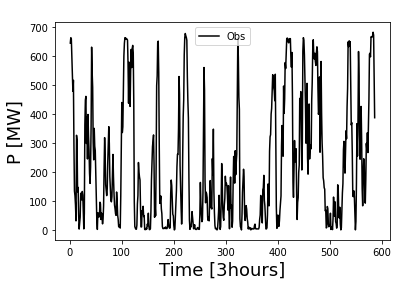

<IPython.core.display.Javascript object>

In [176]:
#X_train, X_val, y_train, y_val = train_test_split(x, power, test_size=0.10,random_state=123)
X_train.shape
epochs = range(1, len(y_val) + 1)
# # plt.plot(epochs, acc, 'blue', label='Training acc')
# # plt.plot(epochs, val_acc, 'red', label='Validation acc')
# # plt.title('Training and validation accuracy')
# # plt.legend()
plt.figure()
plt.plot(epochs, y_val, "black", label="Obs")
# plt.plot(epochs, predictions_1, "red", label="Pred")
# plt.plot(epochs, dataframe, "blue", label="Naive")
plt.xlabel("Time [3hours]", fontsize=18)
plt.ylabel("P [MW]", fontsize=18)
plt.title(" ")
plt.legend()


In [51]:
# https://stackoverflow.com/questions/58948739/reshaping-images-for-input-into-keras-timedistributed-function


n_input = 4
n_output = 2
batchsize = 8
from keras.preprocessing.sequence import TimeseriesGenerator

# from time_series_generator import TimeseriesGenerator

train_sequences = TimeseriesGenerator(
    X_train, y_train, length=n_input, batch_size=batchsize
)
test_sequences = TimeseriesGenerator(X_val, y_val, length=n_input, batch_size=batchsize)
# sanity check
batch_x, batch_y = test_sequences[0]
(batch_y).shape
# len(test_sequences)
test_sequences[1][1]

array([[326.20583333],
       [309.205     ],
       [131.485     ],
       [146.63166667],
       [ 55.97166667],
       [  2.93      ],
       [ 26.06916667],
       [ 44.25416667]])

<IPython.core.display.Javascript object>

In [52]:
# define dataset
series = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
target = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
# define generator
# n_input = 3
# n_output = 3
generator = TimeseriesGenerator(series, target, length=n_input, batch_size=1)
# print each sample
for i in range(len(generator)):
    x, y = generator[i]
    print("%s => %s" % (x, y))
batch_x, batch_y = generator[0]
(batch_x).shape

[[1 2 3 4]] => [5]
[[2 3 4 5]] => [6]
[[3 4 5 6]] => [7]
[[4 5 6 7]] => [8]
[[5 6 7 8]] => [9]
[[6 7 8 9]] => [10]


(1, 4)

<IPython.core.display.Javascript object>

In [53]:
from keras import layers, models, optimizers
from keras.utils.vis_utils import plot_model
from keras.layers import TimeDistributed
from keras.layers import LSTM
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import metrics
from keras.layers import Bidirectional

model = models.Sequential()
model.add(
    TimeDistributed(
        layers.SeparableConv2D(
            filters=16, kernel_size=2, padding="same", activation="relu"
        ),
        input_shape=(n_input, 11, 17, 1),
    )
)
# model.add(TimeDistributed(layers.BatchNormalization()))
model.add(TimeDistributed(layers.AveragePooling2D(pool_size=(2, 2))))

model.add(
    TimeDistributed(
        layers.SeparableConv2D(
            filters=32, kernel_size=2, padding="same", activation="relu"
        )
    )
)
# model.add(TimeDistributed(layers.BatchNormalization()))
# model.add(TimeDistributed(layers.AveragePooling2D(pool_size=(2, 2))))

# model.add(
#   TimeDistributed(
#      Conv2D(filters=64, kernel_size=2, padding="same", activation="relu")
# )
# )
# model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))


model.add(TimeDistributed(Flatten()))
model.add(
    (
        LSTM(
            128,
            activation="relu",
            return_sequences=True,
        )
    )
)
# model.add(Dropout(0.25))
model.add(Dense(32, activation="relu"))
# model.add(Dense(128, activation="relu"))
# model.add(Dropout(0.25))
# model.add(Dense(64, activation="relu"))

model.add(Dense(1))

<IPython.core.display.Javascript object>

In [54]:
epochs = 30


learning_rate = 0.1
decay_rate = learning_rate / epochs
momentum = 0.8
sgd = optimizers.SGD(
    lr=learning_rate, momentum=momentum, decay=decay_rate, nesterov=False
)


model.compile(
    loss="mse",
    optimizer=optimizers.Adam(
        lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0
    ),
)
# optimizer=sgd)  # optimizers.SGD(lr=0.001))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, 4, 11, 17, 16)     36        
_________________________________________________________________
time_distributed_1 (TimeDist (None, 4, 5, 8, 16)       0         
_________________________________________________________________
time_distributed_2 (TimeDist (None, 4, 5, 8, 32)       608       
_________________________________________________________________
time_distributed_3 (TimeDist (None, 4, 1280)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 4, 128)            721408    
_________________________________________________________________
dense_17 (Dense)             (None, 4, 32)             4128      
_________________________________________________________________
dense_18 (Dense)             (None, 4, 1)              3

<IPython.core.display.Javascript object>

In [55]:
# def train(x):
import tensorflow as tf
from keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger
from tensorflow.keras.callbacks import LearningRateScheduler
import math
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import CSVLogger

config = tf.compat.v1.ConfigProto(
    intra_op_parallelism_threads=20,
    inter_op_parallelism_threads=20,
    allow_soft_placement=True,
)
session = tf.compat.v1.Session(config=config)
tf.compat.v1.keras.backend.set_session(session)

# OUTPUT_DIR  = os.path.join(PATH,"bcheneka" )
StrOut = "History_copy_test_fine_stratify" + "gg" + "_" + "hh" + ".csv"
csv_logger = CSVLogger(StrOut, append=False, separator=";")

STR = "weights_copy_test_fine_stratify" + "gg" + "_" + "hh" + ".hdf5"

F = STR
# ch = ModelCheckpoint(F, monitor="val_loss", save_best_only=True, mode="min", verbose=0)
es = EarlyStopping(monitor="val_loss", mode="min", patience=40, verbose=0)

import keras

# define step decay function
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.lr = []

    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get("loss"))
        self.lr.append(step_decay(len(self.losses)))
        print("lr:", step_decay(len(self.losses)))


def step_decay(epoch):
    initial_lrate = 0.001
    drop = 0.1
    epochs_drop = 5.0
    lrate = initial_lrate * math.pow(drop, math.floor((epoch) / epochs_drop))
    return lrate


# learning schedule callback
loss_history = LossHistory()
lrate = LearningRateScheduler(step_decay)


callbacks_list = [es, csv_logger]

epochs = 1000

nb_train_samples = len(X_train)
nb_validation_samples = len(X_val)

batch_size = 8

<IPython.core.display.Javascript object>

In [56]:
# fit model using fit_generator instead of fit
history = model.fit_generator(
    train_sequences,
    epochs=epochs,
    validation_data=test_sequences,
    callbacks=callbacks_list,
)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/1000


InvalidArgumentError:  Input to reshape is a tensor with 1728 values, but the requested shape requires a multiple of 187
	 [[node sequential/time_distributed/Reshape (defined at <ipython-input-56-4a9d275c507c>:6) ]] [Op:__inference_train_function_115648]

Function call stack:
train_function


<IPython.core.display.Javascript object>

In [ ]:
# # acc = history.history['loss']
# # val_acc = history.history['val_mean_squared_error']
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(loss) + 1)
# # plt.plot(epochs, acc, 'blue', label='Training acc')
# # plt.plot(epochs, val_acc, 'red', label='Validation acc')
# # plt.title('Training and validation accuracy')
# # plt.legend()
plt.figure()
plt.plot(epochs, loss, "blue", label="Training loss")
plt.plot(epochs, val_loss, "red", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.savefig("model_1_copy1_fine_stratify.png", bbox_inches="tight")
# , y_train.size, val.size(), y_val.size()]

In [ ]:
pred_sequences = TimeseriesGenerator(X_test, y_test, length=n_input, batch_size=1)

In [ ]:
test_predictions = []
for i in range(len(pred_sequences)):
    # get prediction, grab the exact number using the [0]
    pred = model.predict(pred_sequences[i][0])
    # Add this prediction to the list
    test_predictions.append(pred)
test_predictions[0].shape
# test_sequences[2]

In [ ]:
from numpy import array

pred = array(test_predictions)
# pred[1::, 0, :]
pred.shape

In [ ]:
len(y_test[4:])

In [ ]:
predictions_1 = []

# for i in range(len(test_predictions)):
# for j in range(0, 4):
for i in range(len(test_predictions)):
    # for j in range
    # get prediction, grab the exact number using the [0]
    predd = test_predictions[i][0][0]
    # Add this prediction to the list
    predictions_1.append(predd)
    # predictions_1.append(test_predictions[i][j][0])

In [ ]:
# Error
Err_1 = [(np.abs(predictions_1 - y_test[4:])).mean()]
Err_1

In [ ]:
[(predictions_1), (y_test[4:])]
epochs = range(1, len(y_test[4:]) + 1)
# # plt.plot(epochs, acc, 'blue', label='Training acc')
# # plt.plot(epochs, val_acc, 'red', label='Validation acc')
# # plt.title('Training and validation accuracy')
# # plt.legend()
plt.figure()
plt.plot(epochs, y_test[4:], "black", label="Obs")
plt.plot(epochs, predictions_1, "red", label="Pred")
# plt.plot(epochs, dataframe, "blue", label="Naive")
plt.xlabel("Time [3hours]", fontsize=18)
plt.ylabel("P [MW]", fontsize=18)
plt.title(" ")
plt.legend()

<IPython.core.display.Javascript object>

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
separable_conv2d_2 (Separabl (None, 11, 17, 16)        36        
_________________________________________________________________
batch_normalization (BatchNo (None, 11, 17, 16)        64        
_________________________________________________________________
average_pooling2d_1 (Average (None, 5, 8, 16)          0         
_________________________________________________________________
separable_conv2d_3 (Separabl (None, 5, 8, 32)          608       
_________________________________________________________________
batch_normalization_1 (Batch (None, 5, 8, 32)          128       
_________________________________________________________________
average_pooling2d_2 (Average (None, 2, 4, 32)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 256)              

<IPython.core.display.Javascript object>

In [29]:
from IPython.display import Image


#plot_model(model_t, show_shapes=True, show_layer_names=True)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>